In [1]:
ROOT_DIR = "data"
PREFIX = "predictions-"
LANGUAGES = [
    "bengali",
    "english",
    "spanish",
    "assamese"
]

OUTPUT_FOLDER = "figures"

LAYER_COUNT = 32
FINAL_LAYER = 32

FIGURE_WIDTH = 8
FIGURE_HEIGHT = 6
FIGURE_DPI = 300

CONFIDENCE_LEVEL = 0.95

SAVE_PLOTS = True
PLOT_FORMAT = "png"

class State:
    CORRECT = "correct"
    INCORRECT = "incorrect"
    UNDETERMINED = "undetermined"
    US_BIASED = "us_biased"
    
    @classmethod
    def all(cls):
        return [cls.CORRECT, cls.INCORRECT, cls.UNDETERMINED, cls.US_BIASED]

print("Configuration loaded.")

Configuration loaded.


In [2]:
import os
import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from bnunicodenormalizer import Normalizer 
import unicodedata

sns.set_theme(
    style="darkgrid",
    rc={"figure.figsize": (FIGURE_WIDTH, FIGURE_HEIGHT), "figure.dpi": FIGURE_DPI},
    context="notebook"
)
bnorm=Normalizer()

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Basis Statistics

In [3]:
def load_language_data(language: str, translated: bool) -> pd.DataFrame:
    if translated:
        lang_path = f"{ROOT_DIR}/predictions-{language}-generated-translated.jsonl"
    else:
        lang_path = f"{ROOT_DIR}/predictions-{language}-generated.jsonl"
    
    df_lang = pd.read_json(lang_path, lines=True)    
    df_lang.set_index("Idx", inplace=True)
    
    return df_lang

def load_lens_data(language: str) -> pd.DataFrame:
    lens_path = f"{ROOT_DIR}/predictions-{language}-lens.jsonl"
    df = pd.read_json(lens_path, lines=True)
    df.set_index("Id", inplace=True)
    return df

def normalize_answer(answer: str, language: str) -> str:
    if language == "bengali":
        words = answer.split()
        normalized_words = []
        for word in words:
            if not word.strip():
                continue
            normalized = bnorm(word)["normalized"]
            if normalized is None:
                continue
            normalized_words.append(normalized)        
        return " ".join(normalized_words)
        
    elif language == "assamese":
        return unicodedata.normalize('NFC', answer)
    return answer.lower().strip()

def check_answer_match(generated: str, answer_list: List[str], language: str) -> bool:
    if not generated or not answer_list:
        return False
    
    gen_norm = normalize_answer(generated, language)
    
    for ans in answer_list:
        ans_norm = normalize_answer(ans, language)
        if gen_norm in ans_norm or ans_norm in gen_norm:
            return True
    
    return False

def clean_generated_answer(generated: str) -> str:
    """Clean generated answer by removing prefixes and formatting"""
    if not generated:
        return ""
    generated = generated.strip().lower()
    if "," in generated:
        generated = generated.split(",")[0].strip()
    generated = re.sub(r'^\d+\.\s*', '', generated)    
    return generated.strip()

def classify_answer_english(row: pd.Series) -> str:
    generated = row.get("Generated", "")
    cleaned_generated = clean_generated_answer(generated)
    
    eng_answers = row.get("Answer", [])
    
    matches = check_answer_match(cleaned_generated, eng_answers, "english")
    
    return State.CORRECT if matches else State.INCORRECT

def classify_answer_with_us_bias(row: pd.Series, eng_answers: list[str], language: str) -> str:
    """    
    Logic:
    1. If generated matches language answers AND English answers -> UNDETERMINED
    2. If generated matches language answers but NOT English answers -> CORRECT
    3. If generated doesn't match language answers BUT matches English answers -> US_BIASED
    4. If generated doesn't match either -> INCORRECT
    """
    generated = row.get("CleanedAnswer", "")
    lang_answers = row.get("Answer", [])
    translated = row.get("TranslatedAnswer", "")
    
    matches_lang = check_answer_match(generated, lang_answers, language)
    matches_eng = check_answer_match(translated, eng_answers, "english")
    
    if matches_lang and matches_eng:
        return State.UNDETERMINED
    elif matches_lang and not matches_eng:
        return State.CORRECT
    elif not matches_lang and matches_eng:
        return State.US_BIASED
    else:
        return State.INCORRECT
    
def classify_answer(row: pd.Series, eng_answers: list[str], language: str) -> str:
    """    
    Logic:
    1. If generated doesn't match language aznswers -> INCORRECT
    2. If generated matches language answers AND English answers -> UNDETERMINED
    3. If generated matches language answers but NOT English answers -> CORRECT
    """
    generated = row.get("CleanedAnswer", "")
    lang_answers = row.get("Answer", [])
    matches_lang = check_answer_match(generated, lang_answers, language)
    
    if not matches_lang:
        return State.INCORRECT
    
    translated = row.get("TranslatedAnswer", "")
    matches_eng = check_answer_match(translated, eng_answers, "english")
    
    if matches_eng:
        return State.UNDETERMINED

    return State.CORRECT

def analyze_english_correctness() -> pd.DataFrame:
    df_eng = load_language_data("english", translated=False)
    
    df_eng["State"] = df_eng.apply(classify_answer_english, axis=1)
    
    return df_eng

def analyze_language_correctness_with_bias(language: str) -> pd.DataFrame:
    df_lang = load_language_data(language, translated=True)
    df_eng = load_language_data("english", translated=False)

    df_lang["State"] = df_lang.apply(
        lambda row: classify_answer_with_us_bias(
            row, 
            df_eng.loc[row.name, "Answer"] if row.name in df_eng.index else [],
            language
        ),
        axis=1
    )
    
    return df_lang

def analyze_language_correctness(language: str) -> pd.DataFrame:
    df_lang = load_language_data(language, translated=True)
    df_eng = load_language_data("english", translated=False)

    df_lang["State"] = df_lang.apply(
        lambda row: classify_answer(
            row, 
            df_eng.loc[row.name, "Answer"] if row.name in df_eng.index else [],
            language
        ),
        axis=1
    )
    
    return df_lang

def compute_statistics_with_bias(languages: List[str]) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """Compute statistics including US bias detection."""
    stats_data = []
    modified_dfs = {}

    for lang in languages:
        if lang == "english":
            df = analyze_english_correctness()
        else:
            df = analyze_language_correctness_with_bias(lang)
        
        total = len(df)
        correct = (df["State"] == State.CORRECT).sum()
        incorrect = (df["State"] == State.INCORRECT).sum()
        undetermined = (df["State"] == State.UNDETERMINED).sum()
        us_biased = (df["State"] == State.US_BIASED).sum()
        
        modified_dfs[lang] = df

        stats_data.append({
            "Language": lang,
            "Total": total,
            "Correct": correct,
            "Incorrect": incorrect,
            "Undetermined": undetermined,
            "US_Biased": us_biased,
            "Correct %": (correct / total * 100) if total > 0 else 0,
            "Incorrect %": (incorrect / total * 100) if total > 0 else 0,
            "Undetermined %": (undetermined / total * 100) if total > 0 else 0,
            "US_Biased %": (us_biased / total * 100) if total > 0 else 0
        })
    
    return pd.DataFrame(stats_data), modified_dfs

def compute_statistics(languages: List[str]) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """Compute statistics for all languages."""
    stats_data = []
    modified_dfs = {}

    for lang in languages:
        if lang == "english":
            df = analyze_english_correctness()
        else:
            df = analyze_language_correctness(lang)
        
        total = len(df)
        correct = (df["State"] == State.CORRECT).sum()
        incorrect = (df["State"] == State.INCORRECT).sum()
        undetermined = (df["State"] == State.UNDETERMINED).sum()
        
        modified_dfs[lang] = df

        stats_data.append({
            "Language": lang,
            "Total": total,
            "Correct": correct,
            "Incorrect": incorrect,
            "Undetermined": undetermined,
            "Correct %": (correct / total * 100) if total > 0 else 0,
            "Incorrect %": (incorrect / total * 100) if total > 0 else 0,
            "Undetermined %": (undetermined / total * 100) if total > 0 else 0
        })
    
    return pd.DataFrame(stats_data), modified_dfs

In [4]:
stats_df, modified_dfs = compute_statistics(LANGUAGES)

print("Answer Correctness Statistics:")
print(stats_df.to_string(index=False))


Answer Correctness Statistics:
Language  Total  Correct  Incorrect  Undetermined  Correct %  Incorrect %  Undetermined %
 bengali    409       60        275            74  14.669927    67.237164       18.092910
 english    409      237        172             0  57.946210    42.053790        0.000000
 spanish    409       46        248           115  11.246944    60.635697       28.117359
assamese    409       55        311            43  13.447433    76.039120       10.513447


In [5]:
bias_stats_df, bias_modified_dfs = compute_statistics_with_bias(LANGUAGES)

print("Answer Correctness Statistics (Explore US Bias):")
print(bias_stats_df.to_string(index=False))

Answer Correctness Statistics (Explore US Bias):
Language  Total  Correct  Incorrect  Undetermined  US_Biased  Correct %  Incorrect %  Undetermined %  US_Biased %
 bengali    409       60        223            74         52  14.669927    54.523227       18.092910    12.713936
 english    409      237        172             0          0  57.946210    42.053790        0.000000     0.000000
 spanish    409       46        181           115         67  11.246944    44.254279       28.117359    16.381418
assamese    409       55        266            43         45  13.447433    65.036675       10.513447    11.002445


# Loglikelihood Analysis

Plotting log-likelihood trajectories...

Processing bengali...
Saved plot: figures/loglikelihood_trajectory_bengali.png


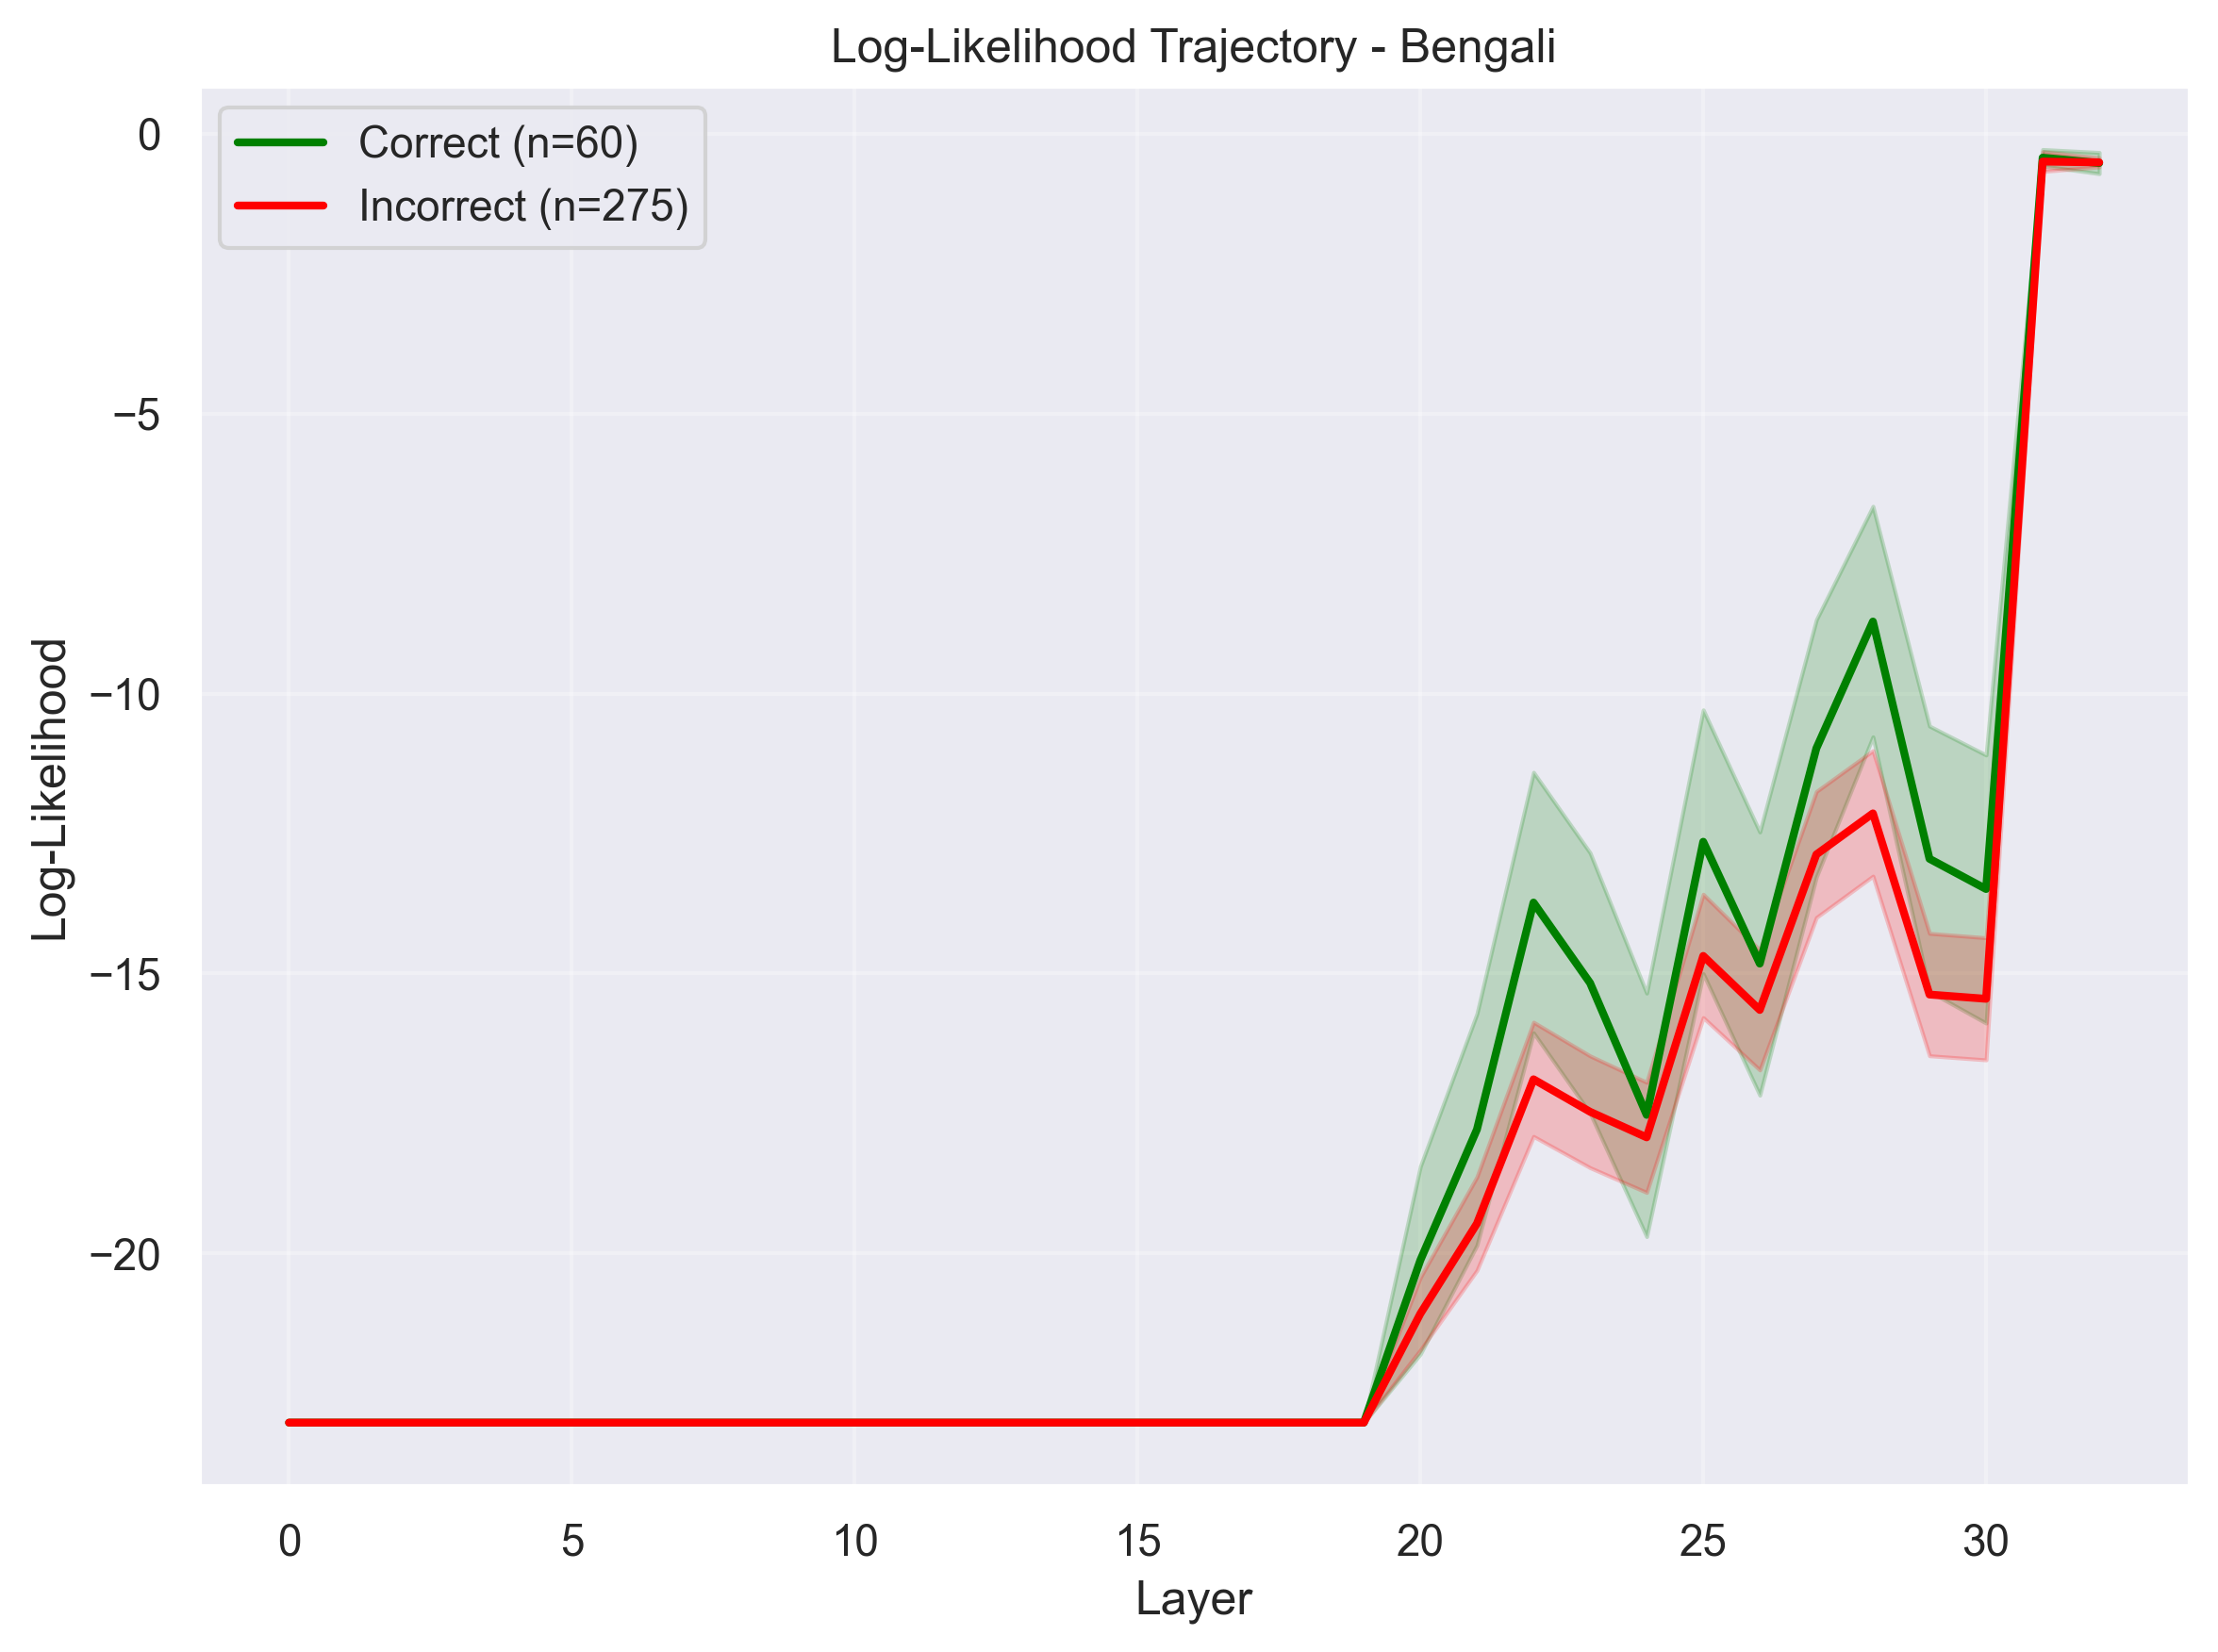

Processing english...
Saved plot: figures/loglikelihood_trajectory_english.png


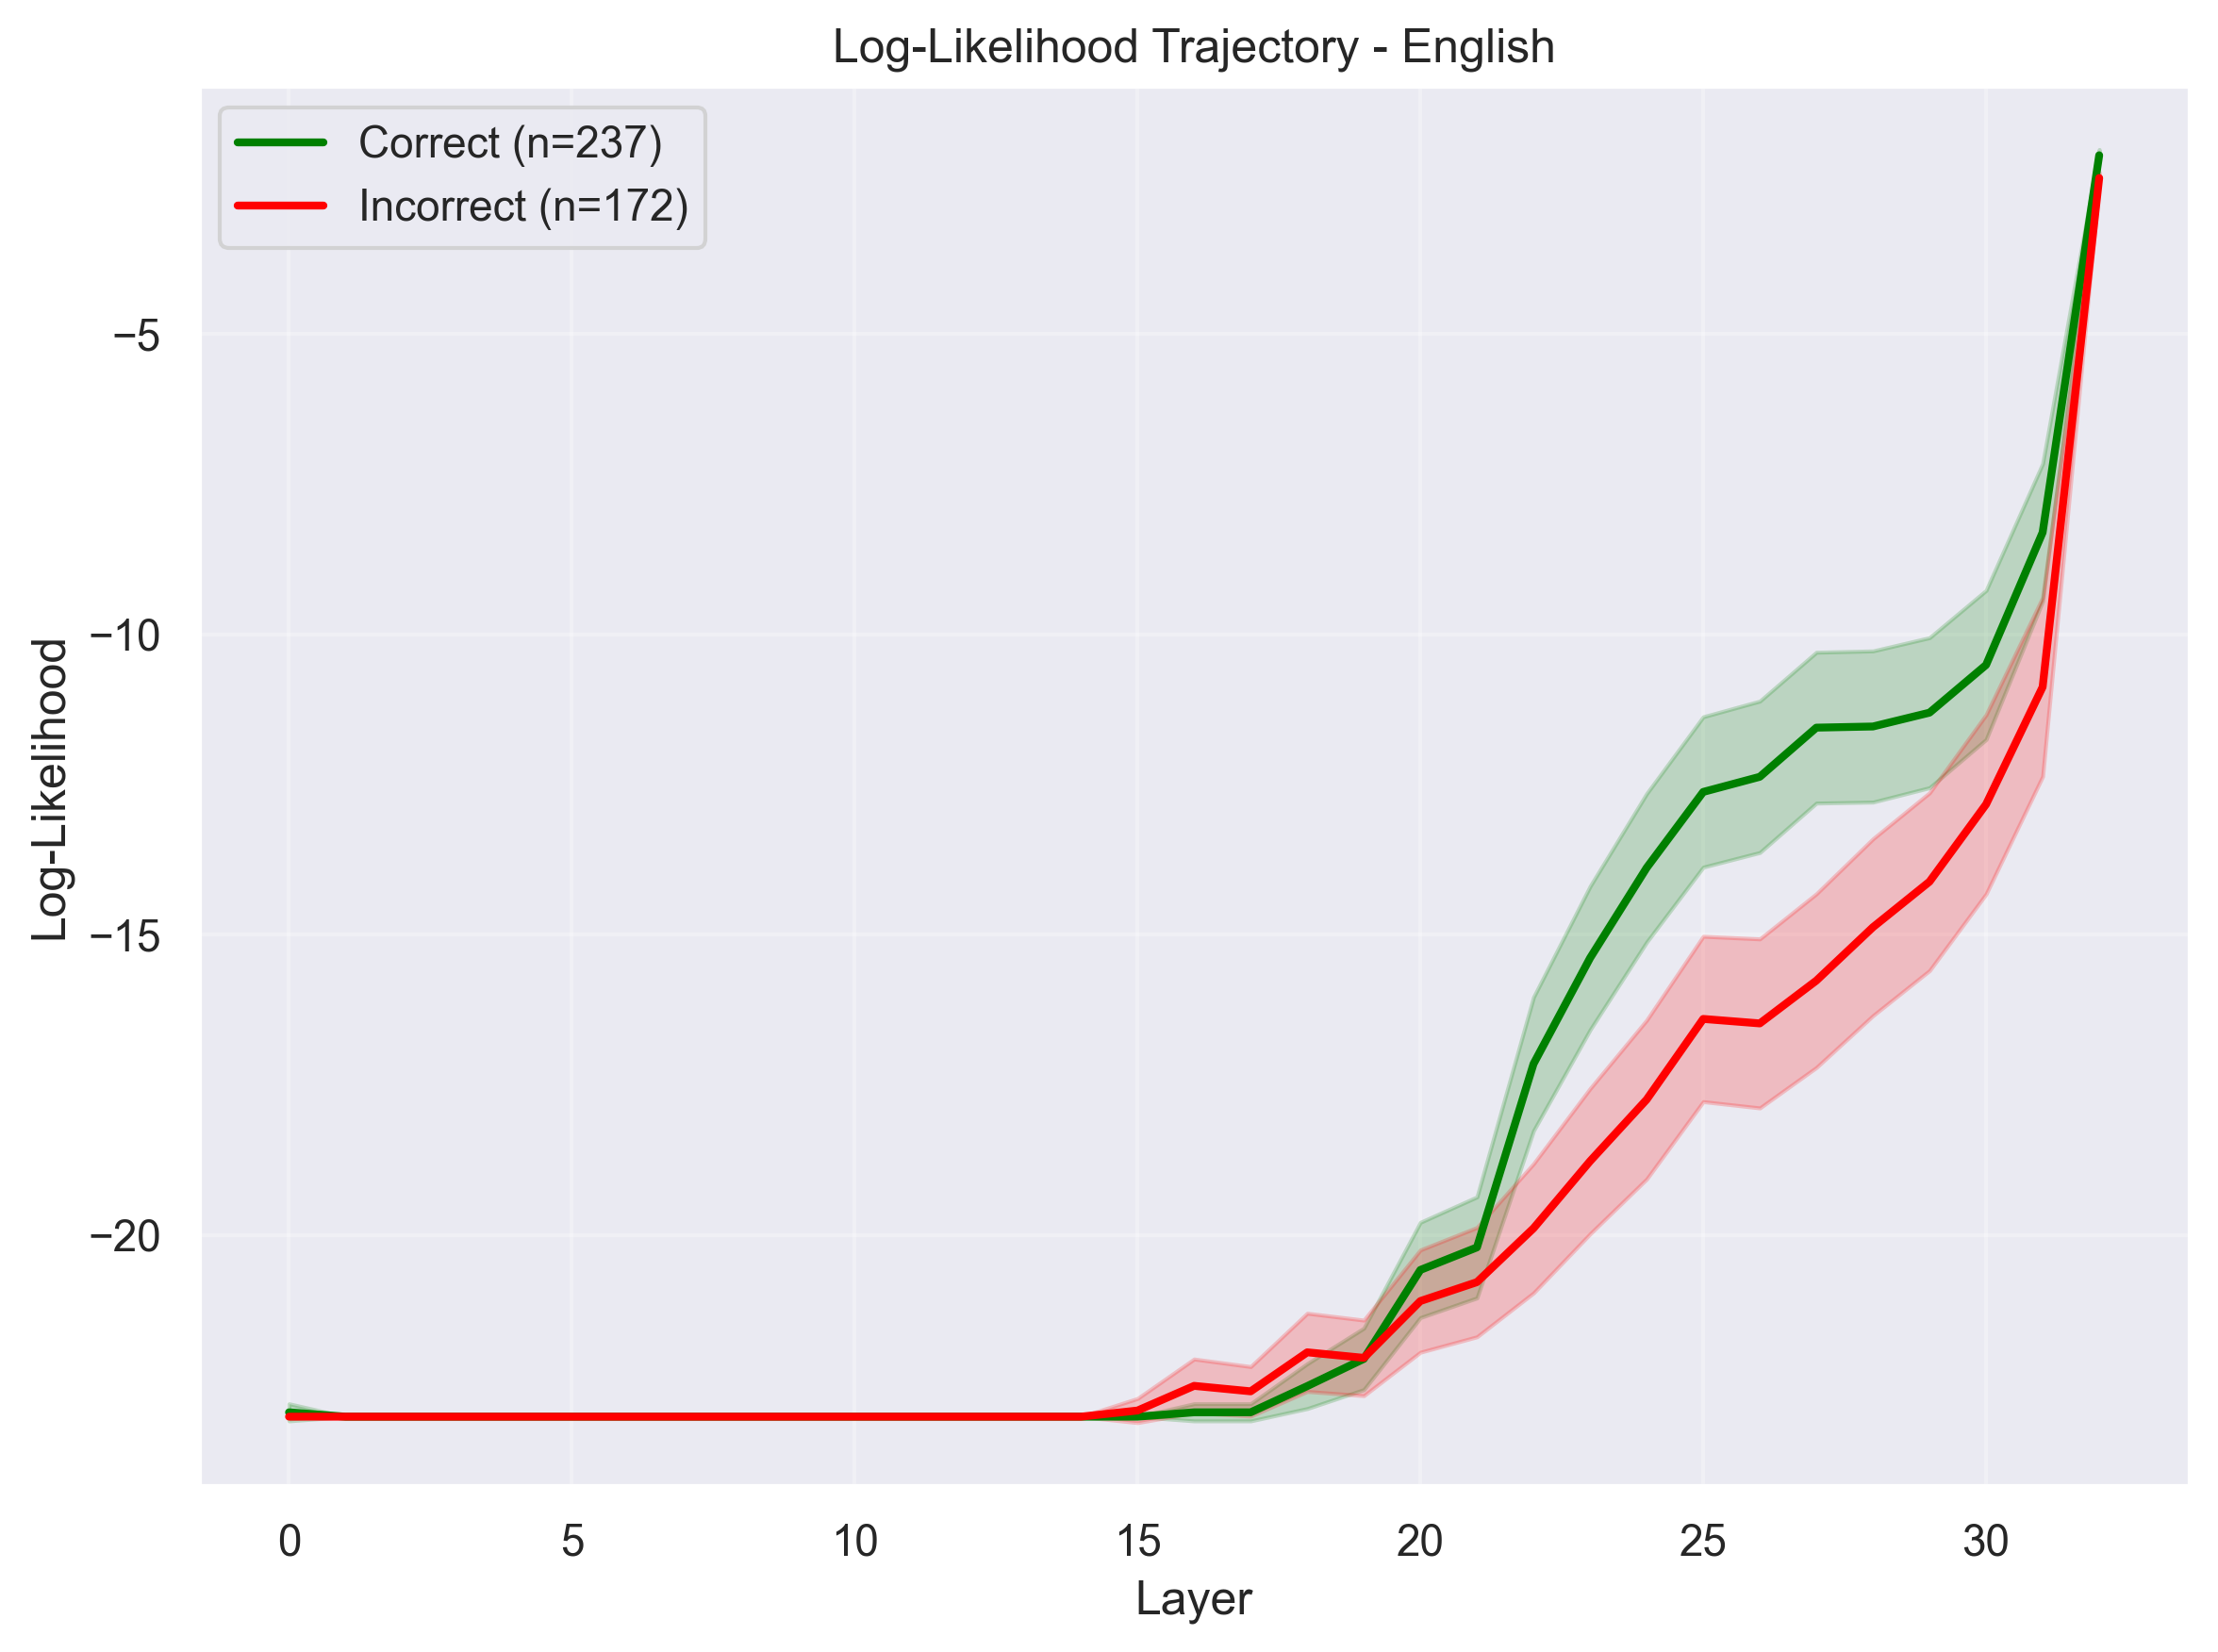

Processing spanish...
Saved plot: figures/loglikelihood_trajectory_spanish.png


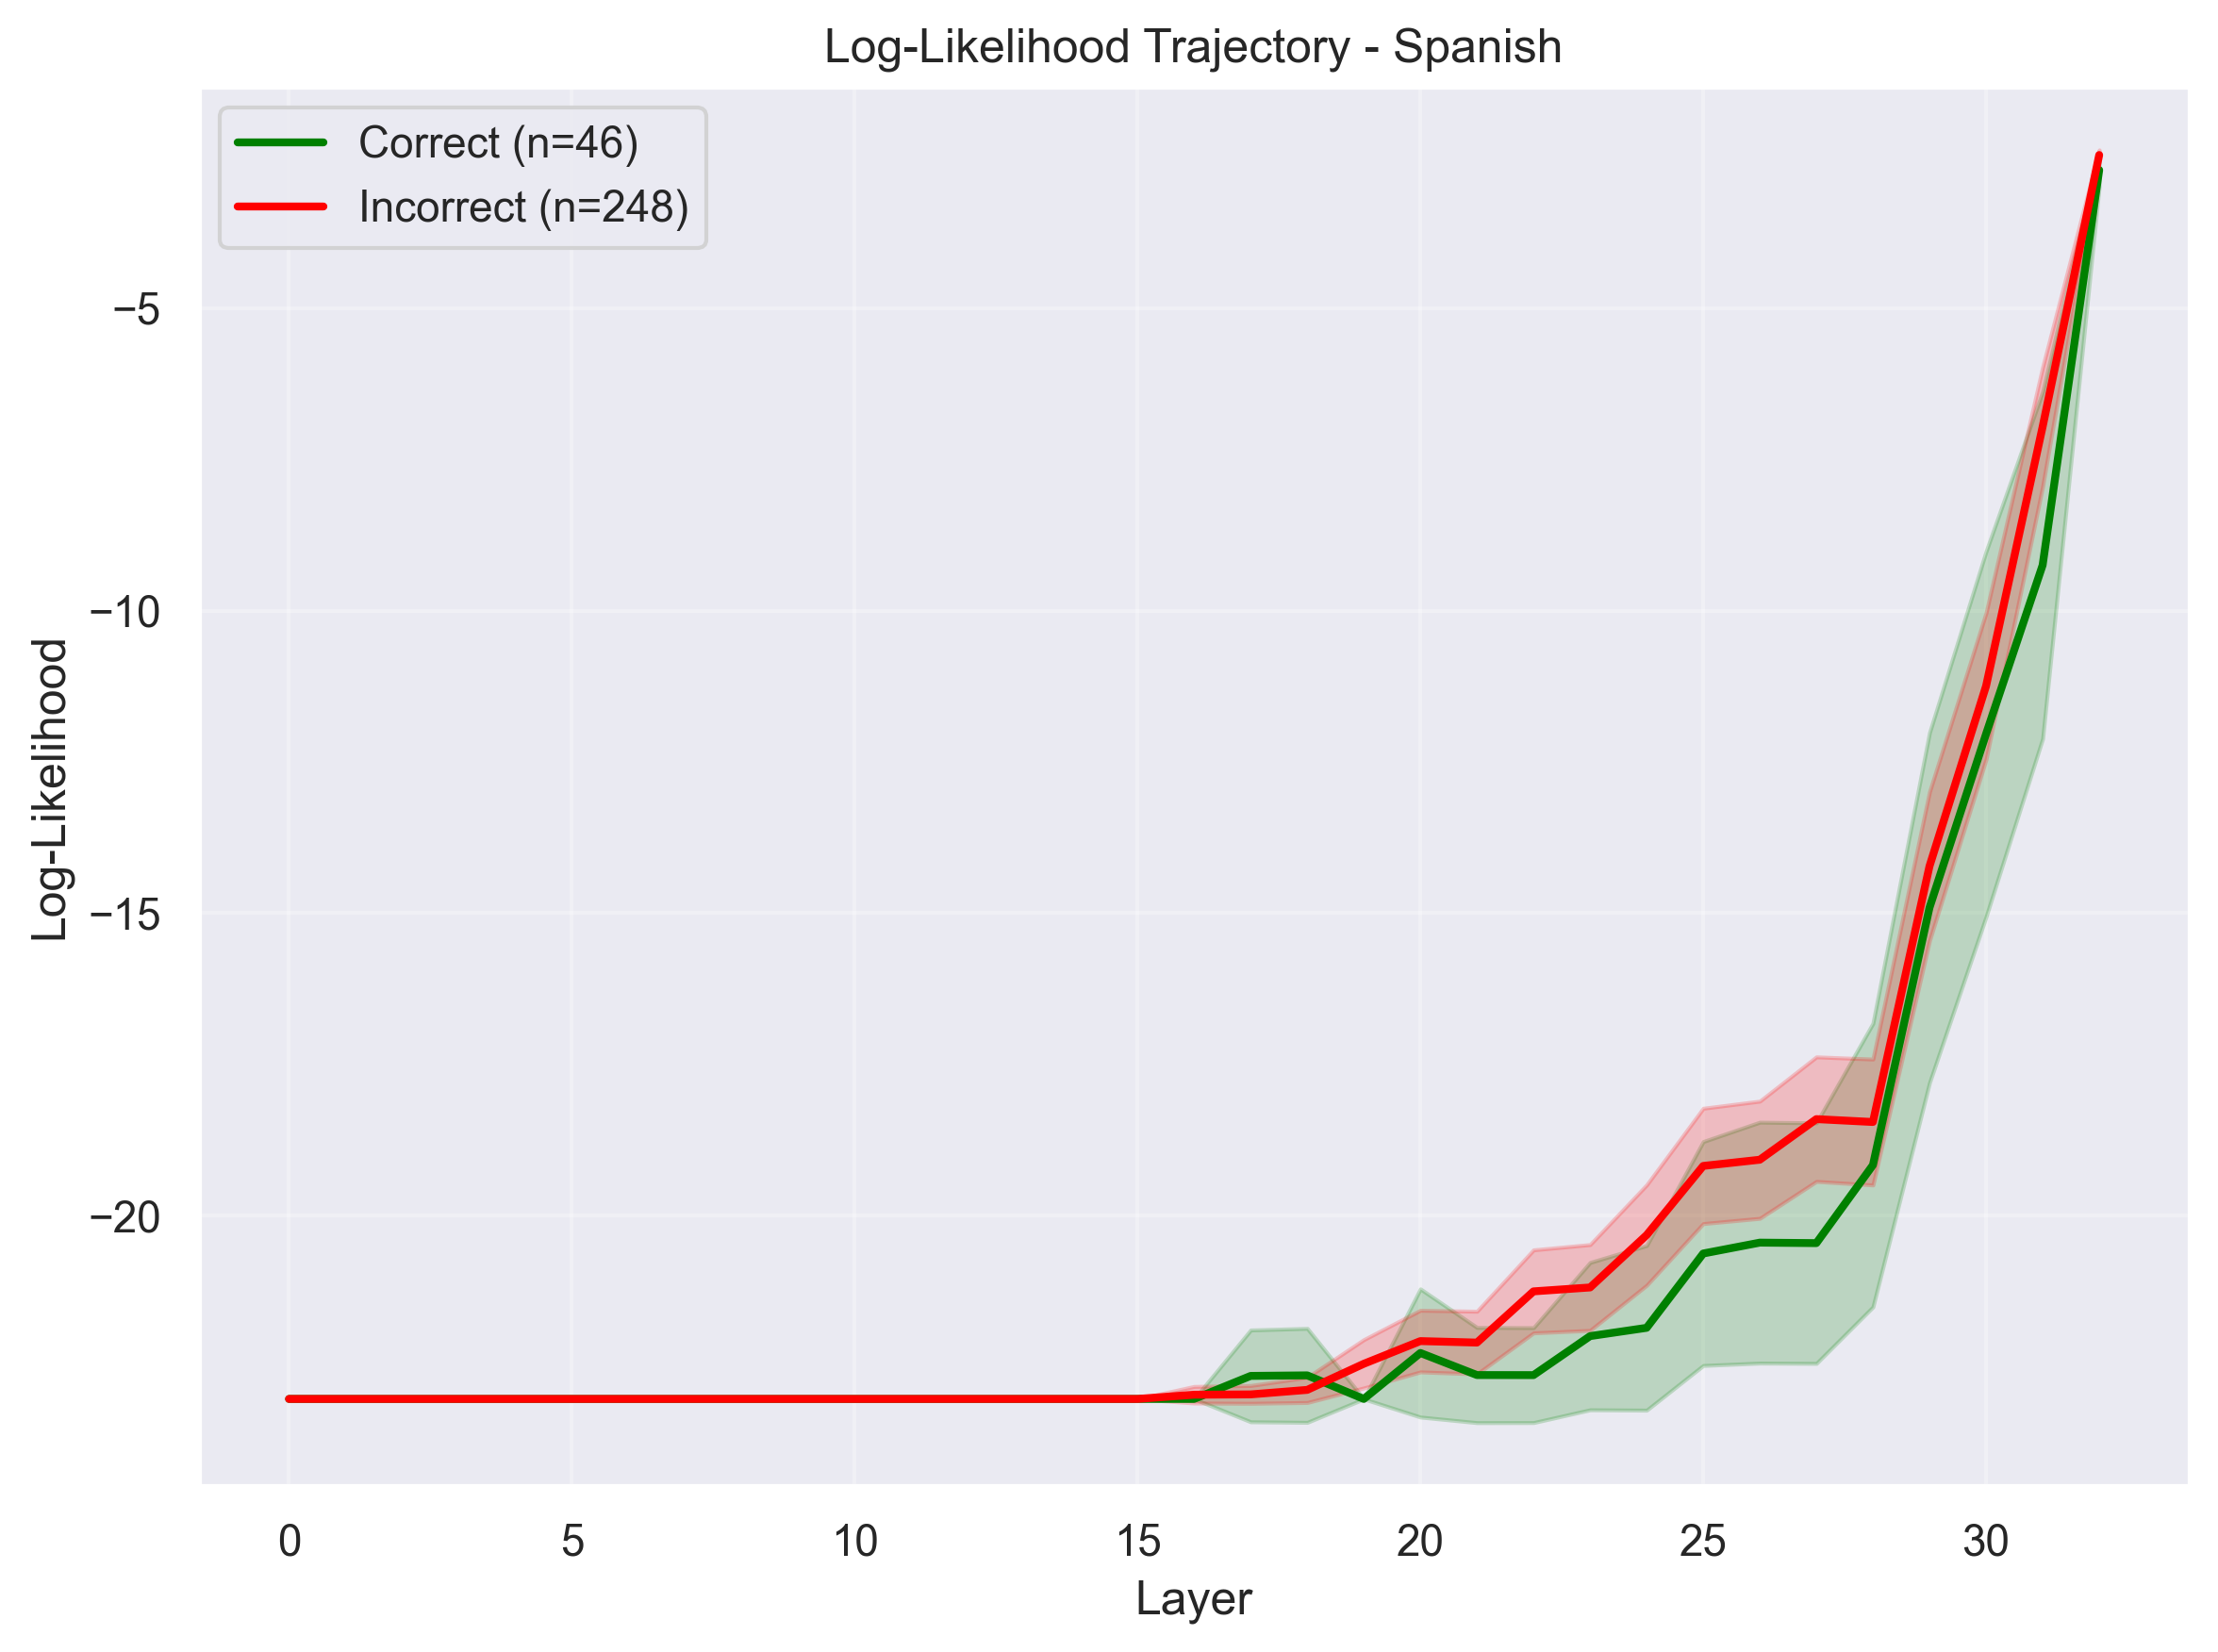

Processing assamese...
Saved plot: figures/loglikelihood_trajectory_assamese.png


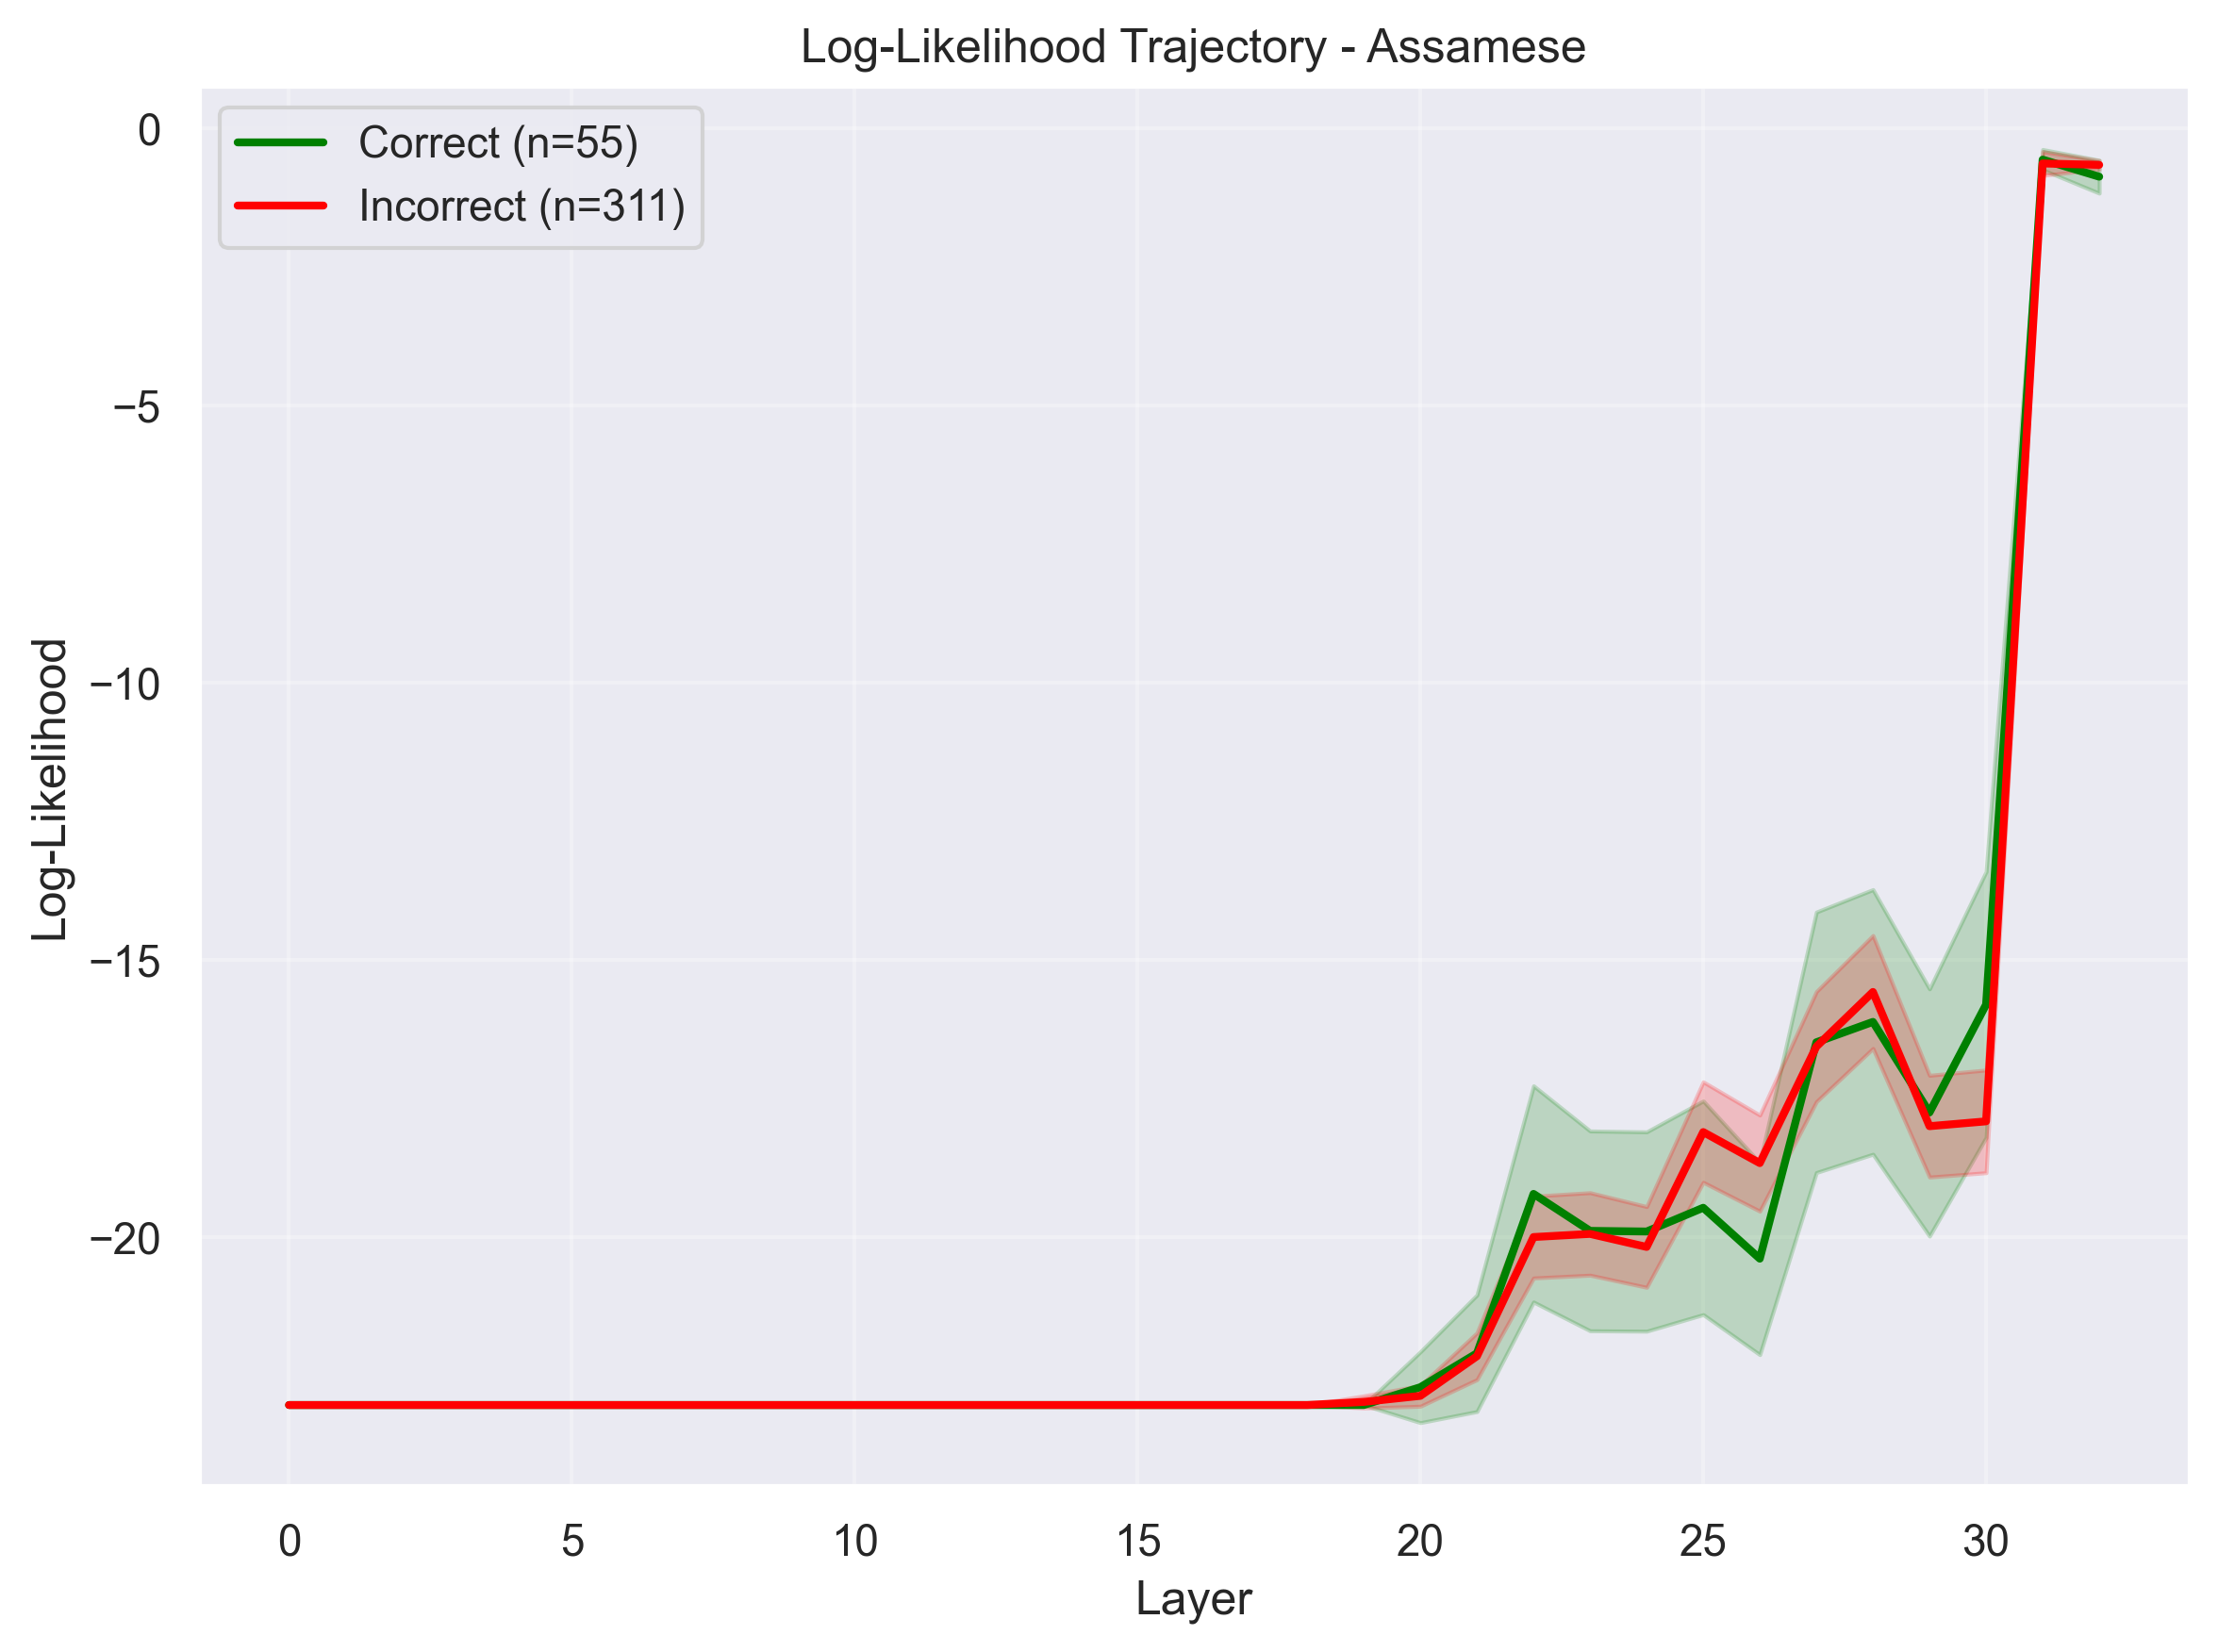

In [6]:
def get_token_logprob_trajectory(logit_lens_data: List[Dict], target_token_id: int) -> np.ndarray:
    trajectory = []
    for layer_data in logit_lens_data:
        layer_num = layer_data.get("layer")
        predictions = layer_data.get("predictions", [])        
        token_prob = None
        for pred in predictions:
            if pred.get("token_id") == target_token_id:
                token_prob = pred.get("confidence")
                break        
        if token_prob is None:
            token_prob = 1e-10
        log_prob = np.log(token_prob) if token_prob > 0 else np.log(1e-10)
        trajectory.append(log_prob)
    
    return np.array(trajectory)

def extract_final_token_id(logit_lens_data: List[Dict]) -> Optional[int]:
    if not logit_lens_data or len(logit_lens_data) == 0:
        return None
    
    final_layer = logit_lens_data[-1]  # Last layer
    if not final_layer.get("predictions"):
        return None
    
    predictions = final_layer["predictions"]
    
    # Iterate through predictions to find first non-empty token
    for prediction in predictions:
        token_id = prediction.get("token_id")
        token_str = prediction.get("token", "")
        
        # Skip if token is empty or just whitespace
        if token_str and token_str.strip():
            return token_id
    
    # If all tokens are empty, return None
    return None

def collect_trajectories_by_state(df_classified: pd.DataFrame, df_lens: pd.DataFrame, 
                                   language: str) -> Dict[str, List[np.ndarray]]:
    trajectories = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        # Extract final predicted token_id
        final_token_id = extract_final_token_id(logit_lens)
        if final_token_id is None:
            continue
        
        # Get trajectory for this token
        trajectory = get_token_logprob_trajectory(logit_lens, final_token_id)
        
        if len(trajectory) > 0:
            trajectories[state].append(trajectory)
    
    return trajectories


def compute_trajectory_statistics(trajectories: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not trajectories:
        return np.array([]), np.array([]), np.array([])
    
    # Stack trajectories
    traj_array = np.vstack(trajectories)
    
    mean = np.mean(traj_array, axis=0)
    std = np.std(traj_array, axis=0)
    n = traj_array.shape[0]
    
    ci = stats.t.ppf((1 + CONFIDENCE_LEVEL) / 2, n - 1) * std / np.sqrt(n)
    lower = mean - ci
    upper = mean + ci
    
    return mean, lower, upper


def plot_loglikelihood_trajectories(language: str, df_classified: pd.DataFrame):
    df_lens = load_lens_data(language)
    
    # Collect trajectories
    trajectories = collect_trajectories_by_state(df_classified, df_lens, language)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {State.CORRECT: "green", State.INCORRECT: "red"}
    labels = {State.CORRECT: "Correct", State.INCORRECT: "Incorrect"}
    
    for state in [State.CORRECT, State.INCORRECT]:
        if not trajectories[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(trajectories[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        # Plot mean
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(trajectories[state])})", 
                color=colors[state], linewidth=2)
        
        # Plot confidence interval
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Log-Likelihood")
    ax.set_title(f"Log-Likelihood Trajectory - {language.capitalize()}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/loglikelihood_trajectory_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


# Run analysis for all languages
print("Plotting log-likelihood trajectories...\n")

for lang in LANGUAGES:
    print(f"Processing {lang}...")
    df_classified = modified_dfs[lang]
    plot_loglikelihood_trajectories(lang, df_classified)

# KL Divergence

Plotting KL divergence trajectories...

Processing bengali...
Saved plot: figures/kl_divergence_trajectory_bengali.png


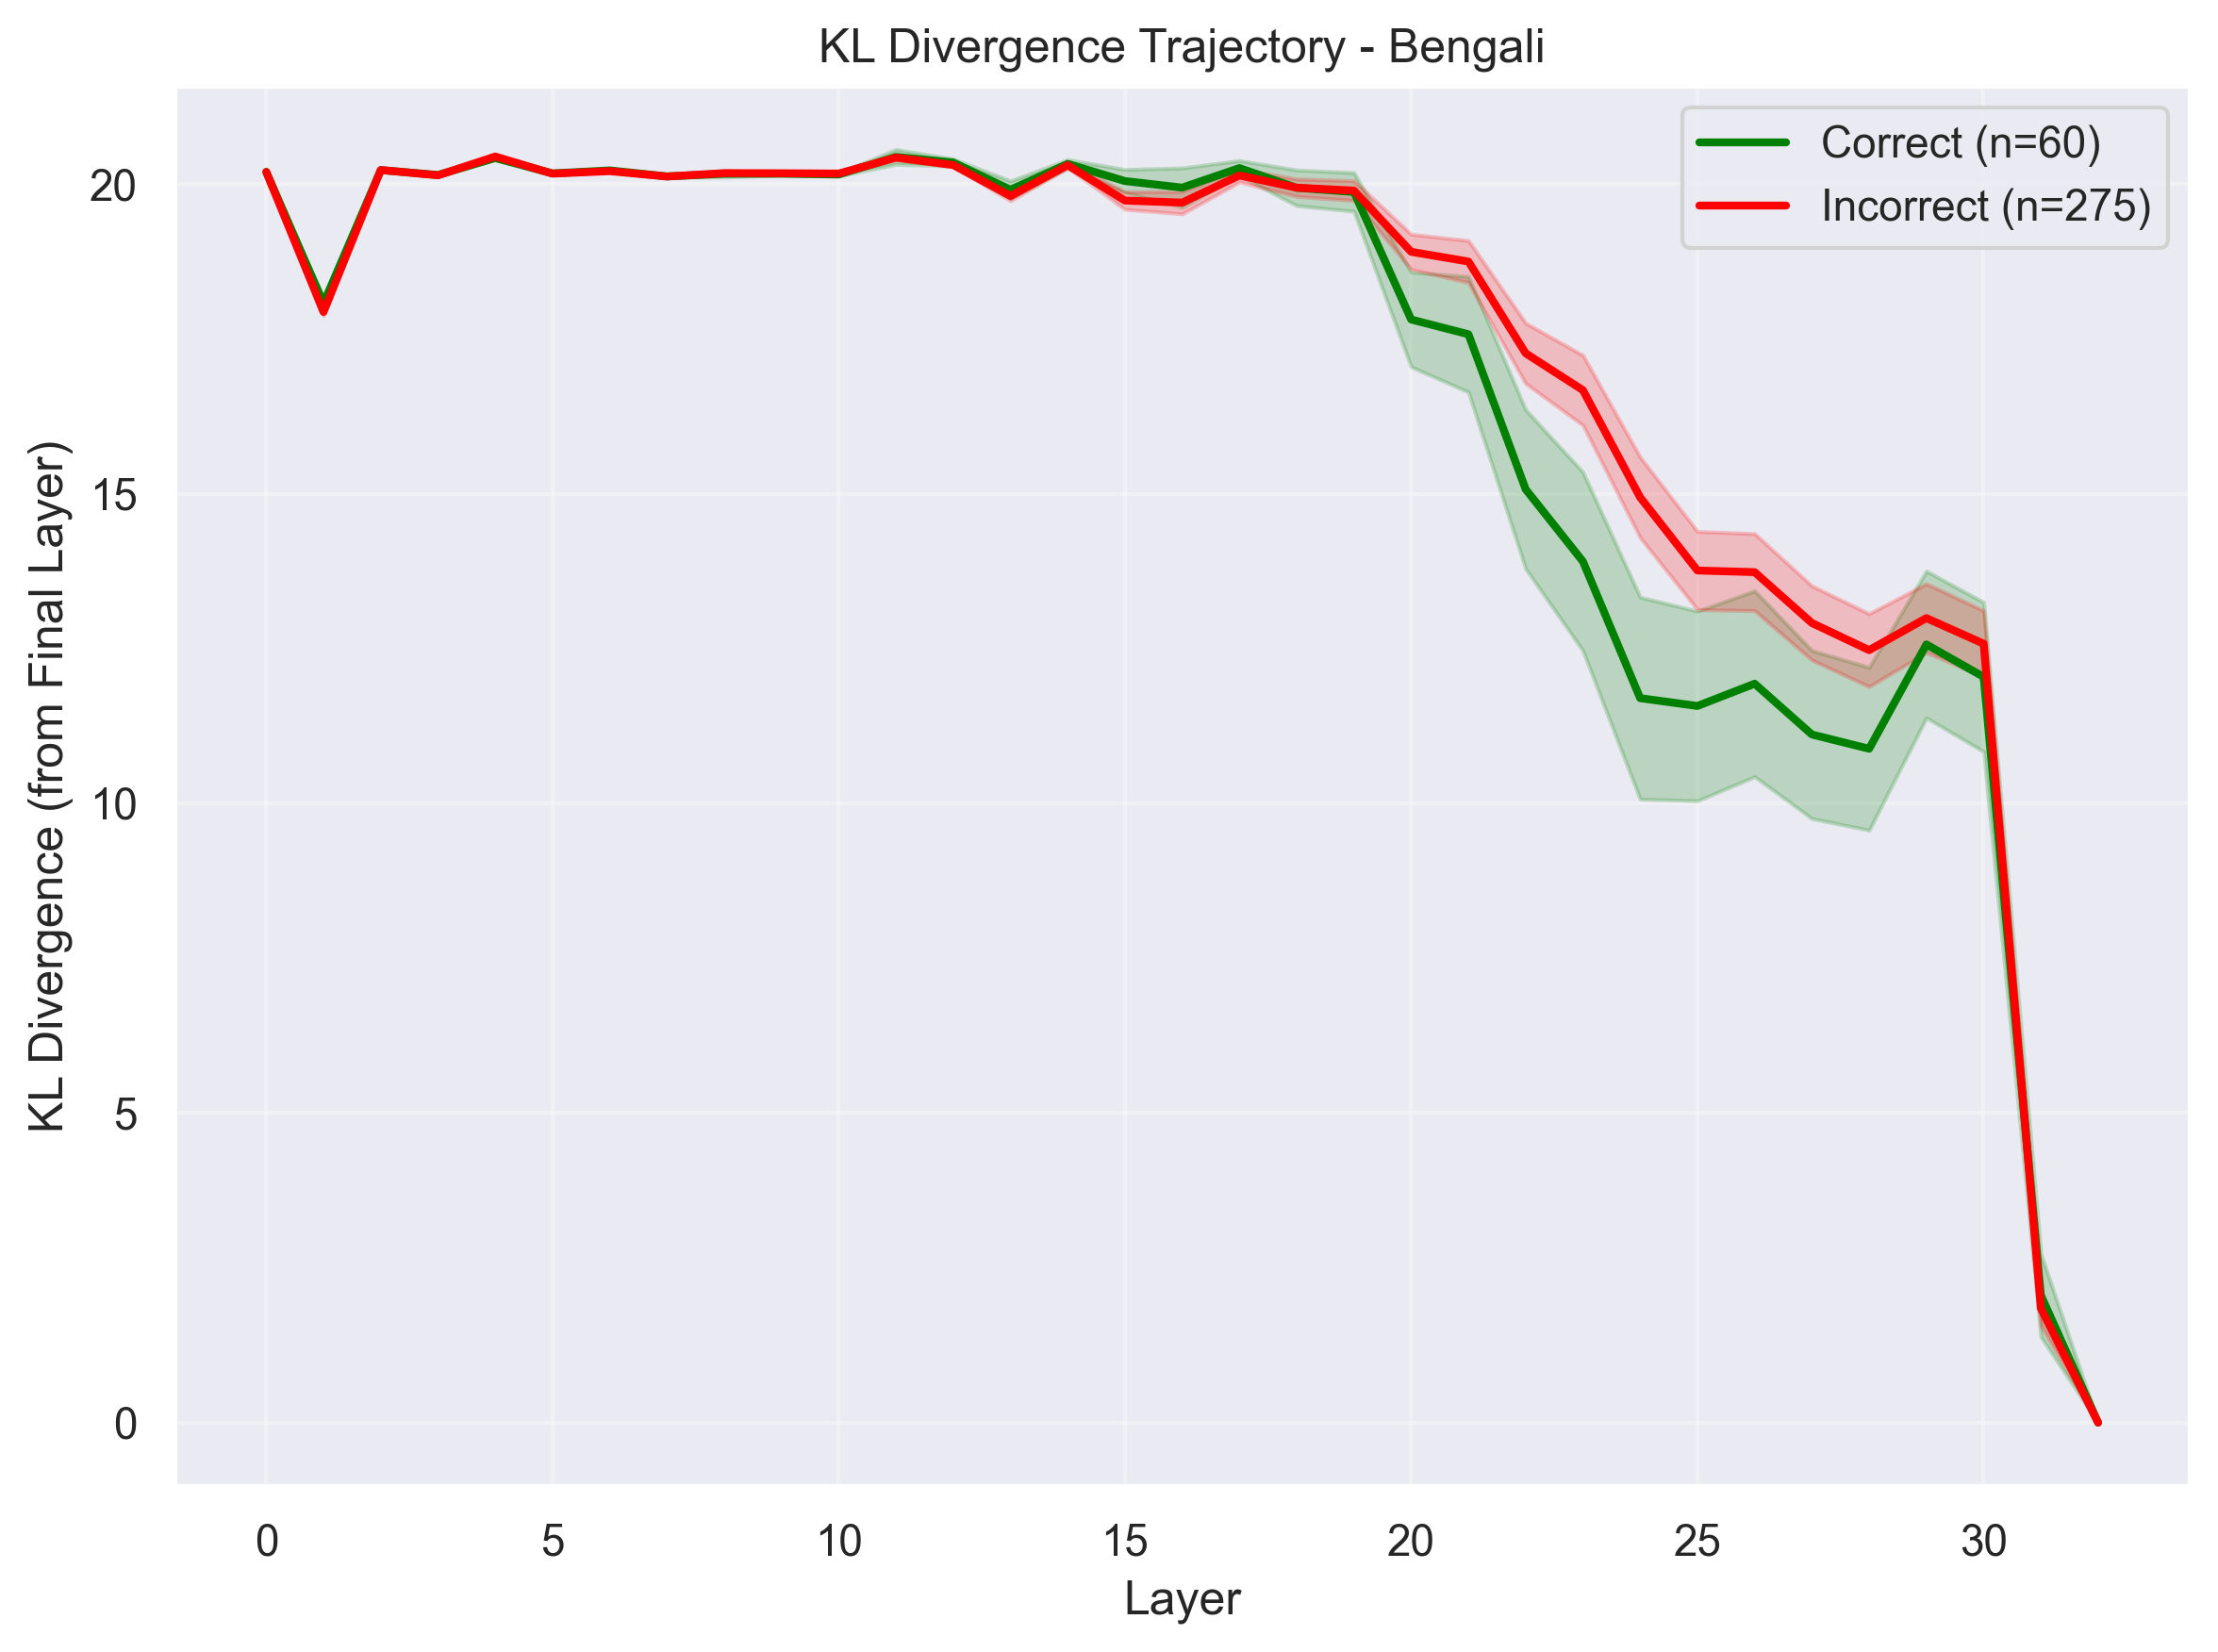

Processing english...
Saved plot: figures/kl_divergence_trajectory_english.png


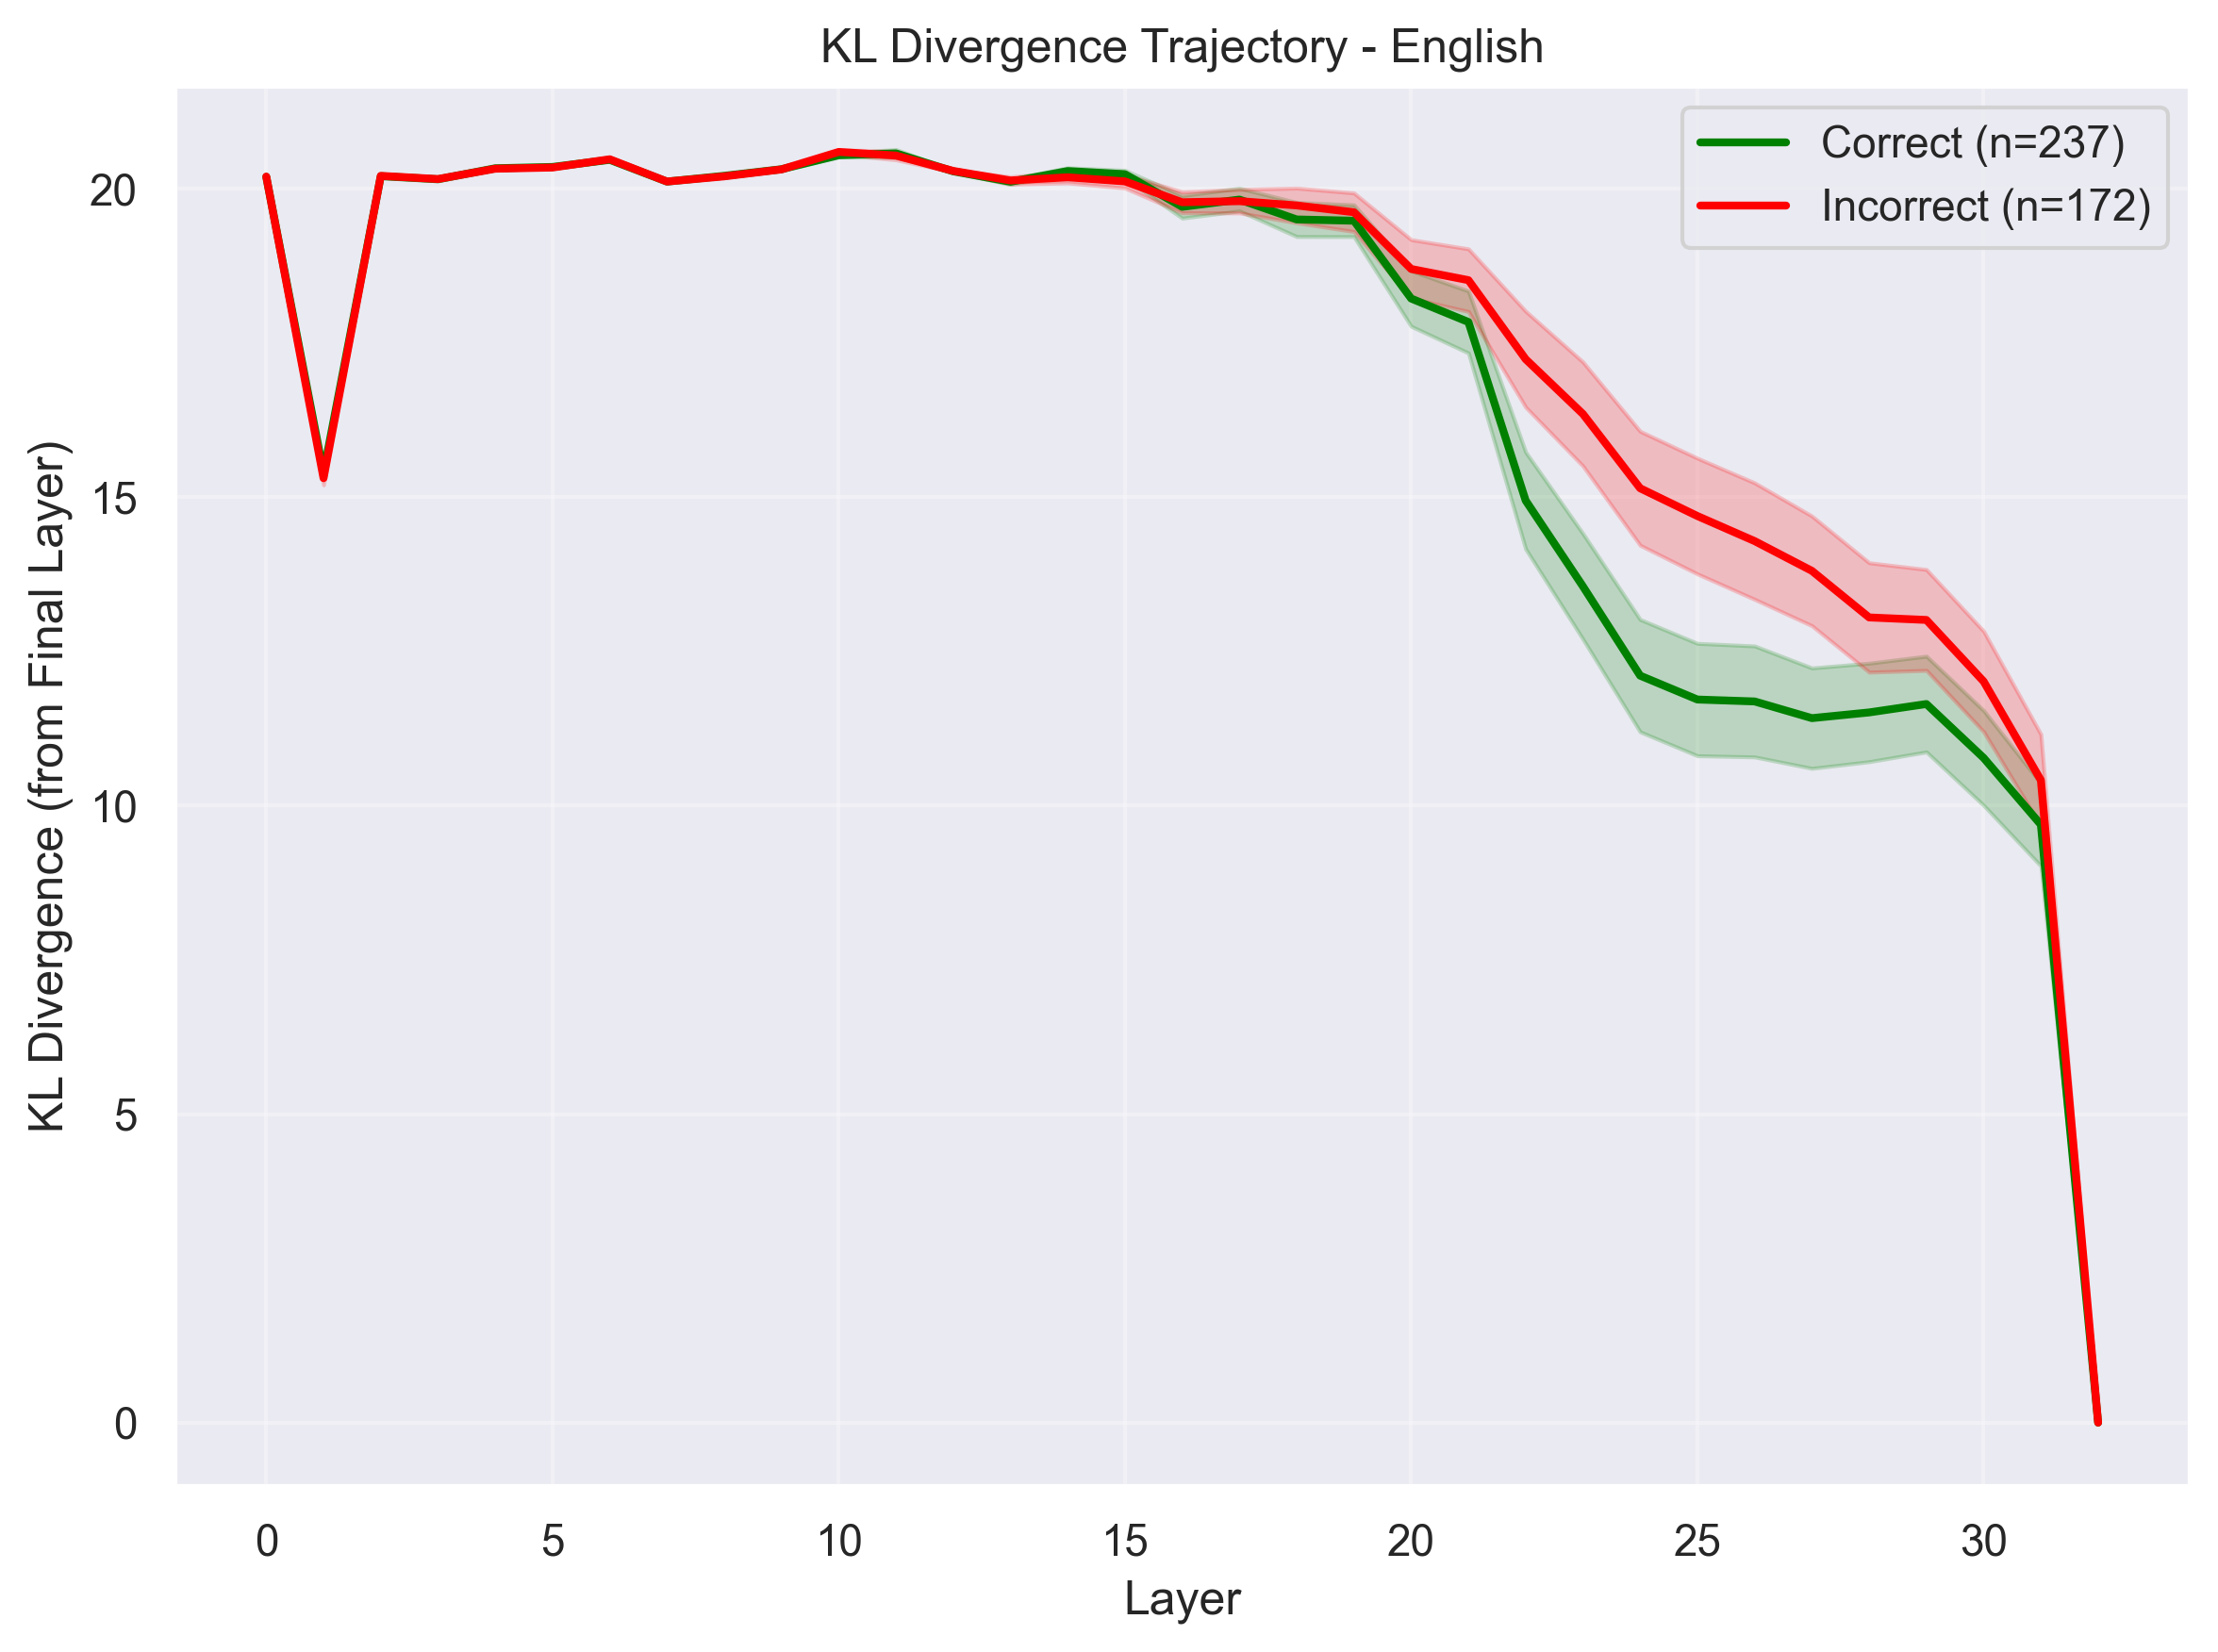

Processing spanish...
Saved plot: figures/kl_divergence_trajectory_spanish.png


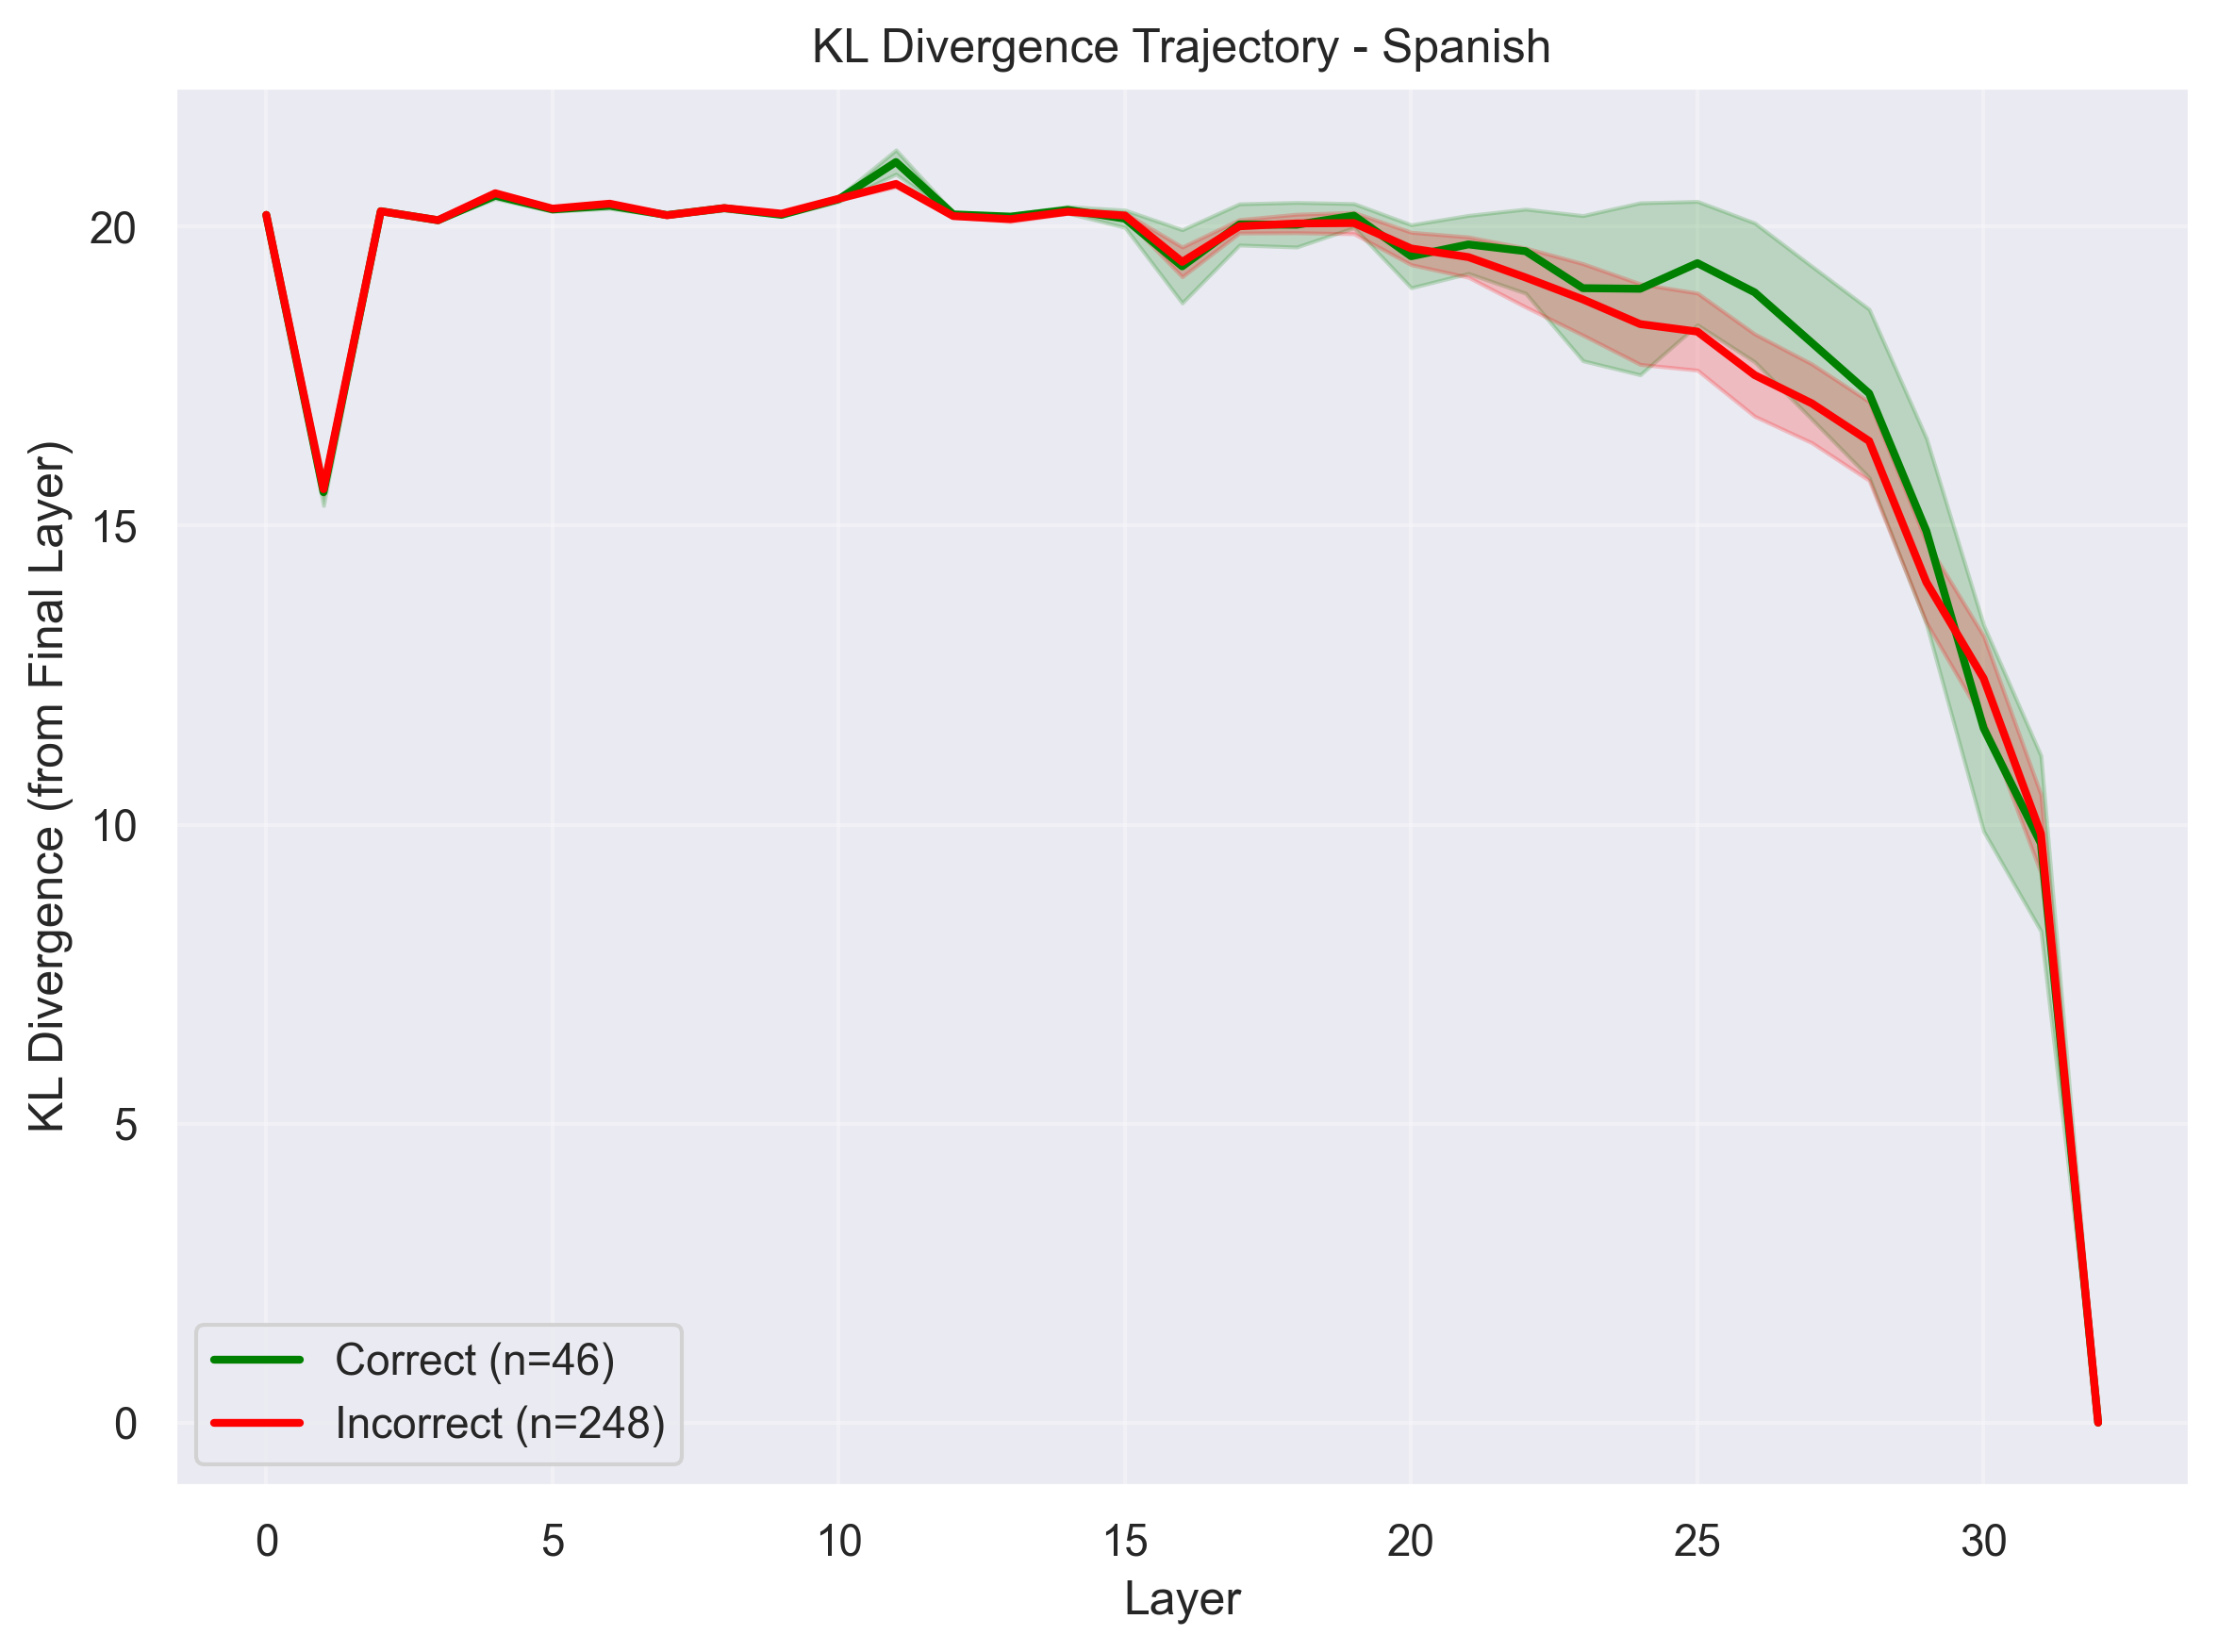

Processing assamese...
Saved plot: figures/kl_divergence_trajectory_assamese.png


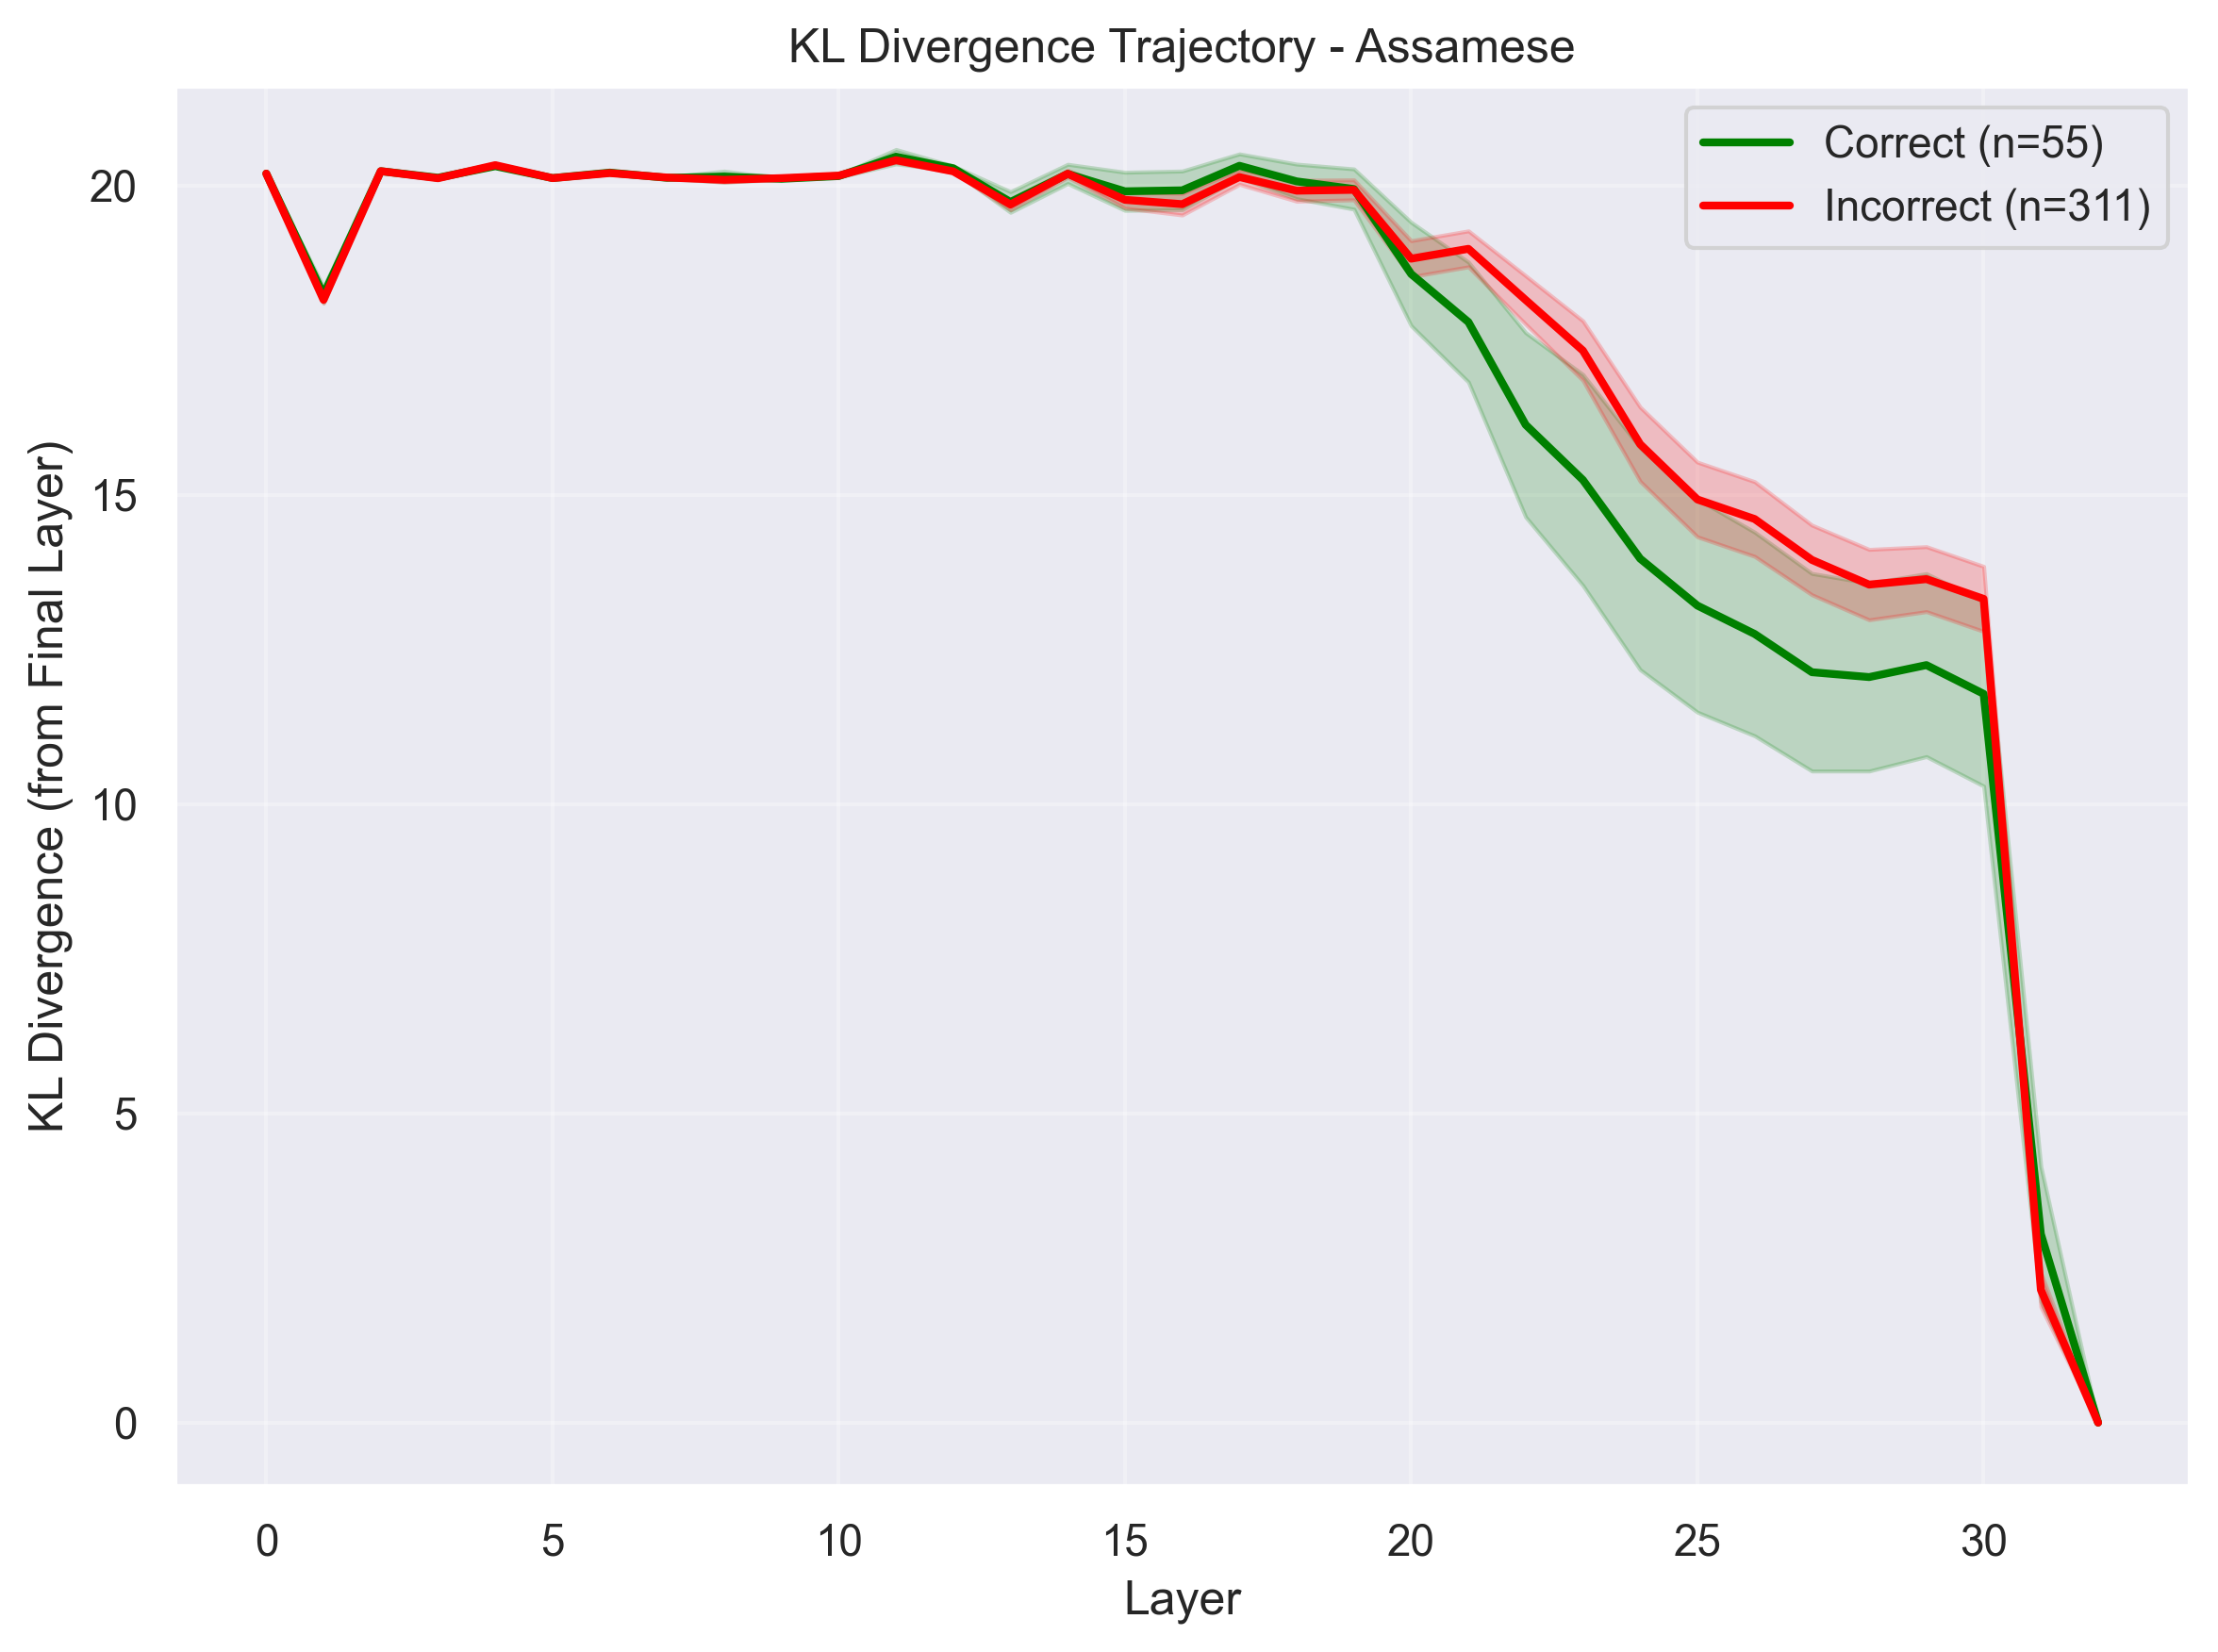

In [7]:
def get_layer_distribution(layer_data: Dict, top_k: int = 20) -> Dict[int, float]:
    """
    Extract probability distribution from a layer as a dictionary.
    Returns: {token_id: probability}
    """
    predictions = layer_data.get("predictions", [])
    distribution = {}
    
    for pred in predictions[:top_k]:
        token_id = pred.get("token_id")
        prob = pred.get("confidence", 0.0)
        if token_id is not None and prob > 0:
            distribution[token_id] = prob
    
    # Normalize to ensure it sums to 1
    total = sum(distribution.values())
    if total > 0:
        distribution = {k: v/total for k, v in distribution.items()}
    
    return distribution


def compute_kl_divergence(p_dist: Dict[int, float], q_dist: Dict[int, float]) -> float:
    """
    Compute KL(P || Q) where P and Q are distributions over token_ids.
    KL(P||Q) = sum_i P(i) * log(P(i) / Q(i))
    """
    if not p_dist or not q_dist:
        return np.nan
    
    # Get union of all tokens
    all_tokens = set(p_dist.keys()) | set(q_dist.keys())
    
    kl = 0.0
    epsilon = 1e-10  # Small value to avoid log(0)
    
    for token_id in all_tokens:
        p = p_dist.get(token_id, epsilon)
        q = q_dist.get(token_id, epsilon)
        
        if p > epsilon:  # Only sum when P(token) is non-zero
            kl += p * np.log(p / q)
    
    return kl


def compute_kl_trajectory(logit_lens_data: List[Dict]) -> np.ndarray:
    """
    Compute KL divergence between each layer and the final layer.
    Returns array of KL divergences for layers 0 to L-1.
    """
    if not logit_lens_data or len(logit_lens_data) == 0:
        return np.array([])
    
    # Get final layer distribution
    final_layer = logit_lens_data[-1]
    final_dist = get_layer_distribution(final_layer)
    
    kl_trajectory = []
    
    # Compute KL for each layer vs final layer
    for layer_data in logit_lens_data[:-1]:  # Exclude final layer
        layer_dist = get_layer_distribution(layer_data)
        kl = compute_kl_divergence(layer_dist, final_dist)
        kl_trajectory.append(kl)
    
    # Add 0 for final layer (KL with itself)
    kl_trajectory.append(0.0)
    
    return np.array(kl_trajectory)


def collect_kl_trajectories_by_state(df_classified: pd.DataFrame, df_lens: pd.DataFrame) -> Dict[str, List[np.ndarray]]:
    """Collect KL divergence trajectories grouped by answer state."""
    trajectories = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        # Skip UNDETERMINED
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        # Get KL trajectory
        kl_traj = compute_kl_trajectory(logit_lens)
        
        if len(kl_traj) > 0 and not np.any(np.isnan(kl_traj)):
            trajectories[state].append(kl_traj)
    
    return trajectories


def plot_kl_divergence_trajectories(language: str, df_classified: pd.DataFrame):
    """Plot KL divergence trajectories for correct vs incorrect answers."""
    df_lens = load_lens_data(language)
    
    # Collect KL trajectories
    trajectories = collect_kl_trajectories_by_state(df_classified, df_lens)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {State.CORRECT: "green", State.INCORRECT: "red"}
    labels = {State.CORRECT: "Correct", State.INCORRECT: "Incorrect"}
    
    for state in [State.CORRECT, State.INCORRECT]:
        if not trajectories[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(trajectories[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        # Plot mean
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(trajectories[state])})", 
                color=colors[state], linewidth=2)
        
        # Plot confidence interval
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("KL Divergence (from Final Layer)")
    ax.set_title(f"KL Divergence Trajectory - {language.capitalize()}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/kl_divergence_trajectory_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


# Run analysis for all languages
print("Plotting KL divergence trajectories...\n")

for lang in LANGUAGES:
    print(f"Processing {lang}...")
    df_classified = modified_dfs[lang]
    plot_kl_divergence_trajectories(lang, df_classified)

In [8]:
def analyze_layer1_kl_dip(df_classified: pd.DataFrame, df_lens: pd.DataFrame, language: str):
    """Analyze cases where layer 1 KL is lower than layers 0 and 2"""
    
    dip_cases = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens or len(logit_lens) < 3:
            continue
        
        kl_traj = compute_kl_trajectory(logit_lens)
        
        if len(kl_traj) < 3 or np.any(np.isnan(kl_traj)):
            continue
        
        # Check if layer 1 has a dip (lower than both layer 0 and layer 2)
        if kl_traj[1] < kl_traj[0] and kl_traj[1] < kl_traj[2]:
            # Get distributions
            layer0_dist = get_layer_distribution(logit_lens[0])
            layer1_dist = get_layer_distribution(logit_lens[1])
            layer2_dist = get_layer_distribution(logit_lens[2])
            final_dist = get_layer_distribution(logit_lens[-1])
            
            # Find tokens that increase in layer 1 (closer to final)
            tokens_increased = []
            for token_id in final_dist.keys():
                prob_l0 = layer0_dist.get(token_id, 0.0)
                prob_l1 = layer1_dist.get(token_id, 0.0)
                prob_l2 = layer2_dist.get(token_id, 0.0)
                prob_final = final_dist.get(token_id, 0.0)
                
                # If layer 1 is closer to final than layer 0
                if prob_l1 > prob_l0 and abs(prob_l1 - prob_final) < abs(prob_l0 - prob_final):
                    # Get token string
                    token_str = None
                    for pred in logit_lens[1]["predictions"]:
                        if pred.get("token_id") == token_id:
                            token_str = pred.get("token", "")
                            break
                    
                    tokens_increased.append({
                        'token_id': token_id,
                        'token': token_str,
                        'prob_l0': prob_l0,
                        'prob_l1': prob_l1,
                        'prob_l2': prob_l2,
                        'prob_final': prob_final,
                        'increase_l0_to_l1': prob_l1 - prob_l0
                    })
            
            # Sort by increase magnitude
            tokens_increased.sort(key=lambda x: x['increase_l0_to_l1'], reverse=True)
            
            dip_cases[state].append({
                'idx': idx,
                'kl_l0': kl_traj[0],
                'kl_l1': kl_traj[1],
                'kl_l2': kl_traj[2],
                'dip_magnitude': (kl_traj[0] - kl_traj[1]) + (kl_traj[2] - kl_traj[1]),
                'tokens_increased': tokens_increased[:10]  # Top 10
            })
    
    # Print analysis
    print(f"\n=== Layer 1 KL Dip Analysis for {language.capitalize()} ===")
    for state in [State.CORRECT, State.INCORRECT]:
        cases = dip_cases[state]
        if cases:
            print(f"\n{state.upper()}: {len(cases)} cases with layer 1 dip")
            # Sort by dip magnitude
            sorted_cases = sorted(cases, key=lambda x: x['dip_magnitude'], reverse=True)[:5]
            
            for i, case in enumerate(sorted_cases, 1):
                print(f"\n  Case {i} - Idx {case['idx']}:")
                print(f"    KL Layer 0: {case['kl_l0']:.4f}")
                print(f"    KL Layer 1: {case['kl_l1']:.4f} (DIP)")
                print(f"    KL Layer 2: {case['kl_l2']:.4f}")
                print(f"    Dip Magnitude: {case['dip_magnitude']:.4f}")
                
                print(f"\n    Tokens that moved toward final distribution in layer 1:")
                for tok_info in case['tokens_increased'][:5]:
                    if tok_info['token']:
                        print(f"      '{tok_info['token']}' (id={tok_info['token_id']})")
                        print(f"        L0: {tok_info['prob_l0']:.4f} -> L1: {tok_info['prob_l1']:.4f} -> L2: {tok_info['prob_l2']:.4f} -> Final: {tok_info['prob_final']:.4f}")
                        print(f"        Increase: +{tok_info['increase_l0_to_l1']:.4f}")
    
    return dip_cases


# Run analysis
print("\nAnalyzing layer 1 KL dips...\n")

for lang in LANGUAGES:
    df_classified = modified_dfs[lang]
    df_lens = load_lens_data(lang)
    dip_analysis = analyze_layer1_kl_dip(df_classified, df_lens, lang)


Analyzing layer 1 KL dips...


=== Layer 1 KL Dip Analysis for Bengali ===

CORRECT: 60 cases with layer 1 dip

  Case 1 - Idx Na-ko-30:
    KL Layer 0: 20.1961
    KL Layer 1: 16.9693 (DIP)
    KL Layer 2: 20.2113
    Dip Magnitude: 6.4688

    Tokens that moved toward final distribution in layer 1:

  Case 2 - Idx Na-ko-44:
    KL Layer 0: 20.1961
    KL Layer 1: 17.0669 (DIP)
    KL Layer 2: 20.2269
    Dip Magnitude: 6.2891

    Tokens that moved toward final distribution in layer 1:
      ' ' (id=220)
        L0: 0.0000 -> L1: 0.1461 -> L2: 0.0000 -> Final: 0.4097
        Increase: +0.1461

  Case 3 - Idx An-ar-36:
    KL Layer 0: 20.1961
    KL Layer 1: 17.3148 (DIP)
    KL Layer 2: 20.1836
    Dip Magnitude: 5.7499

    Tokens that moved toward final distribution in layer 1:

  Case 4 - Idx Ne-ar-16:
    KL Layer 0: 20.1961
    KL Layer 1: 17.3832 (DIP)
    KL Layer 2: 20.2366
    Dip Magnitude: 5.6662

    Tokens that moved toward final distribution in layer 1:

  Case 5 - Idx

Layer 1 in transformers often acts as a "format layer" that makes quick decisions about structural tokens (spaces, punctuation, brackets) before deeper semantic processing happens in later layers. In early layers, attention patterns are heavily influenced by positional encodings and token-type patterns. Spaces/brackets have very predictable patterns, so layer 1 can "confidently" assign them high probability early. That's why we are noticing this dip -- maybe

# Shannon Entropy

Plotting entropy trajectories...

Processing bengali...
Saved plot: figures/entropy_trajectory_bengali.png


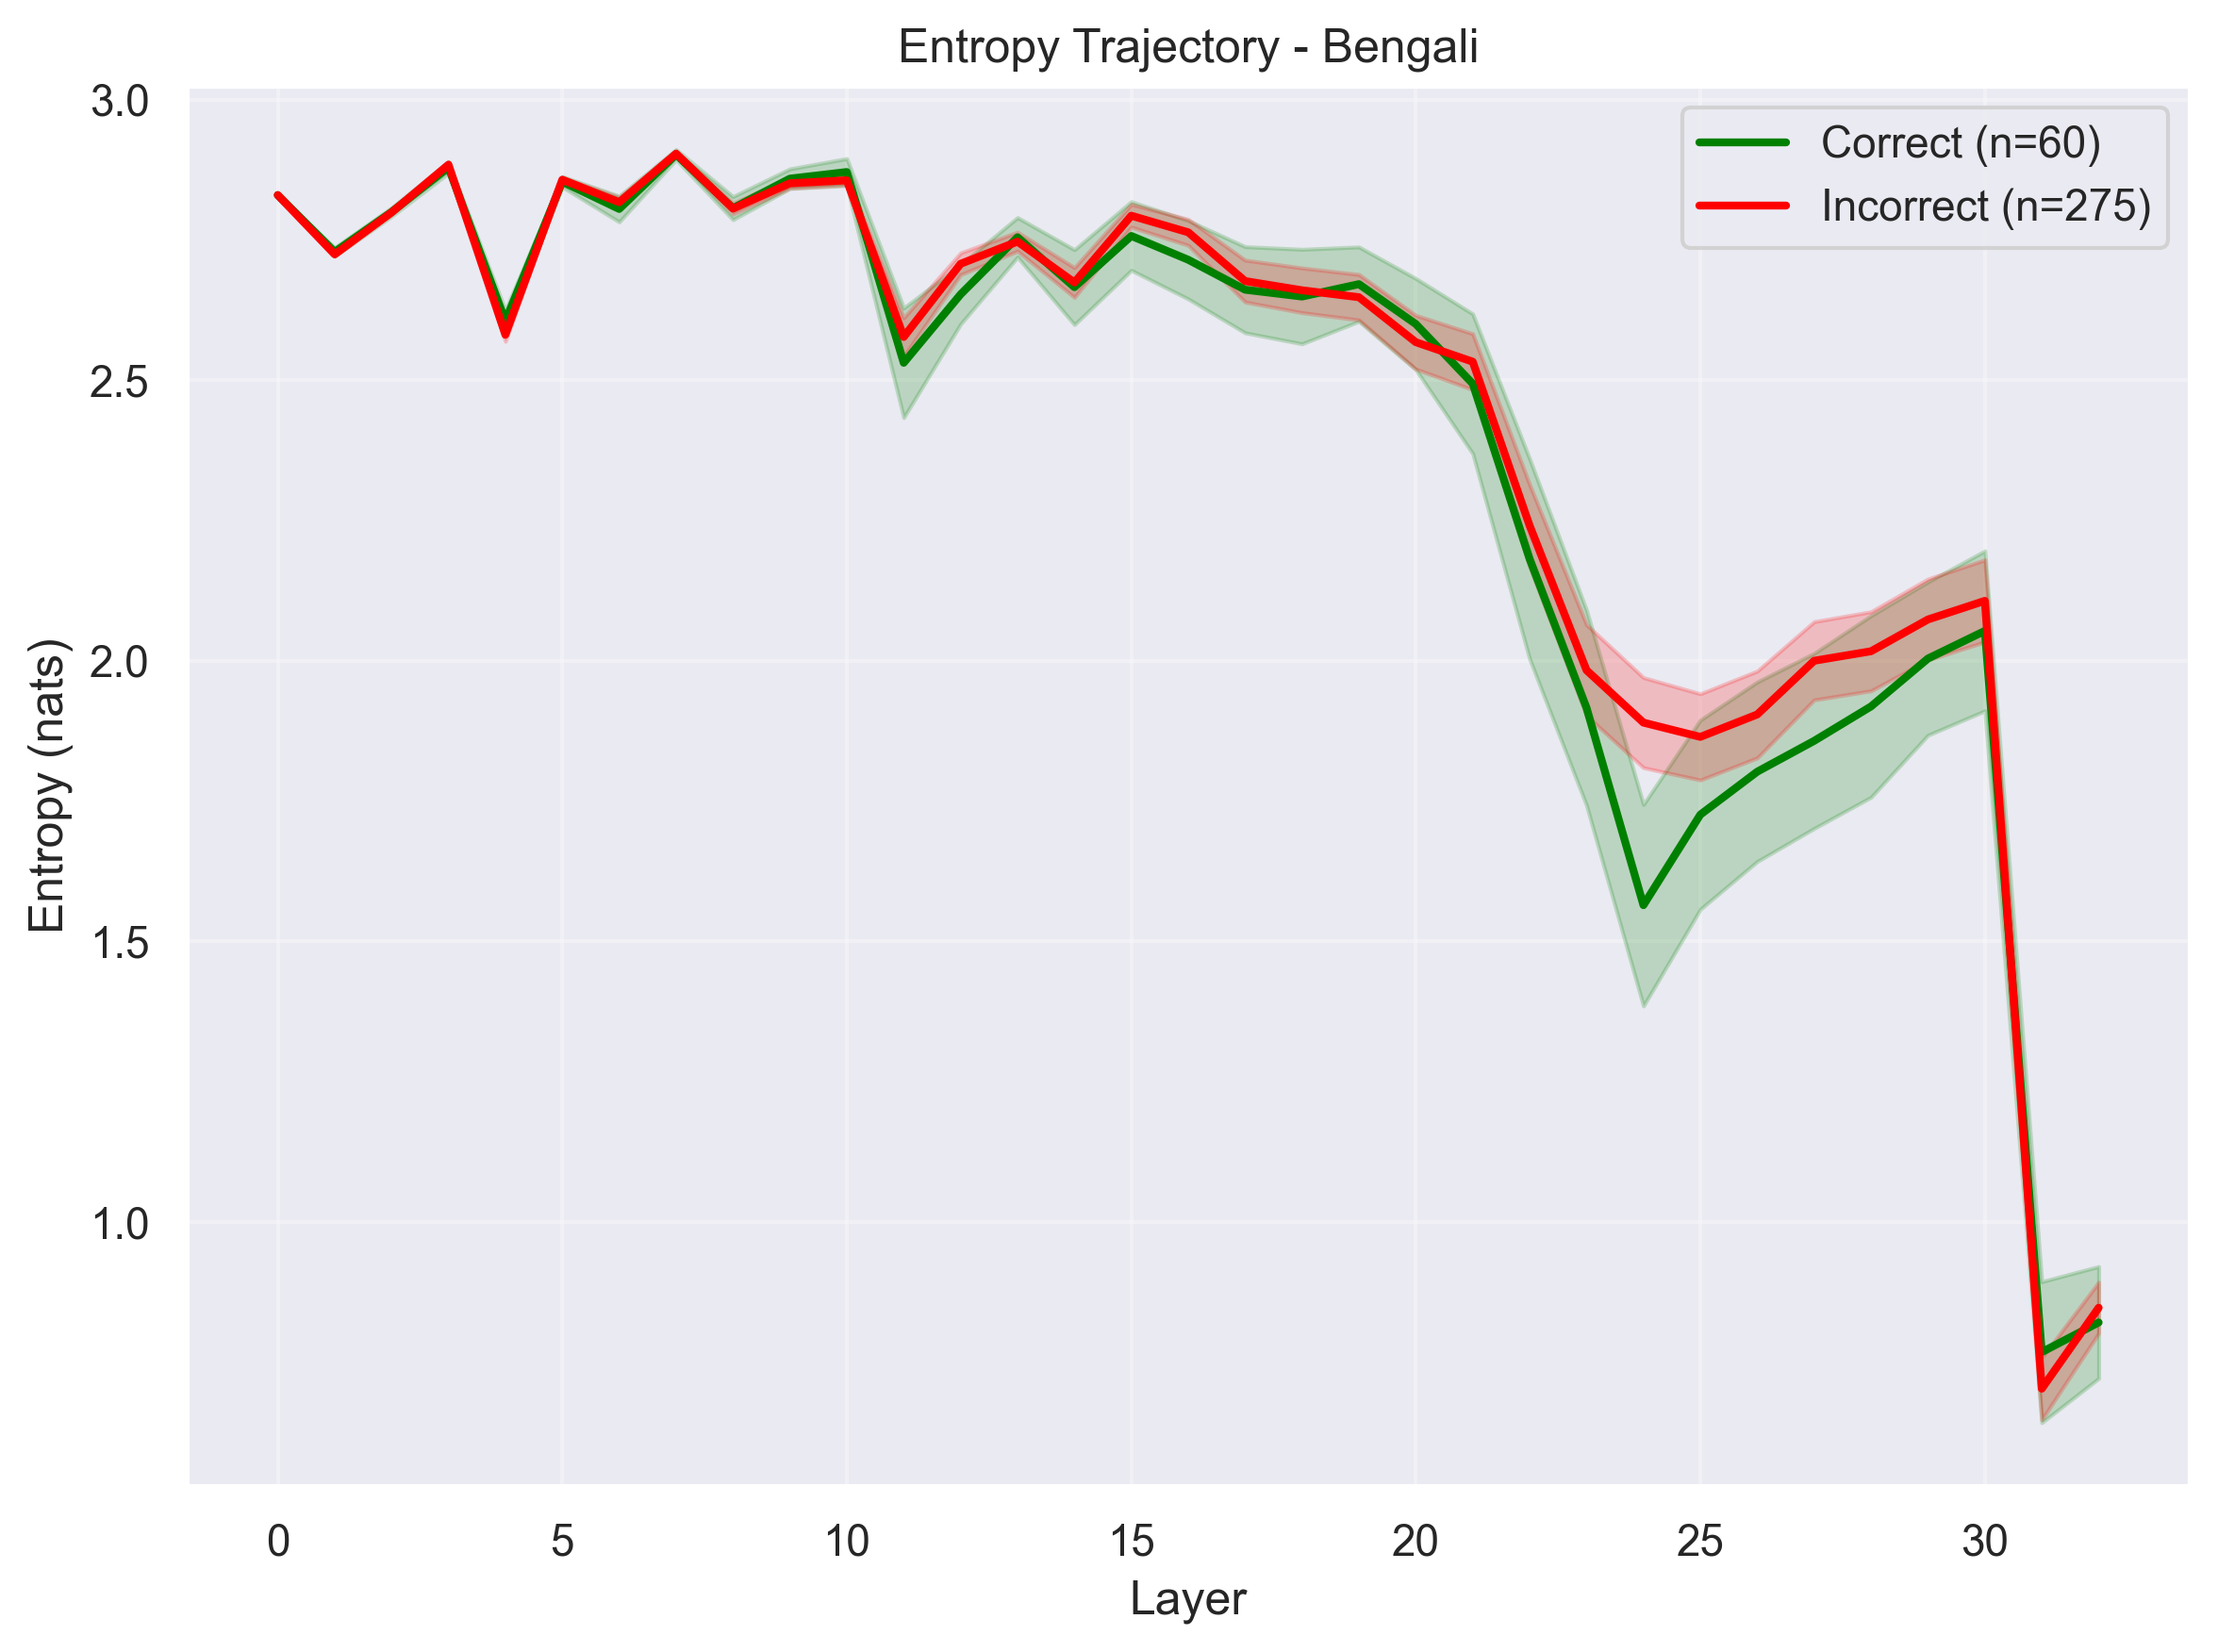

Processing english...
Saved plot: figures/entropy_trajectory_english.png


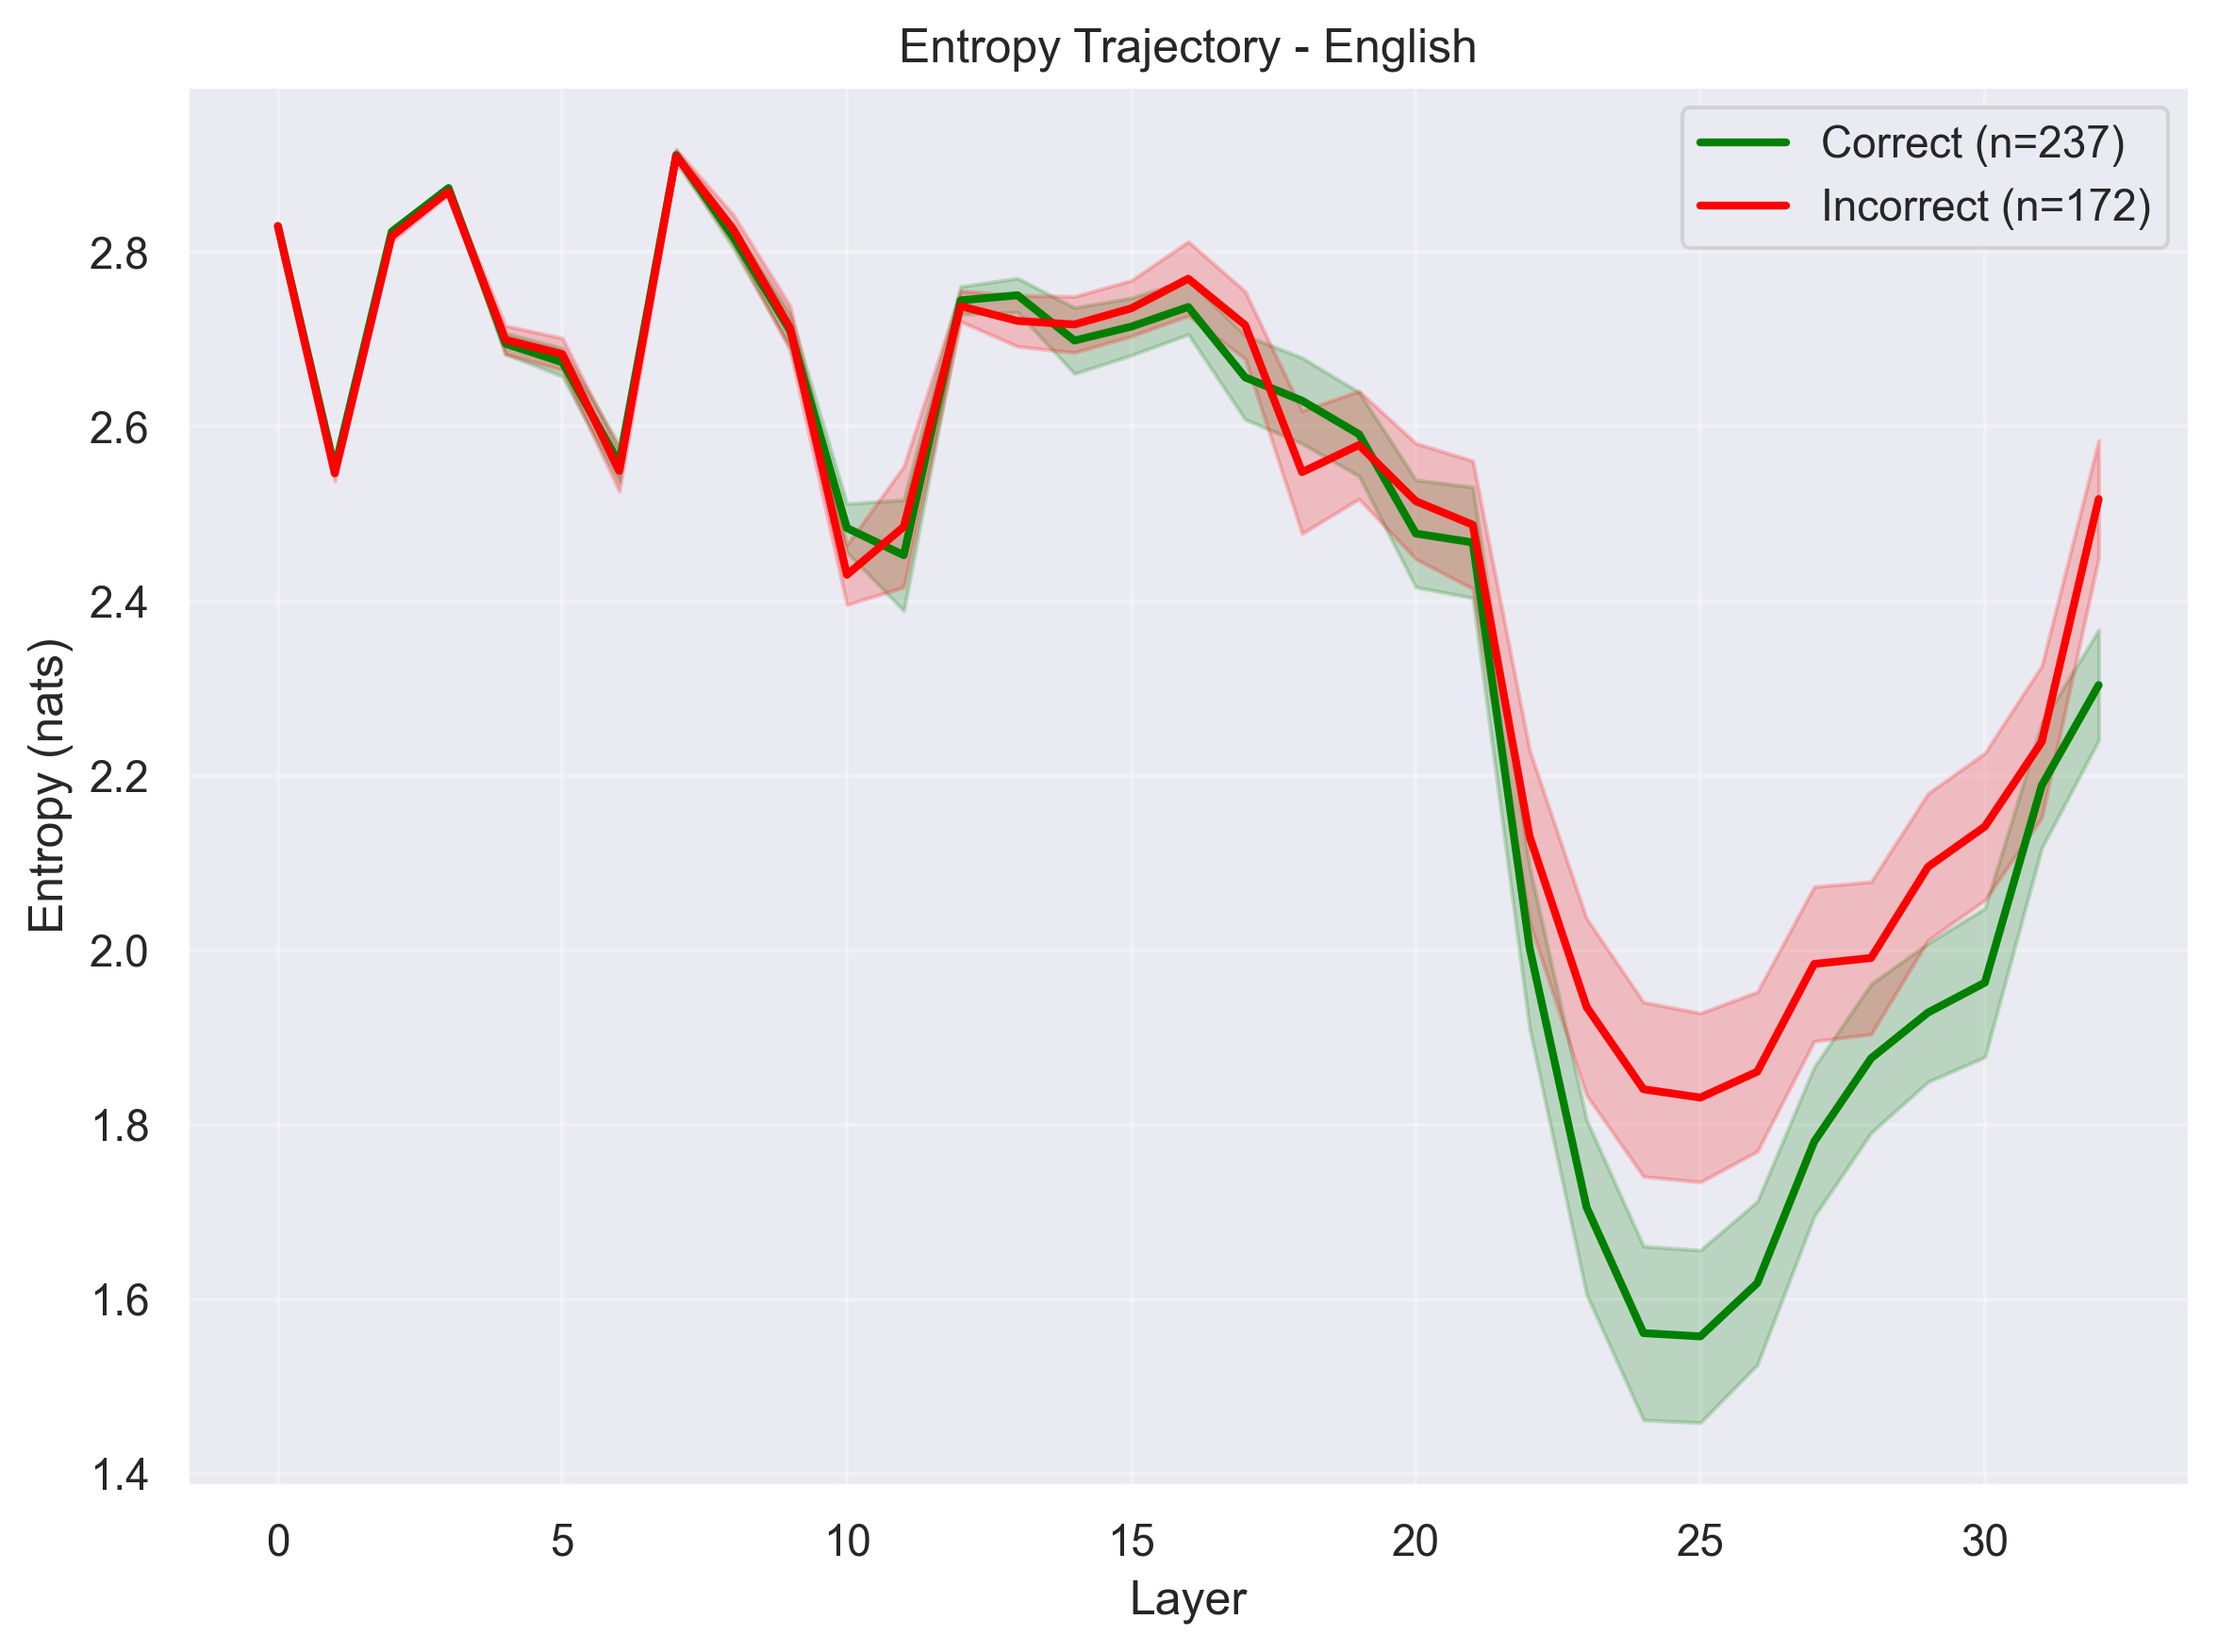

Processing spanish...
Saved plot: figures/entropy_trajectory_spanish.png


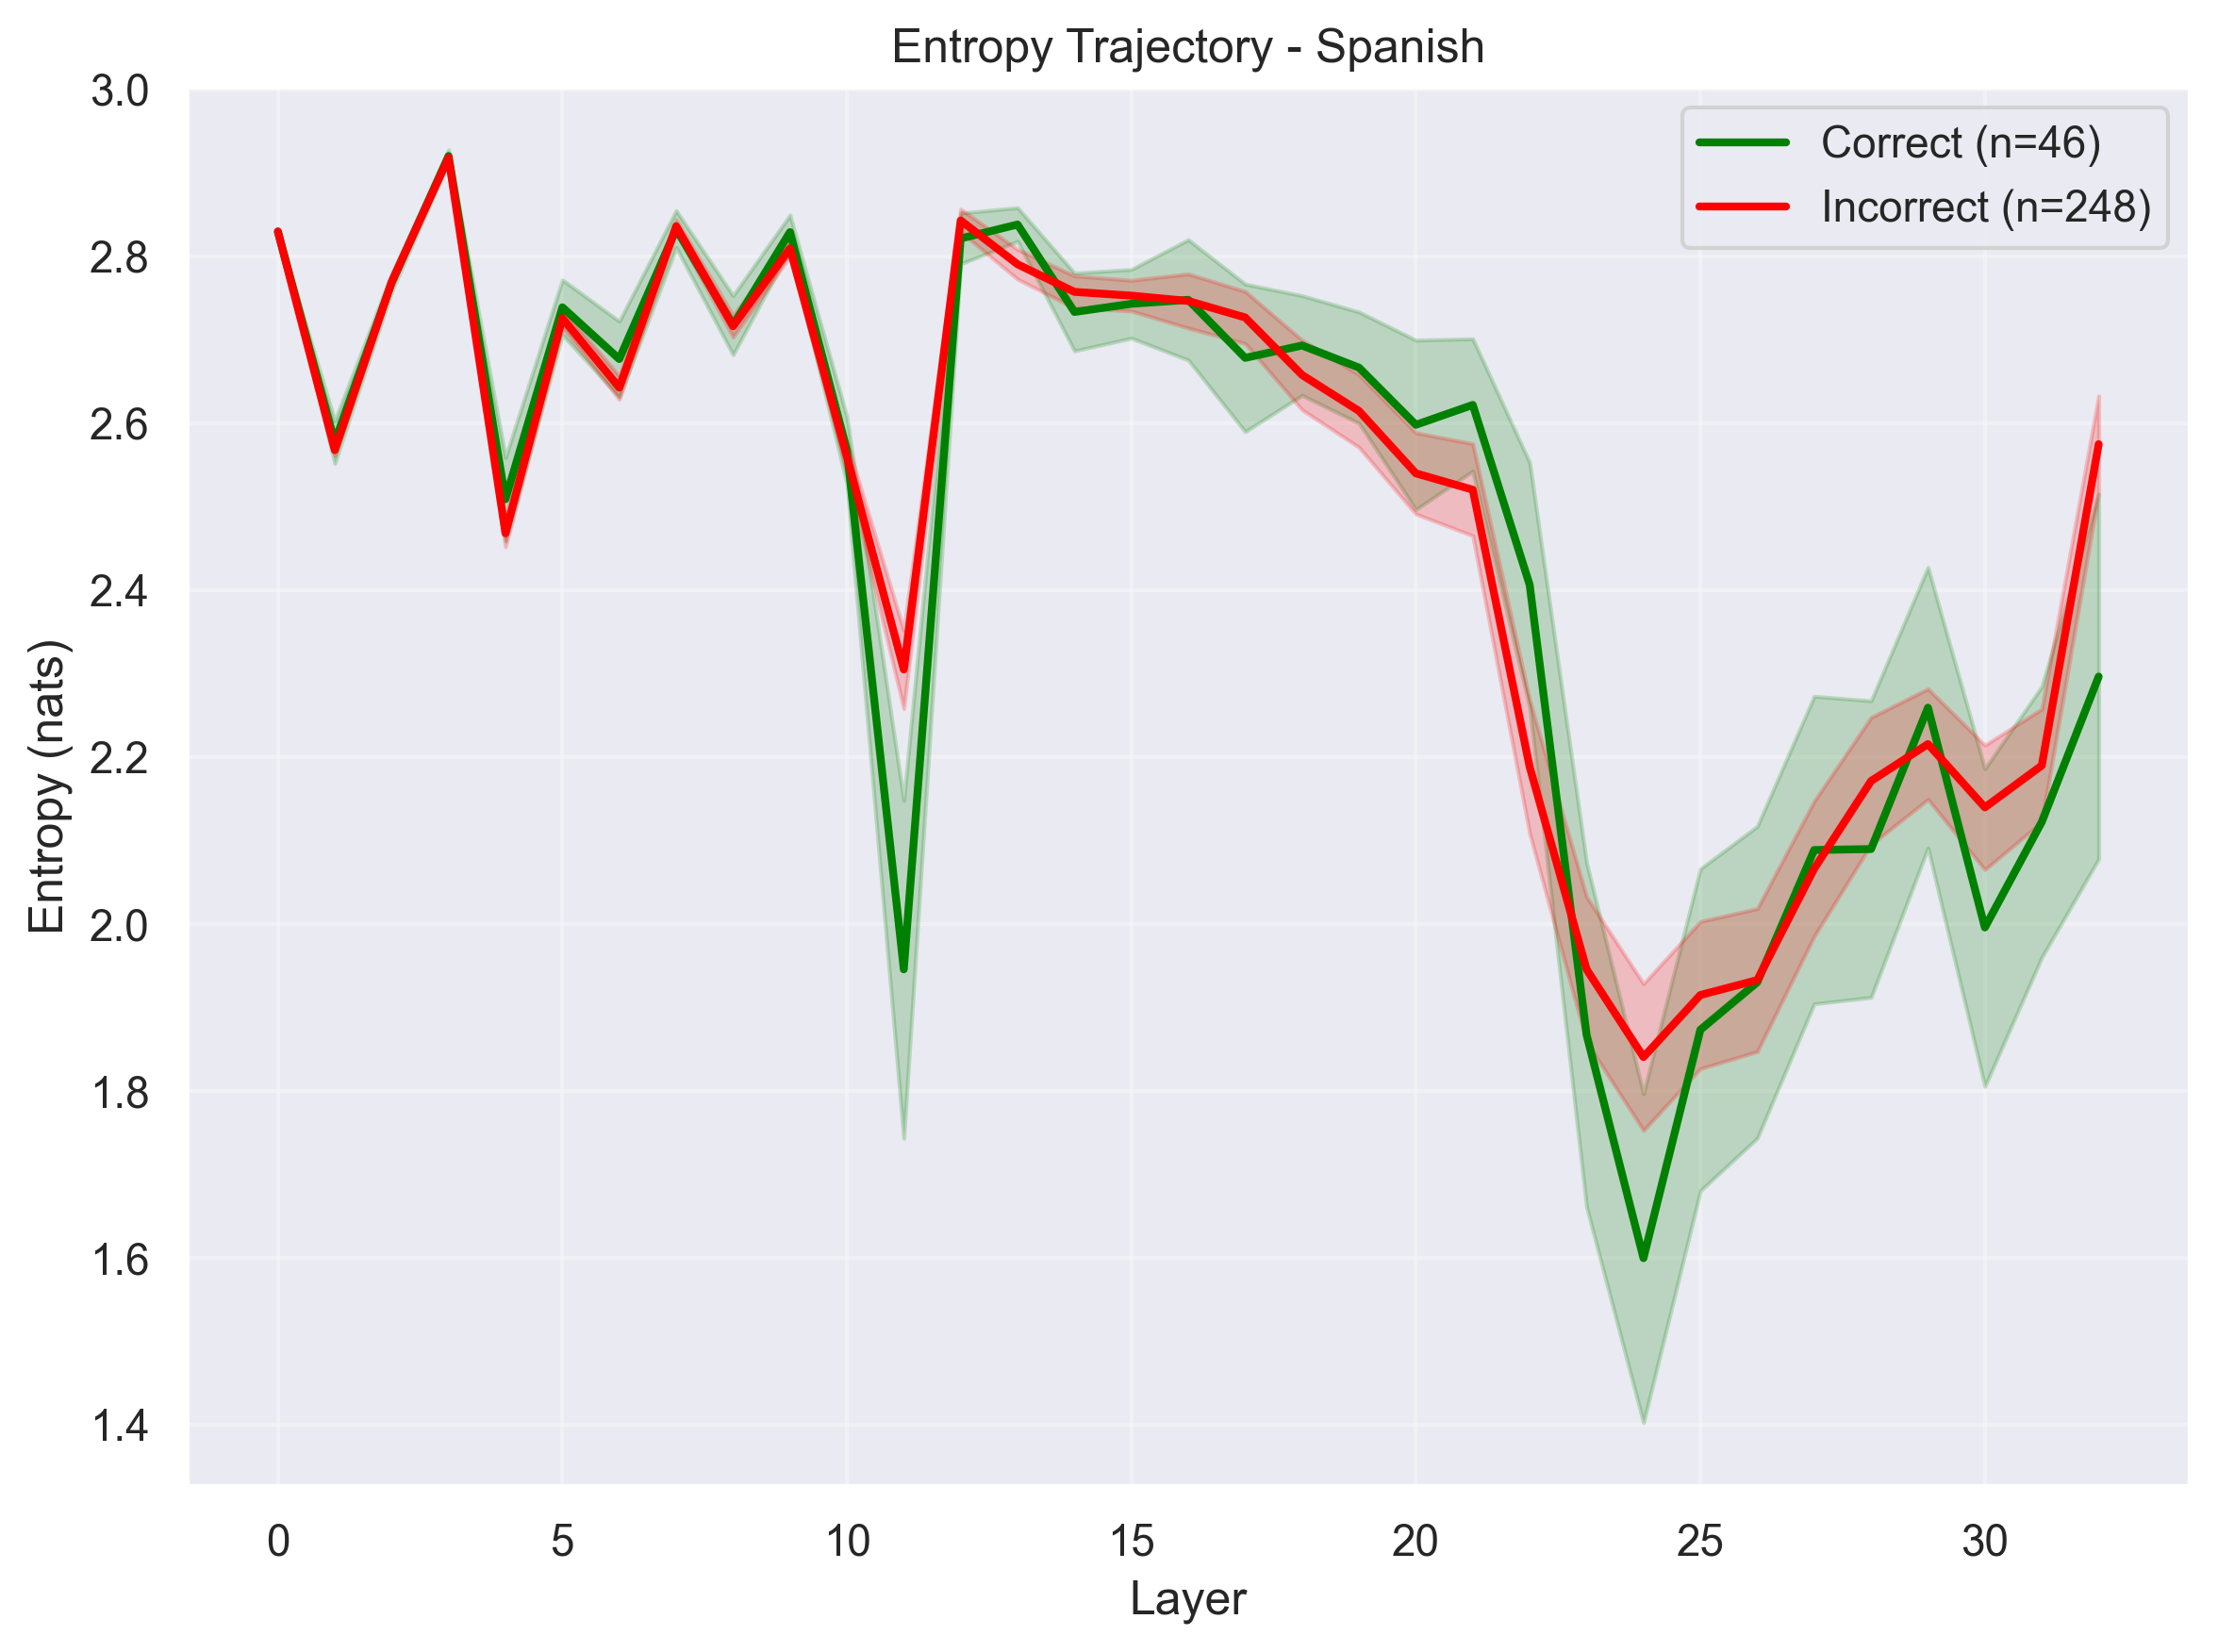

Processing assamese...
Saved plot: figures/entropy_trajectory_assamese.png


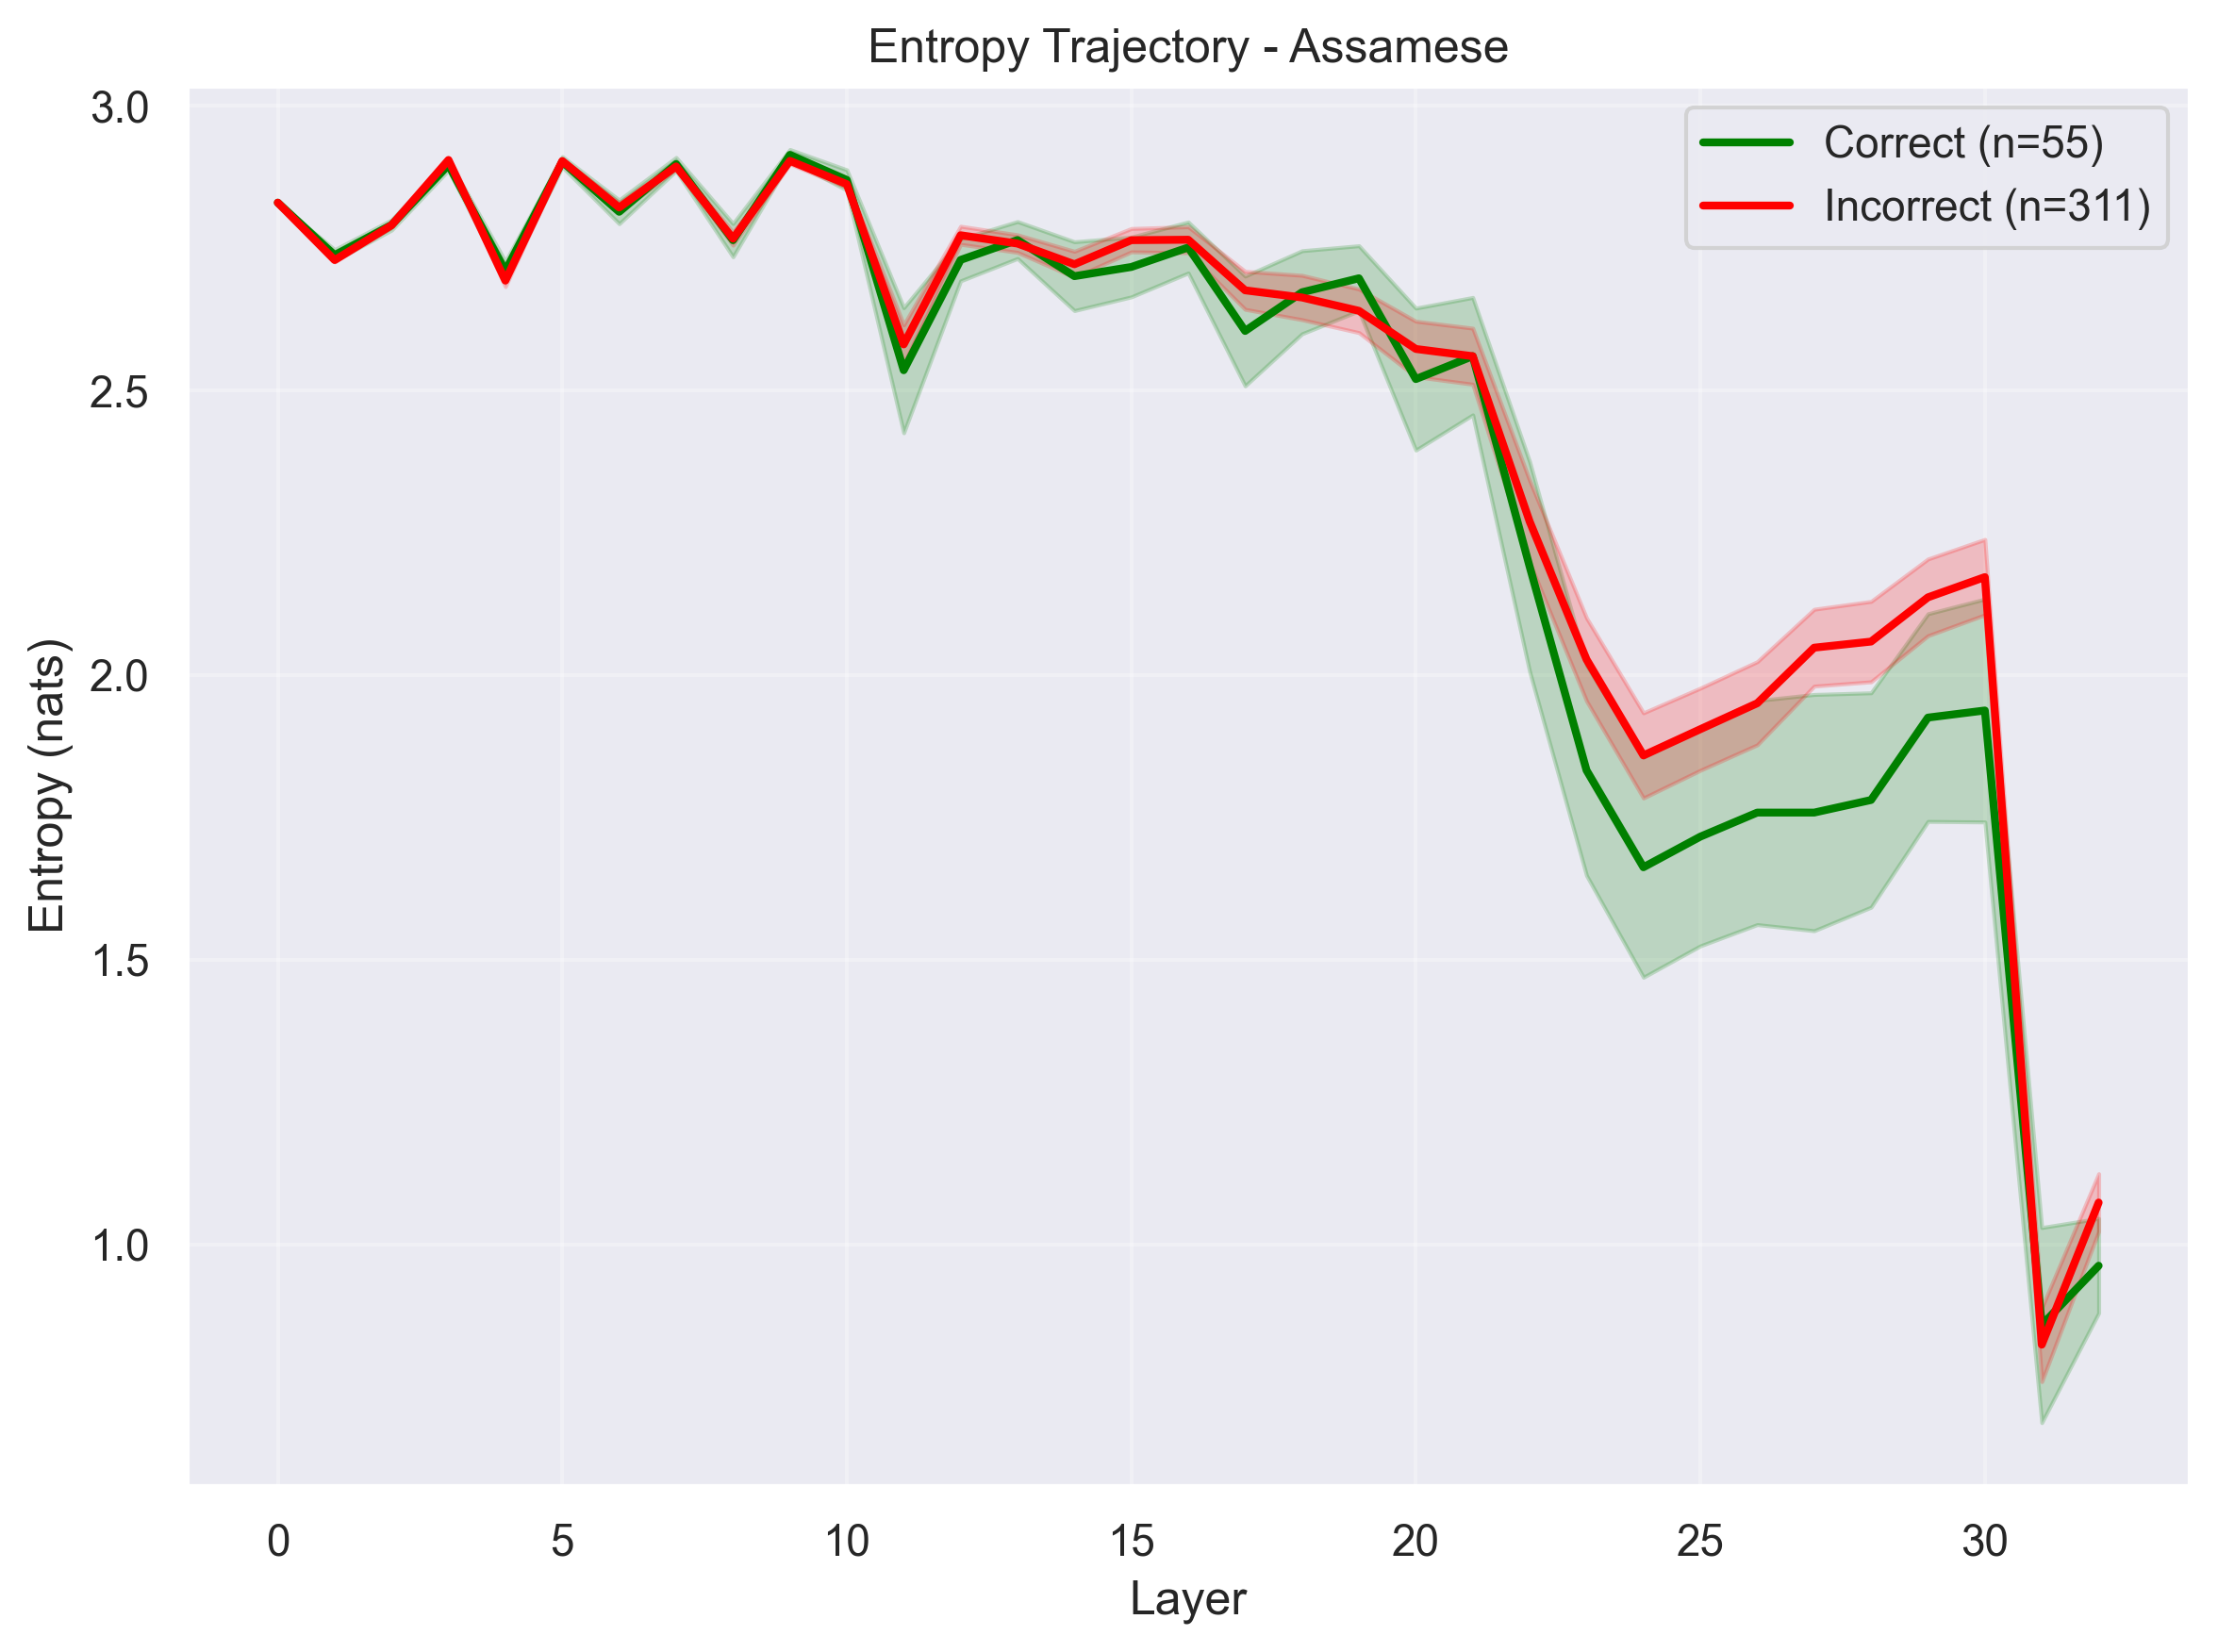

In [9]:
def compute_entropy(distribution: Dict[int, float]) -> float:
    """
    Compute Shannon entropy of a probability distribution.
    H(P) = -sum_i P(i) * log(P(i))
    """
    if not distribution:
        return np.nan
    
    entropy = 0.0
    epsilon = 1e-10
    
    for token_id, prob in distribution.items():
        if prob > epsilon:
            entropy -= prob * np.log(prob)
    
    return entropy


def compute_entropy_trajectory(logit_lens_data: List[Dict]) -> np.ndarray:
    """
    Compute entropy at each layer.
    Returns array of entropies for all layers.
    """
    if not logit_lens_data or len(logit_lens_data) == 0:
        return np.array([])
    
    entropy_trajectory = []
    
    for layer_data in logit_lens_data:
        layer_dist = get_layer_distribution(layer_data)
        entropy = compute_entropy(layer_dist)
        entropy_trajectory.append(entropy)
    
    return np.array(entropy_trajectory)


def collect_entropy_trajectories_by_state(df_classified: pd.DataFrame, df_lens: pd.DataFrame) -> Dict[str, List[np.ndarray]]:
    """Collect entropy trajectories grouped by answer state."""
    trajectories = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        # Skip UNDETERMINED
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        # Get entropy trajectory
        entropy_traj = compute_entropy_trajectory(logit_lens)
        
        if len(entropy_traj) > 0 and not np.any(np.isnan(entropy_traj)):
            trajectories[state].append(entropy_traj)
    
    return trajectories


def plot_entropy_trajectories(language: str, df_classified: pd.DataFrame):
    """Plot entropy trajectories for correct vs incorrect answers."""
    df_lens = load_lens_data(language)
    
    # Collect entropy trajectories
    trajectories = collect_entropy_trajectories_by_state(df_classified, df_lens)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {State.CORRECT: "green", State.INCORRECT: "red"}
    labels = {State.CORRECT: "Correct", State.INCORRECT: "Incorrect"}
    
    for state in [State.CORRECT, State.INCORRECT]:
        if not trajectories[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(trajectories[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        # Plot mean
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(trajectories[state])})", 
                color=colors[state], linewidth=2)
        
        # Plot confidence interval
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Entropy (nats)")
    ax.set_title(f"Entropy Trajectory - {language.capitalize()}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/entropy_trajectory_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


# Run analysis for all languages
print("Plotting entropy trajectories...\n")

for lang in LANGUAGES:
    print(f"Processing {lang}...")
    df_classified = modified_dfs[lang]
    plot_entropy_trajectories(lang, df_classified)

# Bias exploration

Language  Total  Correct  Incorrect  Undetermined  US_Biased  Correct %  Incorrect %  Undetermined %  US_Biased %
 bengali    409       60        223            74         52  14.669927    54.523227       18.092910    12.713936
 english    409      237        172             0          0  57.946210    42.053790        0.000000     0.000000
 spanish    409       46        181           115         67  11.246944    44.254279       28.117359    16.381418
assamese    409       55        266            43         45  13.447433    65.036675       10.513447    11.002445
Plotting trajectories with US bias analysis for Bengali...

Plotting loglikelihood...
Saved plot: figures/loglikelihood_trajectory_bengali_us_bias.png


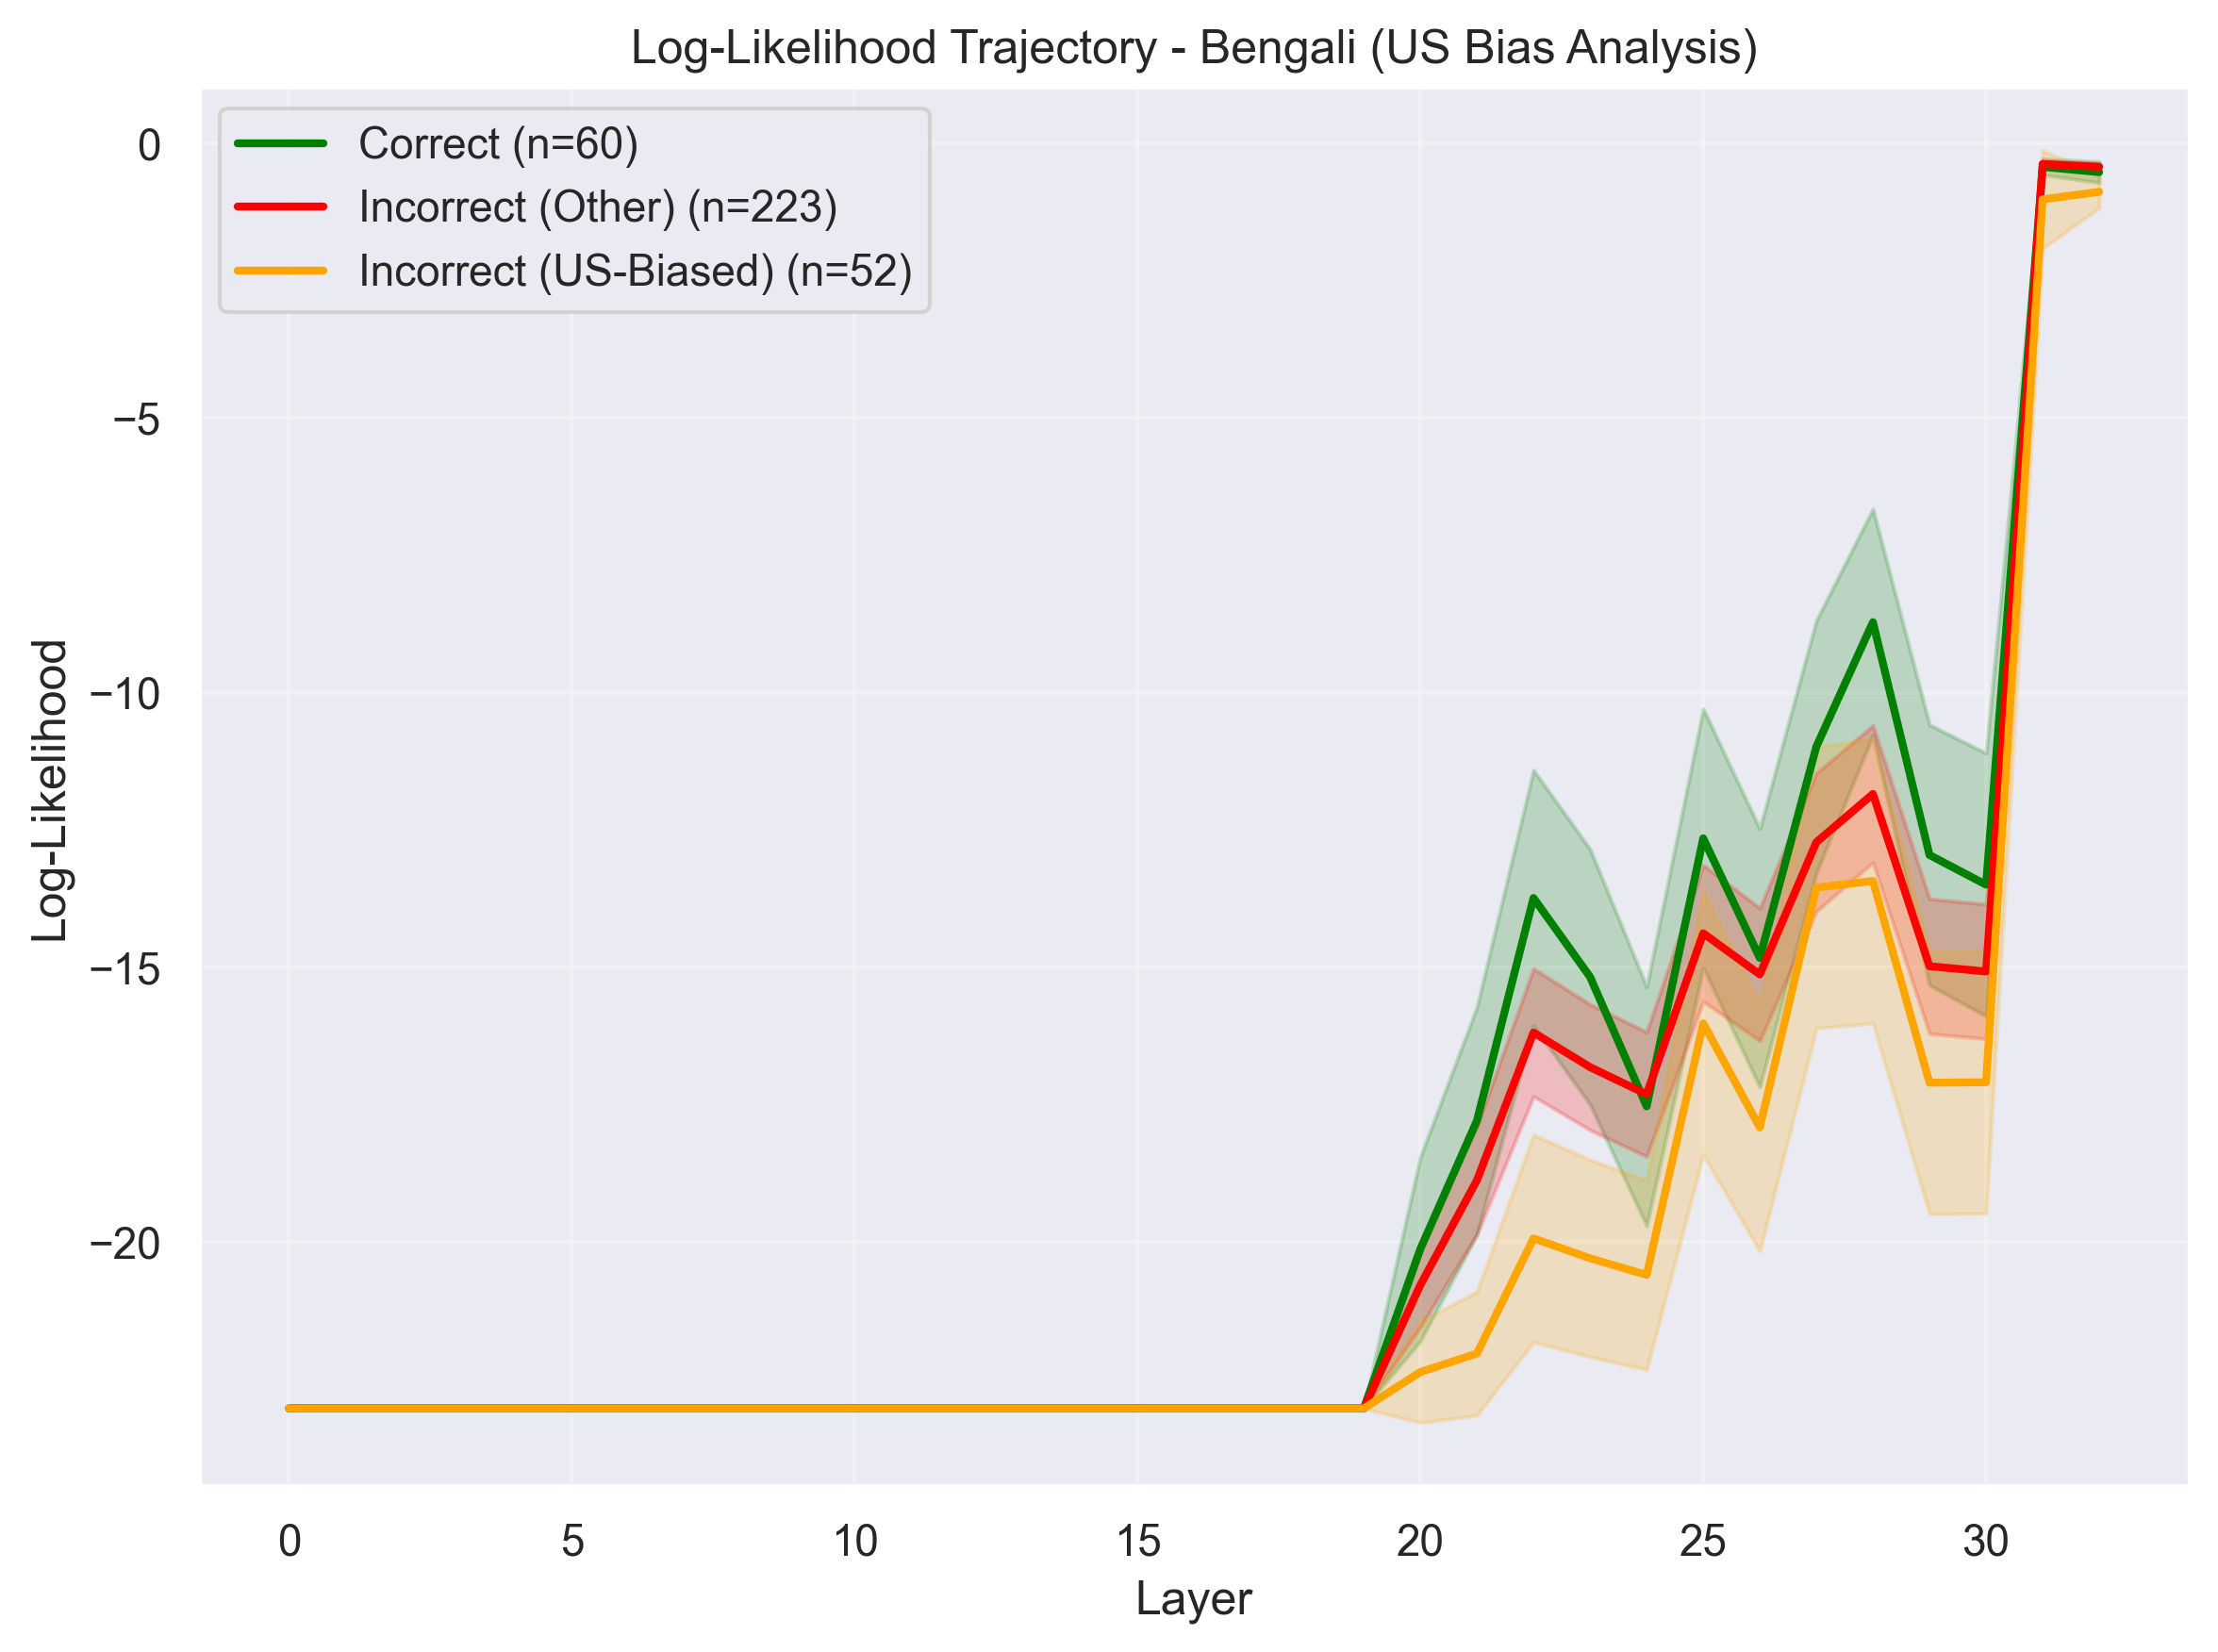


Plotting kl_divergence...
Saved plot: figures/kl_divergence_trajectory_bengali_us_bias.png


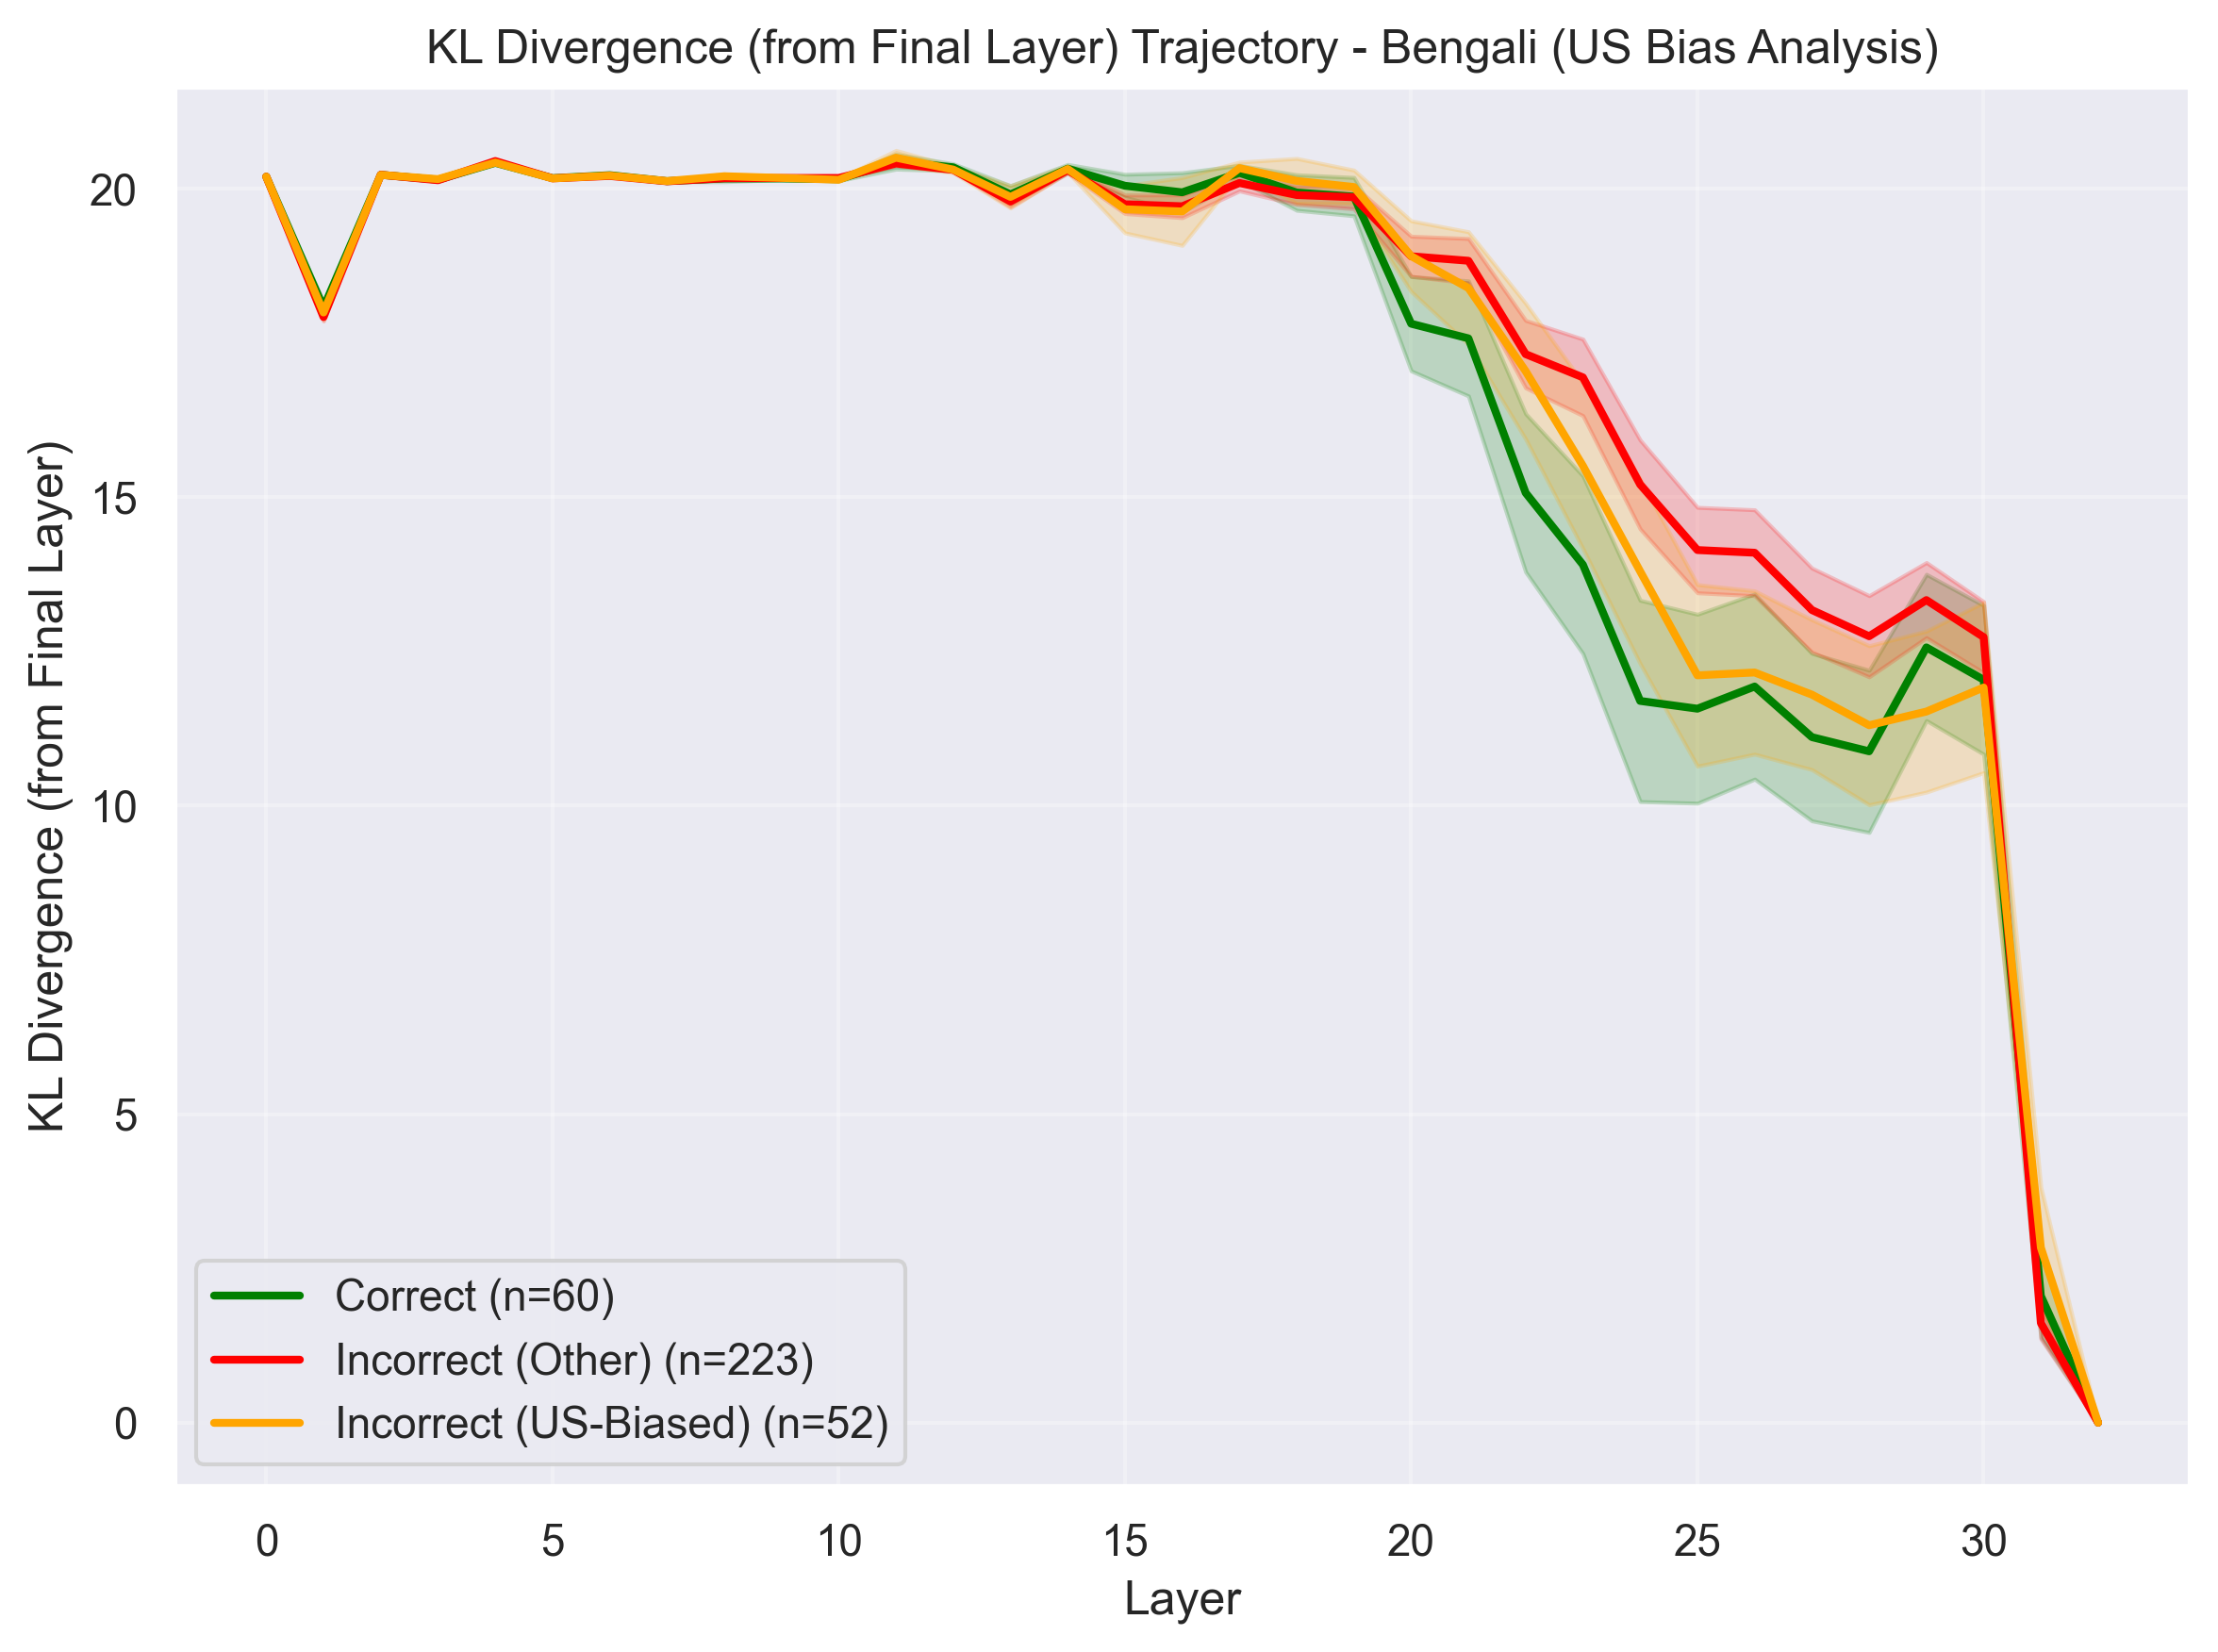


Plotting entropy...
Saved plot: figures/entropy_trajectory_bengali_us_bias.png


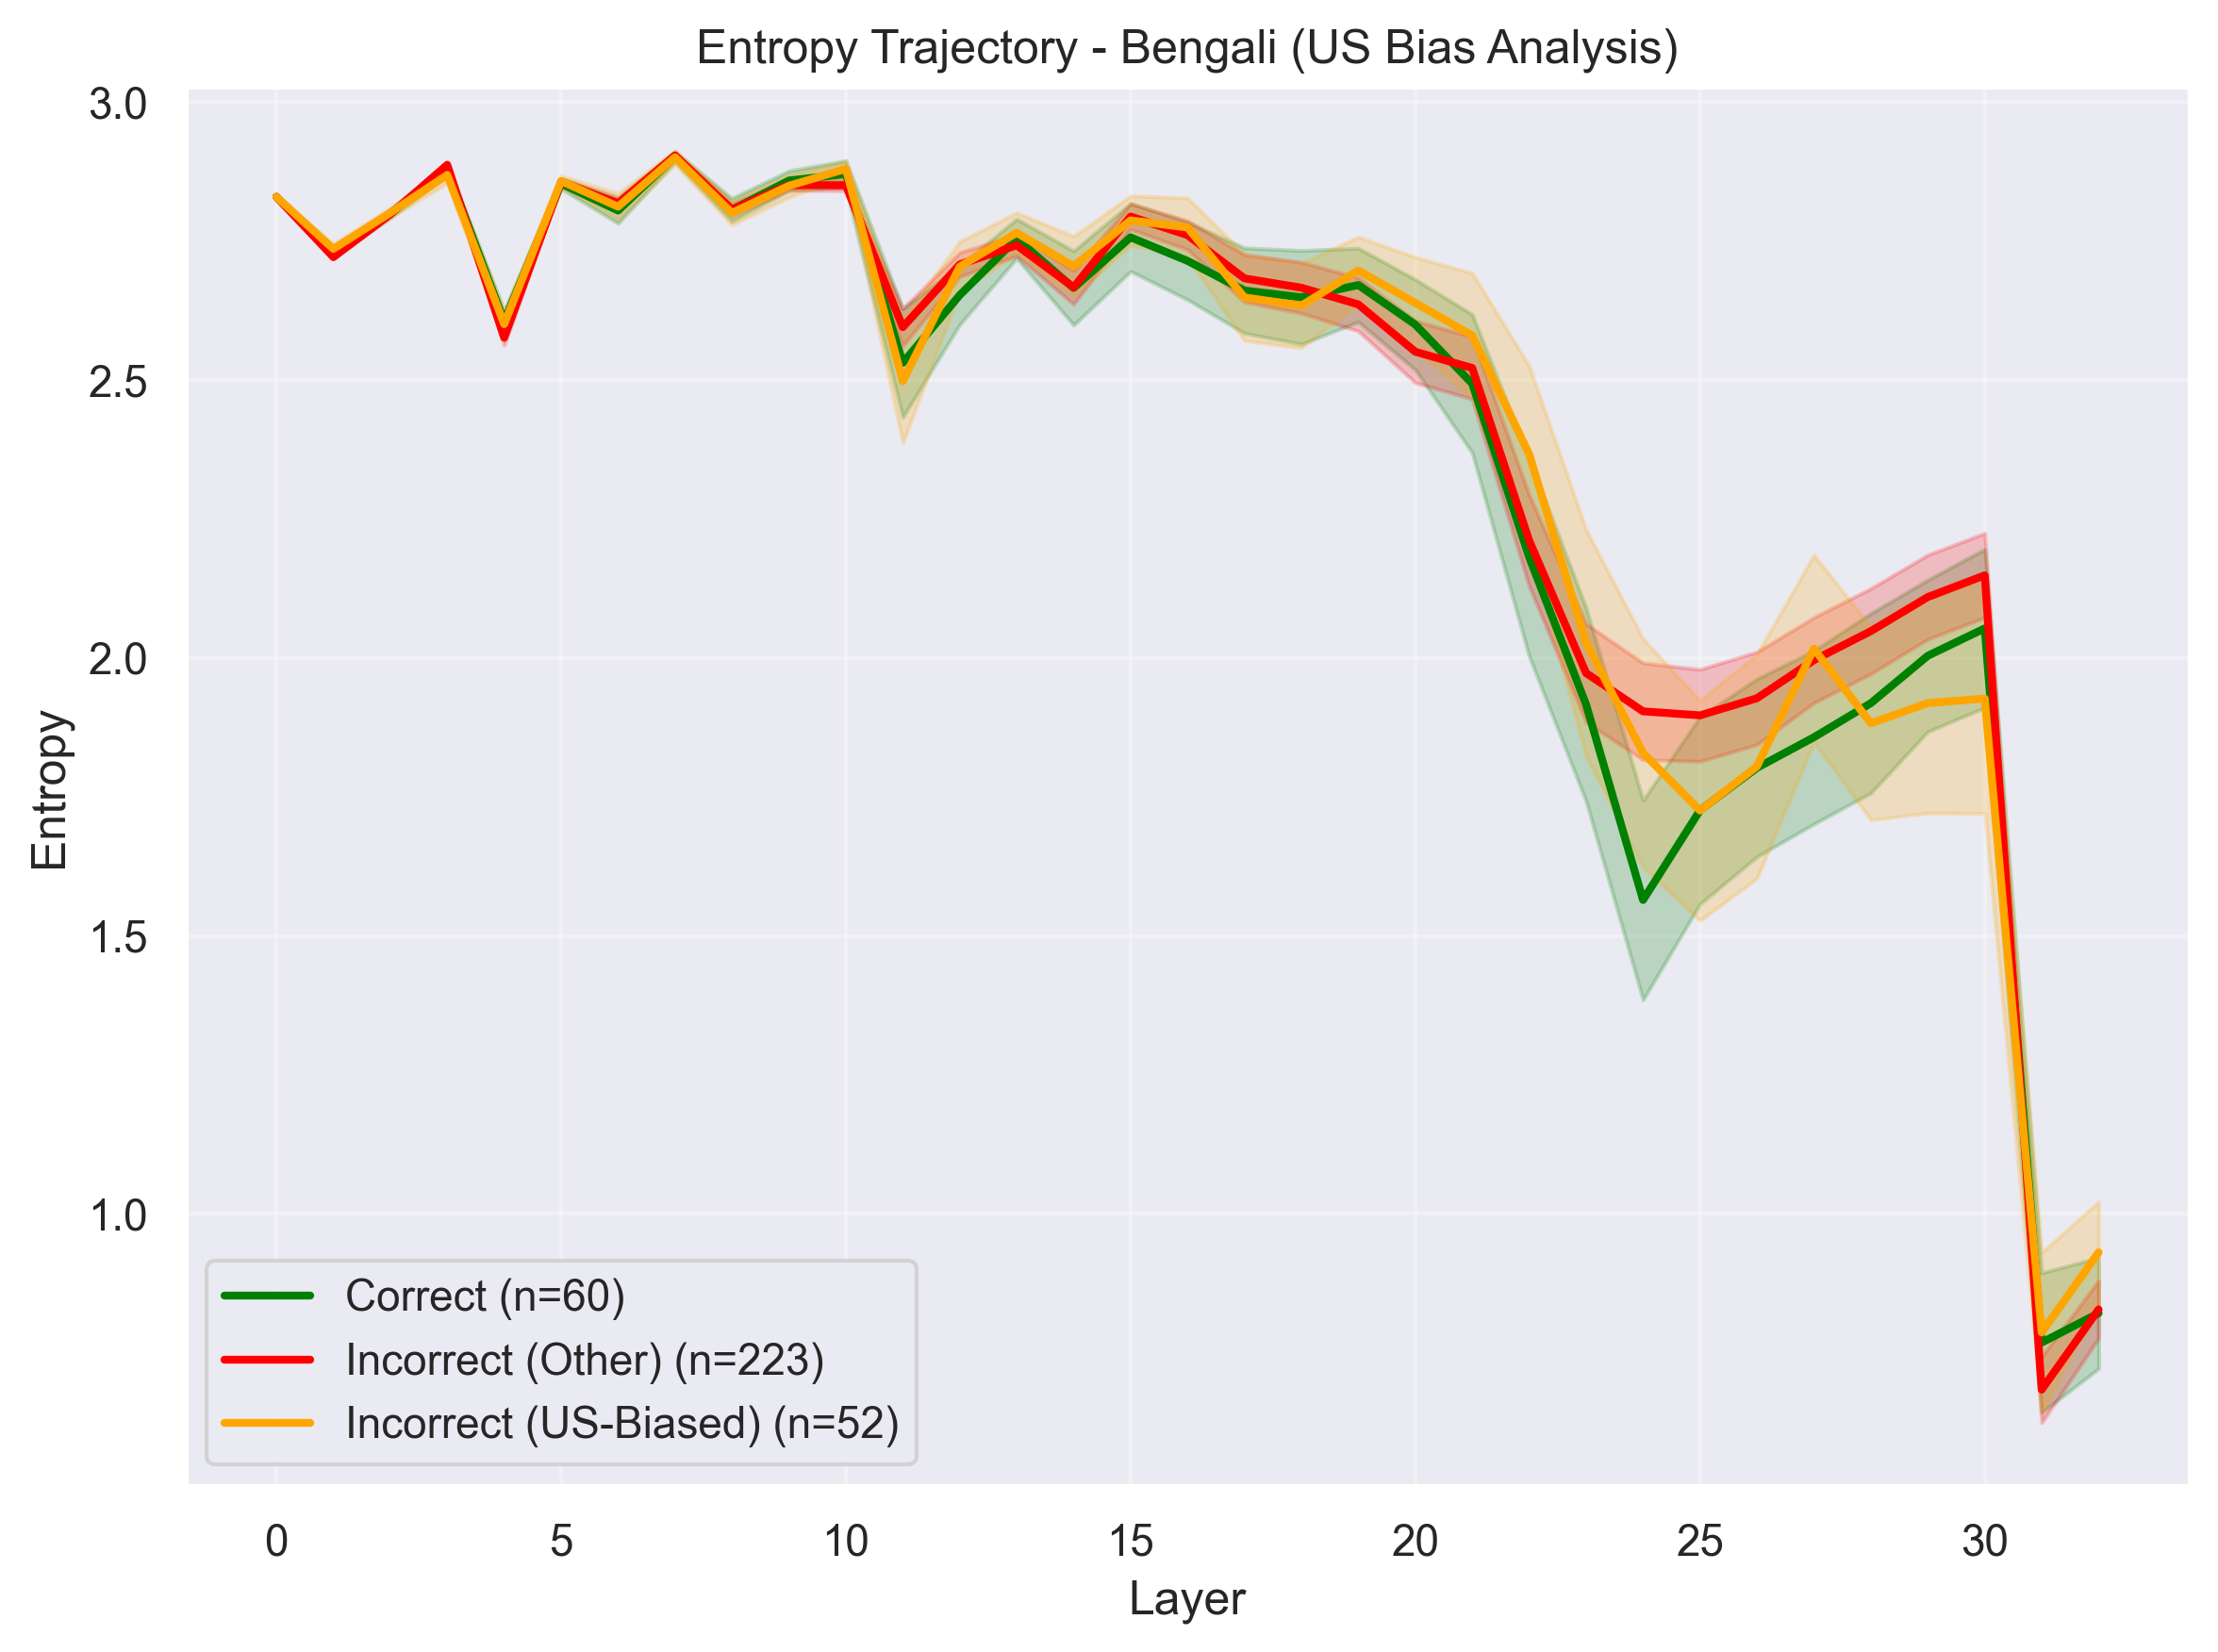

In [27]:
def plot_trajectories_with_us_bias(language: str, df_classified: pd.DataFrame, 
                                    metric: str = "loglikelihood"):
    df_lens = load_lens_data(language)
    
    if metric == "loglikelihood":
        collect_func = collect_trajectories_by_state
        ylabel = "Log-Likelihood"
    elif metric == "kl_divergence":
        collect_func = collect_kl_trajectories_by_state
        ylabel = "KL Divergence (from Final Layer)"
    elif metric == "entropy":
        collect_func = collect_entropy_trajectories_by_state
        ylabel = "Entropy"
    else:
        raise ValueError(f"Unknown metric: {metric}")
    
    trajectories = {
        State.CORRECT: [],
        State.INCORRECT: [],
        State.US_BIASED: []
    }
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        # Compute trajectory based on metric
        if metric == "loglikelihood":
            final_token_id = extract_final_token_id(logit_lens)
            if final_token_id is None:
                continue
            traj = get_token_logprob_trajectory(logit_lens, final_token_id)
        elif metric == "kl_divergence":
            traj = compute_kl_trajectory(logit_lens)
        elif metric == "entropy":
            traj = compute_entropy_trajectory(logit_lens)
        
        if len(traj) > 0 and not np.any(np.isnan(traj)):
            trajectories[state].append(traj)
    
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {
        State.CORRECT: "green",
        State.INCORRECT: "red",
        State.US_BIASED: "orange"
    }
    labels = {
        State.CORRECT: "Correct",
        State.INCORRECT: "Incorrect (Other)",
        State.US_BIASED: "Incorrect (US-Biased)"
    }
    
    for state in [State.CORRECT, State.INCORRECT, State.US_BIASED]:
        if not trajectories[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(trajectories[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(trajectories[state])})", 
                color=colors[state], linewidth=2)
        
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} Trajectory - {language.capitalize()} (US Bias Analysis)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/{metric}_trajectory_{language}_us_bias.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


stats_df_bias, modified_dfs_bias = compute_statistics_with_bias(LANGUAGES)
print(stats_df_bias.to_string(index=False))

print("Plotting trajectories with US bias analysis for Bengali...")
for metric in ["loglikelihood", "kl_divergence", "entropy"]:
    print(f"\nPlotting {metric}...")
    plot_trajectories_with_us_bias("bengali", modified_dfs_bias["bengali"], metric=metric)

# Answer Emergence exploration

In [33]:
def count_answer_appearances_in_layer(layer_predictions: List[Dict], 
                                      expected_answers: List[str], 
                                      language: str = "english") -> int:
    if not layer_predictions or not expected_answers:
        return 0
    
    predicted_tokens = set()
    for pred in layer_predictions:
        token = pred.get("token", "").strip()
        if token:
            token_norm = normalize_answer(token, language)
            if token_norm: 
                predicted_tokens.add(token_norm)
    
    count = 0
    for expected in expected_answers:
        expected_norm = normalize_answer(expected, language)
        
        if expected_norm in predicted_tokens:
            count += 1
    
    return count


def track_answer_emergence(logit_lens_data: List[Dict], 
                           expected_answers: List[str],
                           language: str = "english",
                           threshold: int = 1) -> Optional[int]:
    if not logit_lens_data or not expected_answers:
        return None
    
    for layer_data in logit_lens_data:
        layer_num = layer_data.get("layer")
        predictions = layer_data.get("predictions", [])
        
        count = count_answer_appearances_in_layer(predictions, expected_answers, language)
        
        if count >= threshold:
            return layer_num
    
    return None  # Threshold never met


def collect_emergence_data(df_classified: pd.DataFrame, 
                           df_lens: pd.DataFrame,
                           language: str,
                           answer_type: str = "bengali") -> Dict[str, Dict[int, List[int]]]:

    emergence_data = {
        State.CORRECT: {1: [], 2: [], 3: []},
        State.INCORRECT: {1: [], 2: [], 3: []},
        State.US_BIASED: {1: [], 2: [], 3: []}
    }
    
    df_eng = load_language_data("english", translated=False)
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        if answer_type == "bengali":
            expected_answers = df_classified.loc[idx, "TranslatedAnswerList"]
            check_language = "english"  # Translated answers are in English
        else:  # "us"
            if idx not in df_eng.index:
                continue
            expected_answers = df_eng.loc[idx, "Answer"]
            check_language = "english"
        
        if not expected_answers:
            continue
        
        for threshold in [1]:
            layer = track_answer_emergence(logit_lens, expected_answers, check_language, threshold)
            if layer is not None:
                emergence_data[state][threshold].append(layer)
    
    return emergence_data


def plot_emergence_distributions(language: str, df_classified: pd.DataFrame):
    df_lens = load_lens_data(language)
    
    # Collect data for both answer types
    bengali_data = collect_emergence_data(df_classified, df_lens, language, "bengali")
    us_data = collect_emergence_data(df_classified, df_lens, language, "us")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 7))
    
    states = [State.CORRECT, State.INCORRECT, State.US_BIASED]
    state_labels = ["Correct", "Incorrect (Other)", "Incorrect (US-Biased)"]
    colors = {"correct": "green", "incorrect": "red", "us_biased": "orange"}
    
    answer_types = [
        ("bengali", "Bengali Answers", bengali_data),
        ("us", "US English Answers", us_data)
    ]
    
    row = 0
    for answer_type, answer_label, data in answer_types:
        for threshold in [1]:
            for col, (state, state_label) in enumerate(zip(states, state_labels)):
                ax = axes[row, col]
                
                layers = data[state][threshold]
                
                if len(layers) > 0:
                    # Create histogram
                    bins = np.arange(0, LAYER_COUNT + 2) - 0.5
                    ax.hist(layers, bins=bins, alpha=0.7, color=colors[state], edgecolor='black')
                    
                    # Add mean and median lines
                    mean_layer = np.mean(layers)
                    median_layer = np.median(layers)
                    ax.axvline(mean_layer, color='darkblue', linestyle='--', linewidth=2, 
                              label=f'Mean: {mean_layer:.1f}')
                    ax.axvline(median_layer, color='purple', linestyle=':', linewidth=2,
                              label=f'Median: {median_layer:.1f}')
                    ax.legend(fontsize=8)
                else:
                    ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                
                # Labels
                ax.set_xlabel('Layer', fontsize=9)
                ax.set_ylabel('Count', fontsize=9)
                ax.set_title(f'{answer_label} (≥{threshold})\n{state_label} (n={len(layers)})', 
                            fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_xlim(-1, LAYER_COUNT + 1)
            
            row += 1
    
    plt.suptitle(f'Answer Emergence Distributions - {language.capitalize()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/emergence_distributions_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


def print_emergence_statistics(language: str, df_classified: pd.DataFrame):
    df_lens = load_lens_data(language)
    
    bengali_data = collect_emergence_data(df_classified, df_lens, language, "bengali")
    us_data = collect_emergence_data(df_classified, df_lens, language, "us")
    
    print(f"\n{'='*80}")
    print(f"Answer Emergence Statistics - {language.capitalize()}")
    print(f"{'='*80}\n")
    
    for answer_type, answer_label, data in [("bengali", "Bengali Answers", bengali_data),
                                             ("us", "US English Answers", us_data)]:
        print(f"\n{answer_label}:")
        print("-" * 80)
        
        for state, state_label in [(State.CORRECT, "Correct"),
                                    (State.INCORRECT, "Incorrect (Other)"),
                                    (State.US_BIASED, "Incorrect (US-Biased)")]:
            print(f"\n  {state_label}:")
            
            for threshold in [1, 2, 3]:
                layers = data[state][threshold]
                
                if len(layers) > 0:
                    mean_layer = np.mean(layers)
                    std_layer = np.std(layers)
                    median_layer = np.median(layers)
                    
                    print(f"    ≥{threshold} answers: n={len(layers)}, "
                          f"mean={mean_layer:.2f}, std={std_layer:.2f}, median={median_layer:.1f}")
                else:
                    print(f"    ≥{threshold} answers: No data")


Saved plot: figures/emergence_distributions_bengali.png


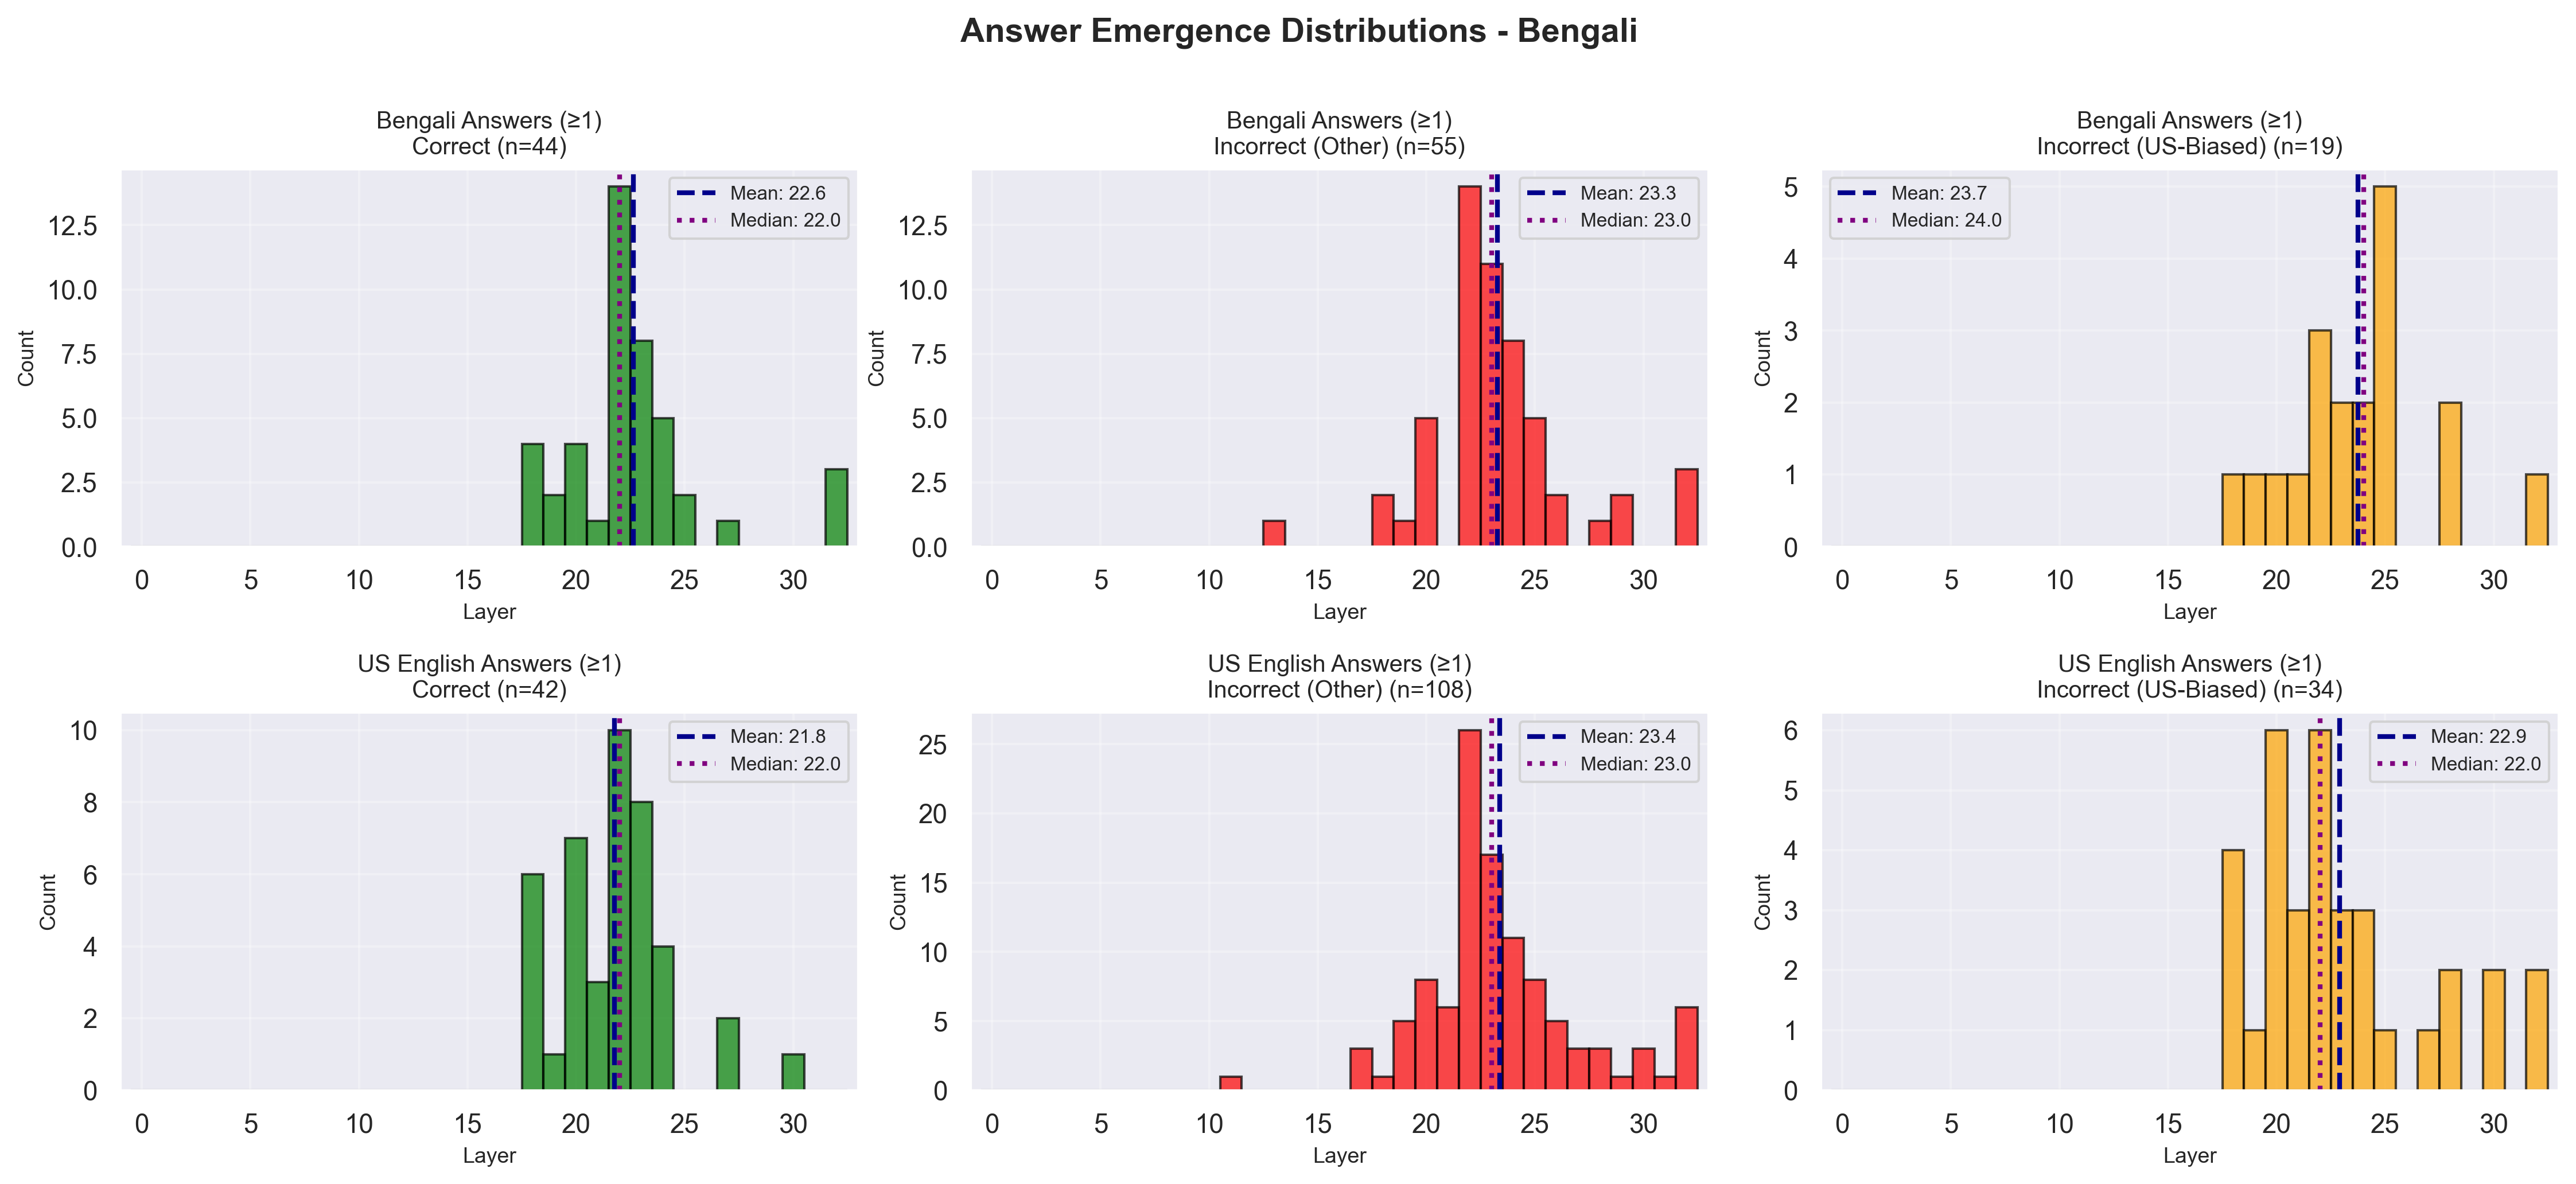

In [34]:
plot_emergence_distributions("bengali", modified_dfs_bias["bengali"])


First Answer Token Emergence Statistics - Bengali


Bengali Answers:
--------------------------------------------------------------------------------

  Correct:
    Total answer tokens found: 78
    Mean first emergence: 23.45
    Std: 3.33
    Median: 23.0
    Range: [18, 32]

  Incorrect (Other):
    Total answer tokens found: 79
    Mean first emergence: 24.00
    Std: 3.62
    Median: 23.0
    Range: [13, 32]

  Incorrect (US-Biased):
    Total answer tokens found: 26
    Mean first emergence: 24.65
    Std: 3.43
    Median: 25.0
    Range: [18, 32]

US English Answers:
--------------------------------------------------------------------------------

  Correct:
    Total answer tokens found: 100
    Mean first emergence: 22.92
    Std: 2.79
    Median: 23.0
    Range: [18, 32]

  Incorrect (Other):
    Total answer tokens found: 189
    Mean first emergence: 23.68
    Std: 3.32
    Median: 23.0
    Range: [11, 32]

  Incorrect (US-Biased):
    Total answer tokens found: 70
    Me

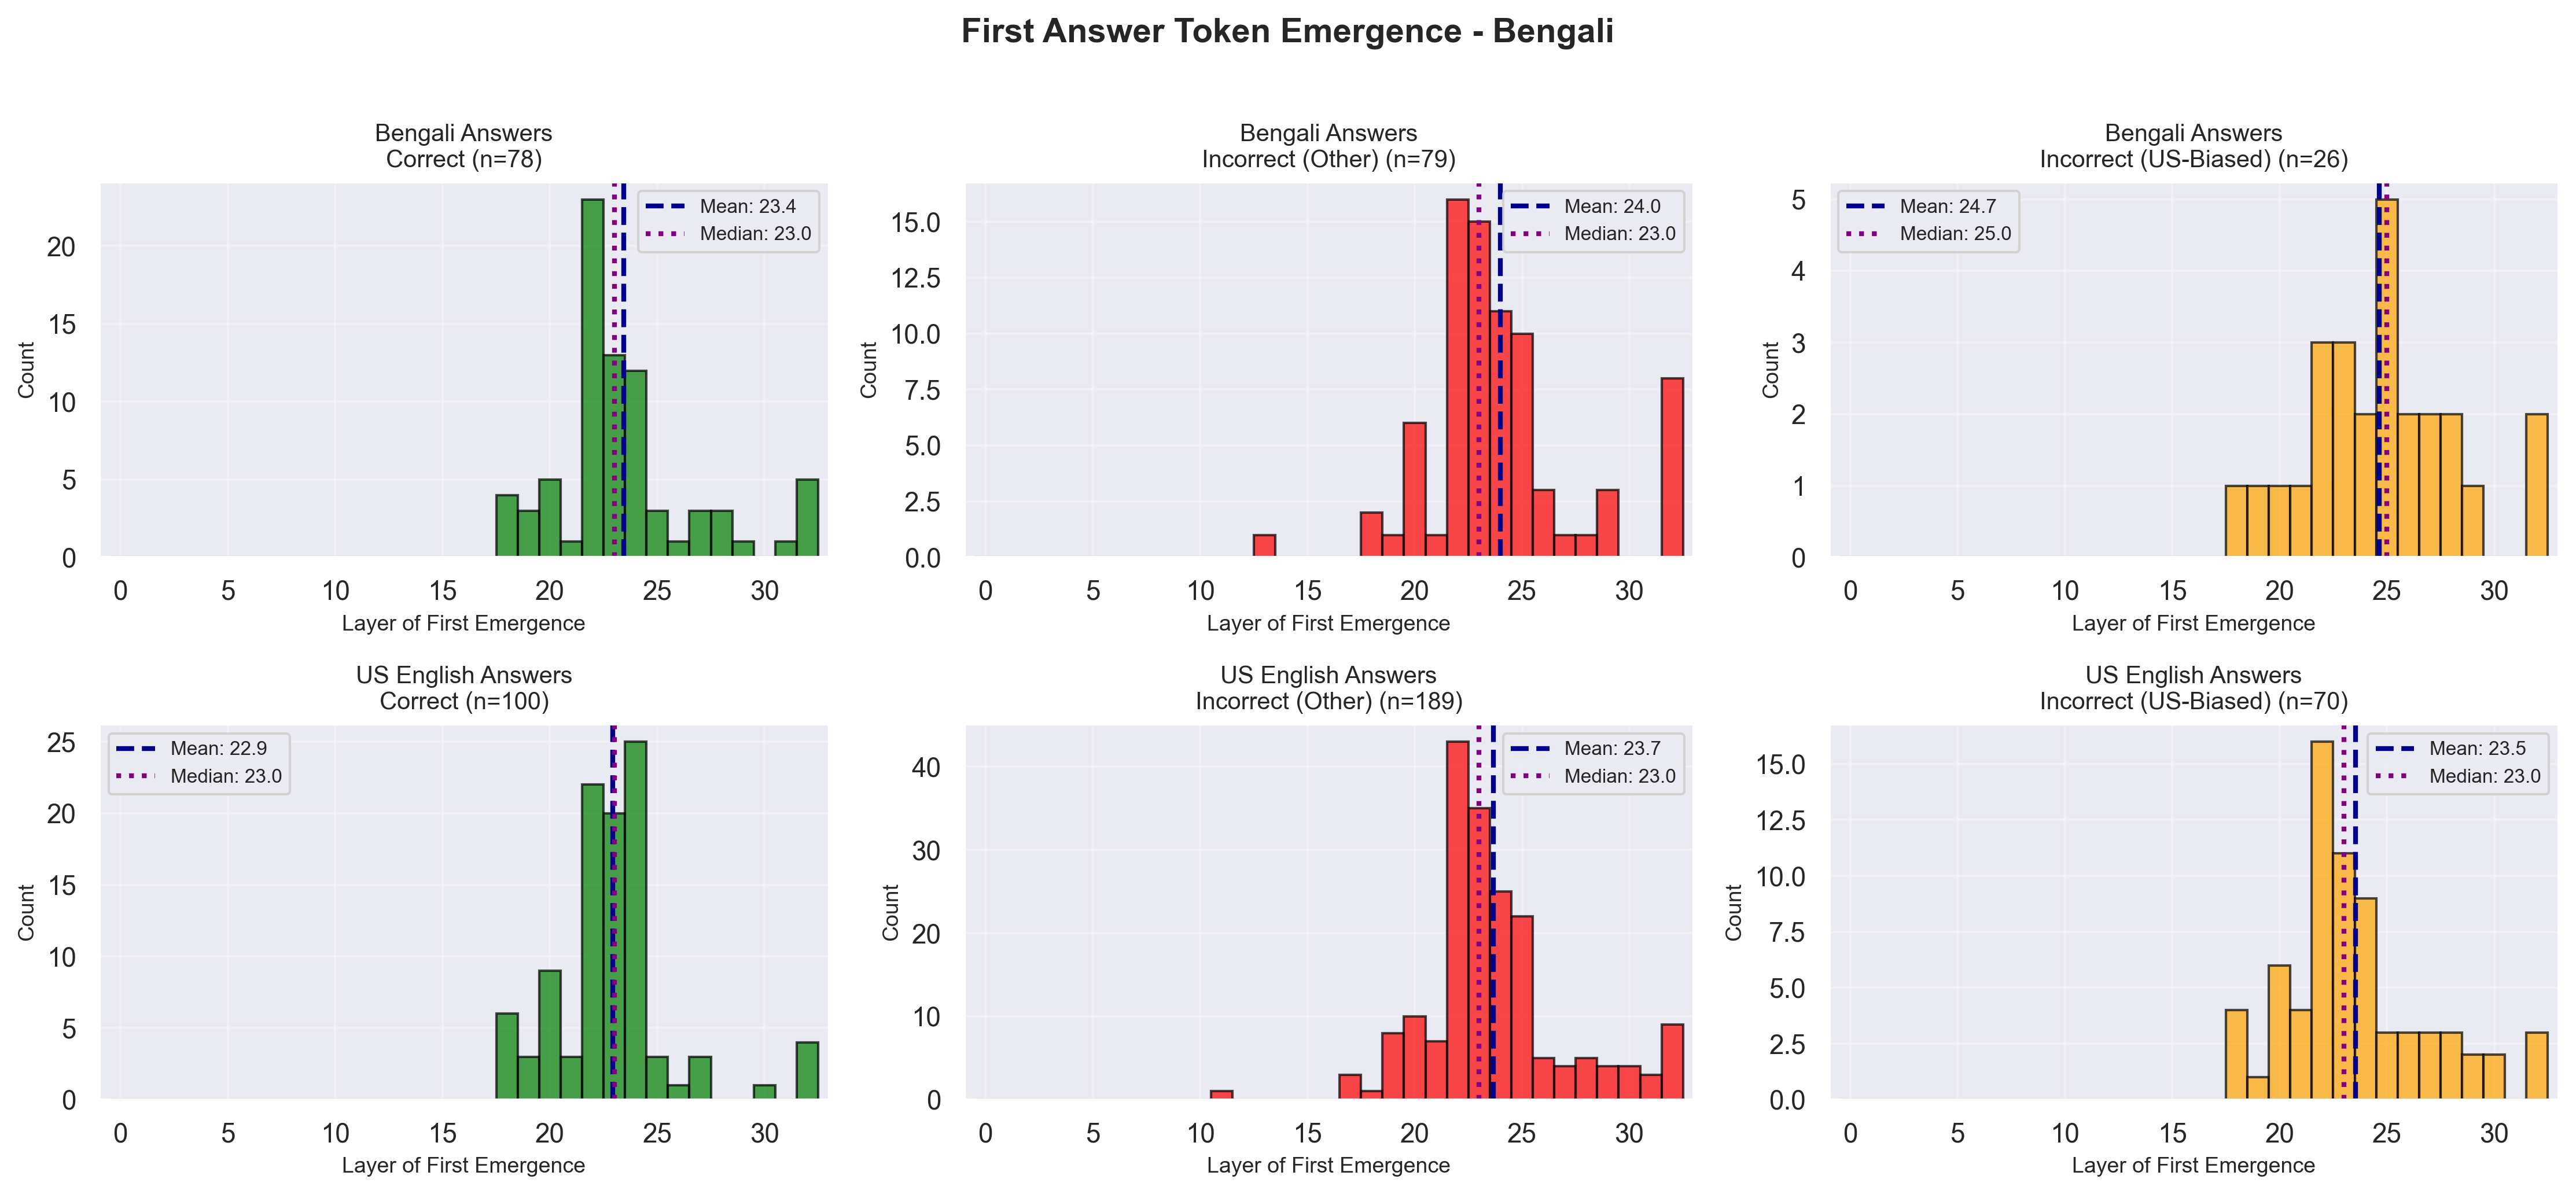

In [35]:
def track_first_emergence_per_answer(logit_lens_data: List[Dict], 
                                     expected_answers: List[str],
                                     language: str = "english") -> Dict[str, int]:
    """
    Track the first layer where each expected answer appears.
    Returns: {answer: first_layer}
    """
    if not logit_lens_data or not expected_answers:
        return {}
    
    expected_normalized = {}
    for ans in expected_answers:
        ans_norm = normalize_answer(ans, language)
        if ans_norm:
            expected_normalized[ans_norm] = None 
    
    for layer_data in logit_lens_data:
        layer_num = layer_data.get("layer")
        predictions = layer_data.get("predictions", [])
        
        for pred in predictions:
            token = pred.get("token", "").strip()
            if not token:
                continue
            
            token_norm = normalize_answer(token, language)
            if not token_norm:
                continue
            
            if token_norm in expected_normalized and expected_normalized[token_norm] is None:
                expected_normalized[token_norm] = layer_num
    
    return {ans: layer for ans, layer in expected_normalized.items() if layer is not None}


def collect_first_emergence_data(df_classified: pd.DataFrame, 
                                 df_lens: pd.DataFrame,
                                 language: str,
                                 answer_type: str = "bengali") -> Dict[str, List[int]]:
    emergence_data = {
        State.CORRECT: [],
        State.INCORRECT: [],
        State.US_BIASED: []
    }
    
    df_eng = load_language_data("english", translated=False)
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        if answer_type == "bengali":
            expected_answers = df_classified.loc[idx, "TranslatedAnswerList"]
            check_language = "english"
        else:  # "us"
            if idx not in df_eng.index:
                continue
            expected_answers = df_eng.loc[idx, "Answer"]
            check_language = "english"
        
        if not expected_answers:
            continue
        
        first_emergence = track_first_emergence_per_answer(logit_lens, expected_answers, check_language)
        
        for ans, layer in first_emergence.items():
            emergence_data[state].append(layer)
    
    return emergence_data


def plot_first_emergence_distributions(language: str, df_classified: pd.DataFrame):
    """
    Create 6 plots showing first emergence distributions.
    2 answer types × 3 states
    """
    df_lens = load_lens_data(language)
    
    bengali_data = collect_first_emergence_data(df_classified, df_lens, language, "bengali")
    us_data = collect_first_emergence_data(df_classified, df_lens, language, "us")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 7))
    
    states = [State.CORRECT, State.INCORRECT, State.US_BIASED]
    state_labels = ["Correct", "Incorrect (Other)", "Incorrect (US-Biased)"]
    colors = {"correct": "green", "incorrect": "red", "us_biased": "orange"}
    
    answer_types = [
        ("bengali", "Bengali Answers", bengali_data),
        ("us", "US English Answers", us_data)
    ]
    
    for row, (answer_type, answer_label, data) in enumerate(answer_types):
        for col, (state, state_label) in enumerate(zip(states, state_labels)):
            ax = axes[row, col]
            
            layers = data[state]
            
            if len(layers) > 0:
                # Create histogram
                bins = np.arange(0, LAYER_COUNT + 2) - 0.5
                ax.hist(layers, bins=bins, alpha=0.7, color=colors[state], edgecolor='black')
                
                # Add statistics
                mean_layer = np.mean(layers)
                median_layer = np.median(layers)
                ax.axvline(mean_layer, color='darkblue', linestyle='--', linewidth=2, 
                          label=f'Mean: {mean_layer:.1f}')
                ax.axvline(median_layer, color='purple', linestyle=':', linewidth=2, 
                          label=f'Median: {median_layer:.1f}')
                ax.legend(fontsize=8)
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
            
            # Labels
            ax.set_xlabel('Layer of First Emergence', fontsize=9)
            ax.set_ylabel('Count', fontsize=9)
            ax.set_title(f'{answer_label}\n{state_label} (n={len(layers)})', 
                        fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_xlim(-1, LAYER_COUNT + 1)
    
    plt.suptitle(f'First Answer Token Emergence - {language.capitalize()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/first_emergence_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


def print_first_emergence_statistics(language: str, df_classified: pd.DataFrame):
    """Print summary statistics for first emergence analysis."""
    df_lens = load_lens_data(language)
    
    bengali_data = collect_first_emergence_data(df_classified, df_lens, language, "bengali")
    us_data = collect_first_emergence_data(df_classified, df_lens, language, "us")
    
    print(f"\n{'='*80}")
    print(f"First Answer Token Emergence Statistics - {language.capitalize()}")
    print(f"{'='*80}\n")
    
    for answer_type, answer_label, data in [("bengali", "Bengali Answers", bengali_data),
                                             ("us", "US English Answers", us_data)]:
        print(f"\n{answer_label}:")
        print("-" * 80)
        
        for state, state_label in [(State.CORRECT, "Correct"),
                                    (State.INCORRECT, "Incorrect (Other)"),
                                    (State.US_BIASED, "Incorrect (US-Biased)")]:
            layers = data[state]
            
            if len(layers) > 0:
                mean_layer = np.mean(layers)
                std_layer = np.std(layers)
                median_layer = np.median(layers)
                min_layer = np.min(layers)
                max_layer = np.max(layers)
                
                print(f"\n  {state_label}:")
                print(f"    Total answer tokens found: {len(layers)}")
                print(f"    Mean first emergence: {mean_layer:.2f}")
                print(f"    Std: {std_layer:.2f}")
                print(f"    Median: {median_layer:.1f}")
                print(f"    Range: [{min_layer}, {max_layer}]")
            else:
                print(f"\n  {state_label}: No data")

print_first_emergence_statistics("bengali", modified_dfs_bias["bengali"])
plot_first_emergence_distributions("bengali", modified_dfs_bias["bengali"])

# Cosine Similarity


Cross-Lingual Representation Similarity Analysis

Cross-Lingual Similarity Statistics: English vs Bengali


Correct (n=60):
  Overall mean similarity: 0.4445
  Early layers (0-9): 0.5555
  Middle layers (10-19): 0.4731
  Late layers (20+): 0.3371
  Maximum similarity at layer 0: 1.0000

Incorrect (Other) (n=223):
  Overall mean similarity: 0.4447
  Early layers (0-9): 0.5714
  Middle layers (10-19): 0.4550
  Late layers (20+): 0.3393
  Maximum similarity at layer 0: 1.0000

Incorrect (US-Biased) (n=52):
  Overall mean similarity: 0.4921
  Early layers (0-9): 0.5529
  Middle layers (10-19): 0.4971
  Late layers (20+): 0.4416
  Maximum similarity at layer 0: 1.0000

Plotting Cross-Lingual Similarity...
Saved plot: figures/cross_lingual_similarity_eng_bengali.png


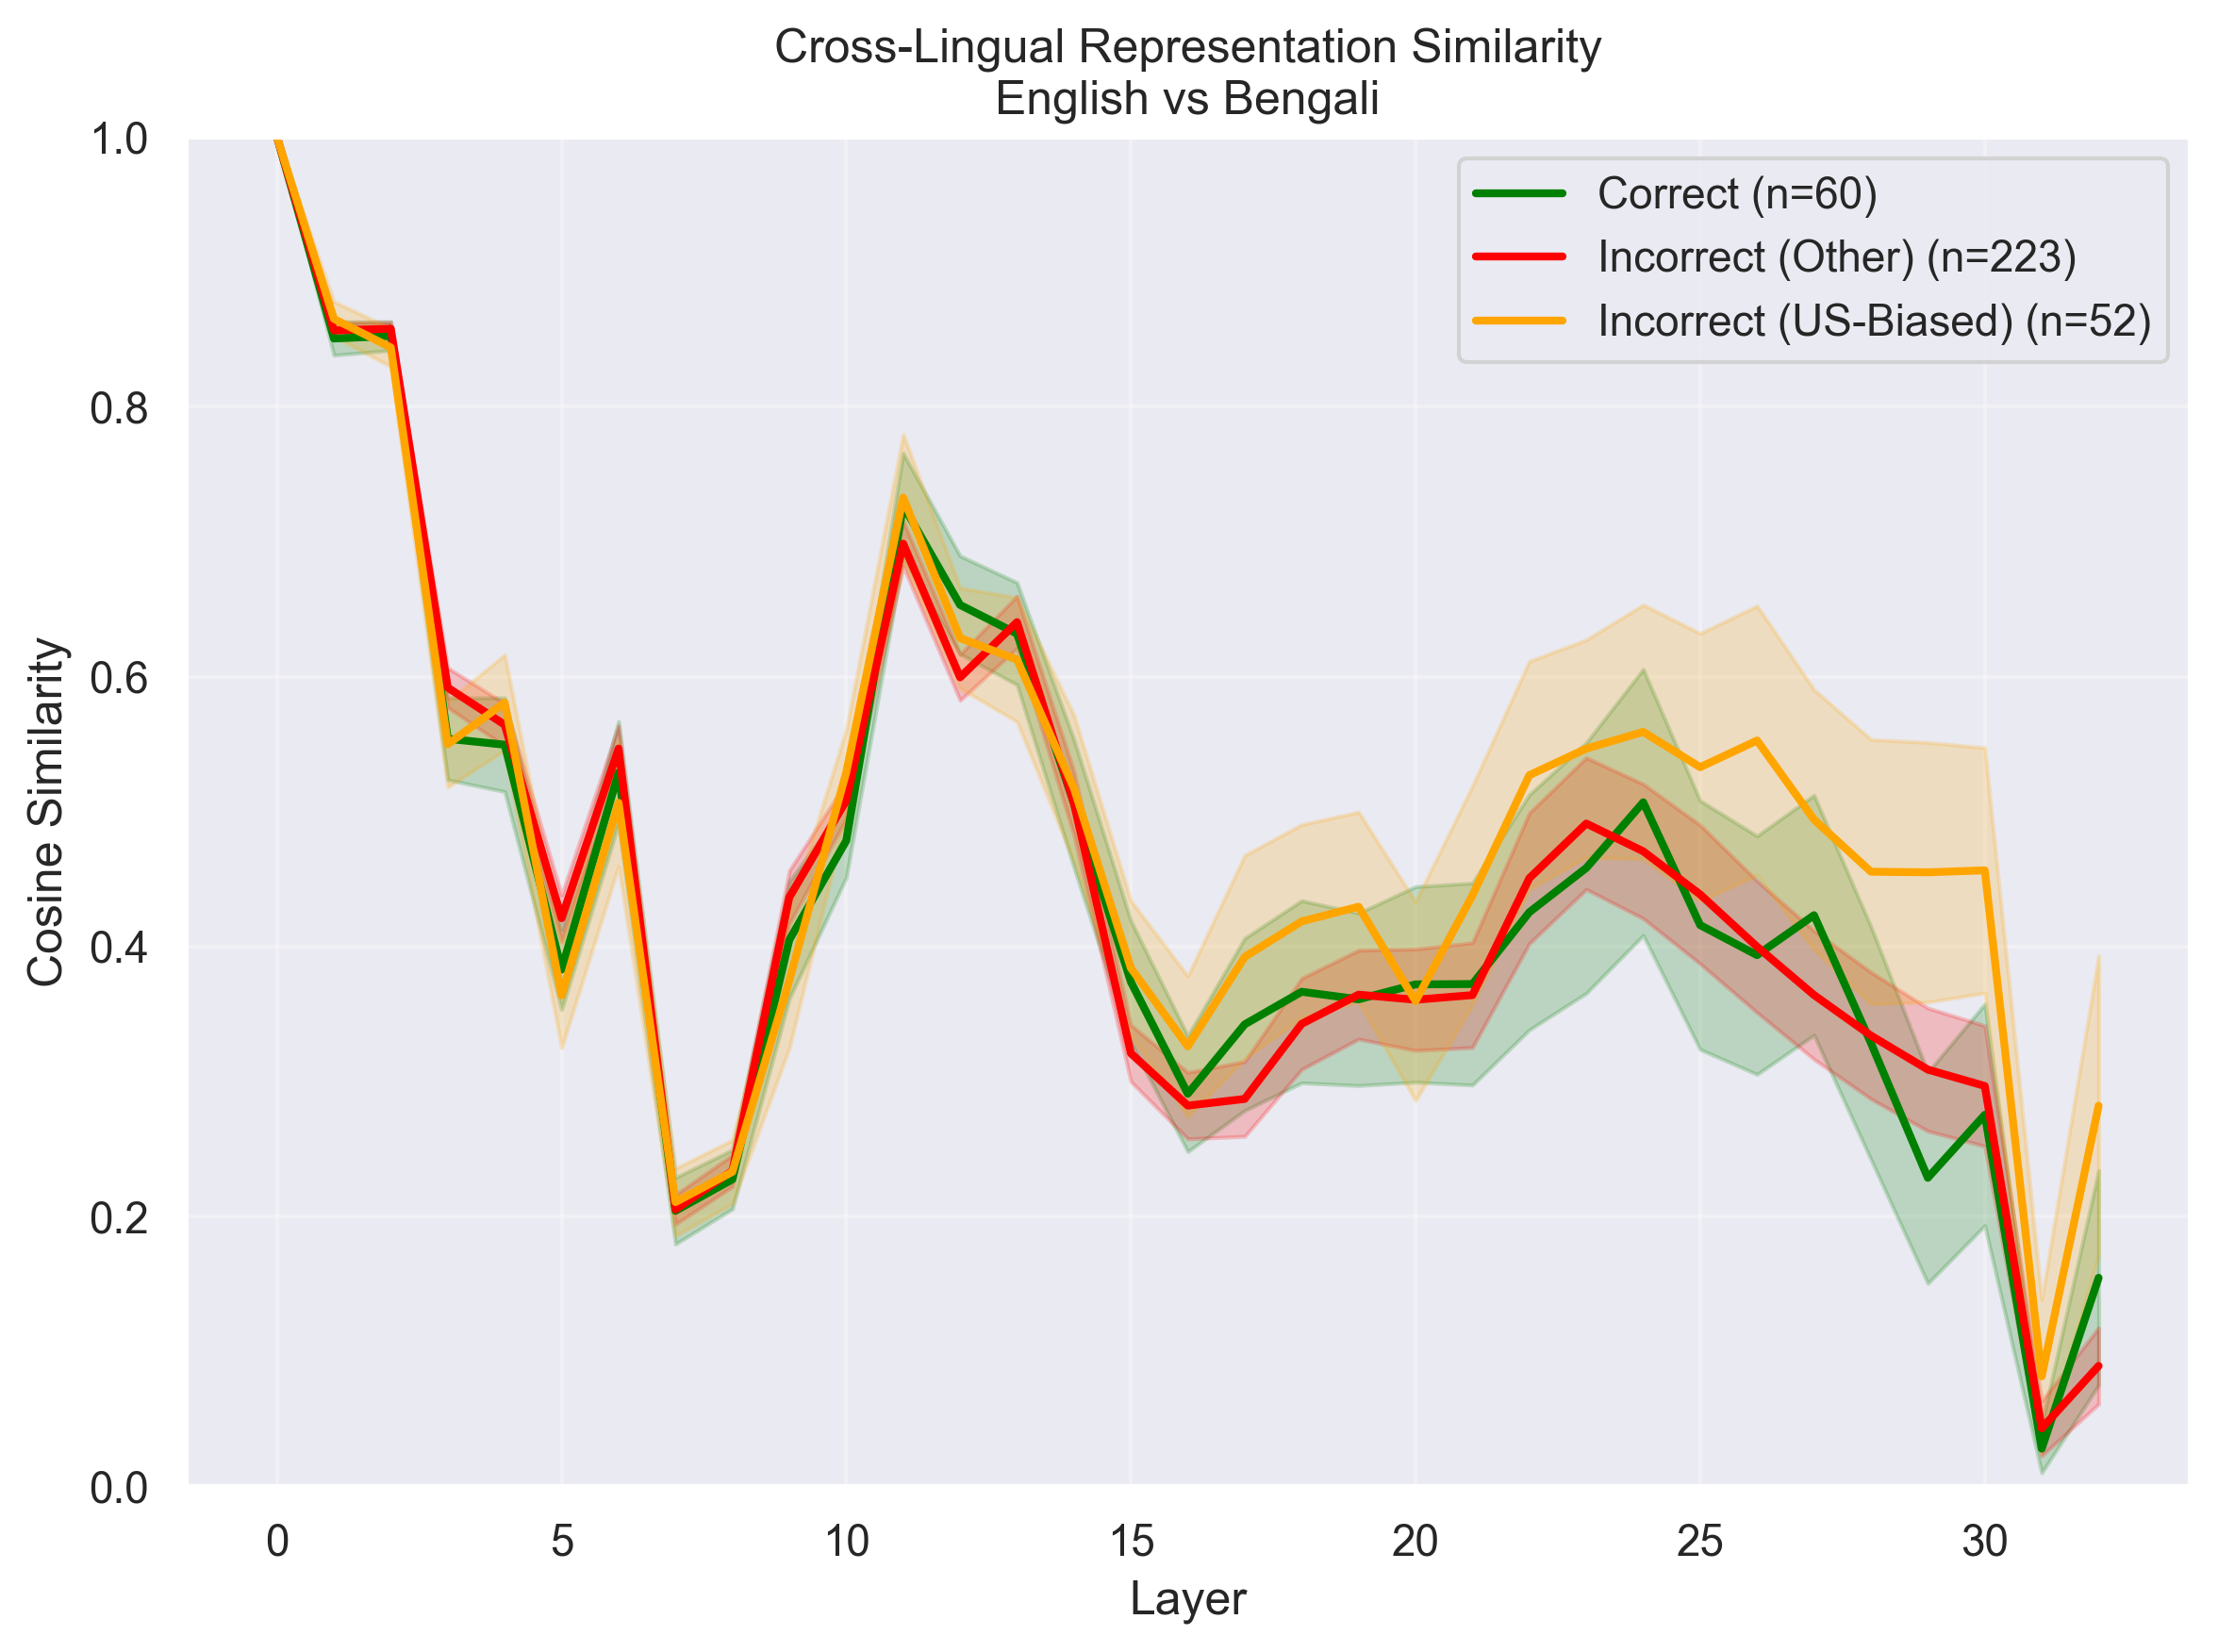

In [32]:
def get_probability_vector_at_layer(layer_data: Dict, vocab_size: int = 128256512) -> np.ndarray:
    """
    Create a sparse probability vector from layer predictions.
    Returns a vector where index = token_id, value = probability.
    """
    prob_vector = np.zeros(vocab_size)
    
    predictions = layer_data.get("predictions", [])
    for pred in predictions:
        token_id = pred.get("token_id")
        confidence = pred.get("confidence", 0.0)
        if token_id is not None and 0 <= token_id < vocab_size:
            prob_vector[token_id] = confidence
    
    return prob_vector


def compute_cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return np.dot(vec1, vec2) / (norm1 * norm2)


def compute_layer_wise_similarity(logit_lens_eng: List[Dict], 
                                  logit_lens_lang: List[Dict],
                                  vocab_size: int = 128256) -> np.ndarray:
    if not logit_lens_eng or not logit_lens_lang:
        return np.array([])
    
    min_layers = min(len(logit_lens_eng), len(logit_lens_lang))
    similarities = []
    
    for i in range(min_layers):
        vec_eng = get_probability_vector_at_layer(logit_lens_eng[i], vocab_size)
        vec_lang = get_probability_vector_at_layer(logit_lens_lang[i], vocab_size)
        
        sim = compute_cosine_similarity(vec_eng, vec_lang)
        similarities.append(sim)
    
    return np.array(similarities)


def collect_cross_lingual_similarities(df_eng_classified: pd.DataFrame,
                                       df_lang_classified: pd.DataFrame,
                                       df_eng_lens: pd.DataFrame,
                                       df_lang_lens: pd.DataFrame) -> Dict[str, List[np.ndarray]]:
    similarities = {
        State.CORRECT: [],
        State.INCORRECT: [],
        State.US_BIASED: []
    }
    
    for idx in df_lang_classified.index:
        state = df_lang_classified.loc[idx, "State"]
        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_eng_lens.index or idx not in df_lang_lens.index:
            continue
        
        eng_lens_data = df_eng_lens.loc[idx, "Lens"]
        lang_lens_data = df_lang_lens.loc[idx, "Lens"]
        
        eng_logit_lens = eng_lens_data.get("LogitLens", [])
        lang_logit_lens = lang_lens_data.get("LogitLens", [])
        
        if not eng_logit_lens or not lang_logit_lens:
            continue
        
        sim_trajectory = compute_layer_wise_similarity(eng_logit_lens, lang_logit_lens)
        
        if len(sim_trajectory) > 0:
            similarities[state].append(sim_trajectory)
    
    return similarities


def plot_cross_lingual_similarity(language: str,
                                  df_eng_classified: pd.DataFrame,
                                  df_lang_classified: pd.DataFrame):
    df_eng_lens = load_lens_data("english")
    df_lang_lens = load_lens_data(language)
    
    similarities = collect_cross_lingual_similarities(
        df_eng_classified, df_lang_classified, df_eng_lens, df_lang_lens
    )
    
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {
        State.CORRECT: "green",
        State.INCORRECT: "red",
        State.US_BIASED: "orange"
    }
    labels = {
        State.CORRECT: "Correct",
        State.INCORRECT: "Incorrect (Other)",
        State.US_BIASED: "Incorrect (US-Biased)"
    }
    
    for state in [State.CORRECT, State.INCORRECT, State.US_BIASED]:
        if not similarities[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(similarities[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(similarities[state])})", 
                color=colors[state], linewidth=2)
        
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Cosine Similarity")
    ax.set_title(f"Cross-Lingual Representation Similarity\nEnglish vs {language.capitalize()}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1]) 
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/cross_lingual_similarity_eng_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


def print_cross_lingual_statistics(language: str,
                                   df_eng_classified: pd.DataFrame,
                                   df_lang_classified: pd.DataFrame):
    df_eng_lens = load_lens_data("english")
    df_lang_lens = load_lens_data(language)
    
    similarities = collect_cross_lingual_similarities(
        df_eng_classified, df_lang_classified, df_eng_lens, df_lang_lens
    )
    
    print(f"\n{'='*80}")
    print(f"Cross-Lingual Similarity Statistics: English vs {language.capitalize()}")
    print(f"{'='*80}\n")
    
    for state, label in [(State.CORRECT, "Correct"),
                         (State.INCORRECT, "Incorrect (Other)"),
                         (State.US_BIASED, "Incorrect (US-Biased)")]:
        
        if not similarities[state]:
            print(f"{label}: No data")
            continue
        
        all_sims = np.vstack(similarities[state])
        mean_per_layer = np.mean(all_sims, axis=0)
        
        overall_mean = np.mean(mean_per_layer)
        early_layers_mean = np.mean(mean_per_layer[:10])  # Layers 0-9
        middle_layers_mean = np.mean(mean_per_layer[10:20])  # Layers 10-19
        late_layers_mean = np.mean(mean_per_layer[20:])  # Layers 20+
        
        print(f"\n{label} (n={len(similarities[state])}):")
        print(f"  Overall mean similarity: {overall_mean:.4f}")
        print(f"  Early layers (0-9): {early_layers_mean:.4f}")
        print(f"  Middle layers (10-19): {middle_layers_mean:.4f}")
        print(f"  Late layers (20+): {late_layers_mean:.4f}")
        
        # Find layer of maximum similarity
        max_sim_layer = np.argmax(mean_per_layer)
        max_sim_value = mean_per_layer[max_sim_layer]
        print(f"  Maximum similarity at layer {max_sim_layer}: {max_sim_value:.4f}")


print("\n" + "="*80)
print("Cross-Lingual Representation Similarity Analysis")
print("="*80)

print_cross_lingual_statistics("bengali", 
                                modified_dfs_bias["english"], 
                                modified_dfs_bias["bengali"])

print("\n" + "="*80)
print("Plotting Cross-Lingual Similarity...")
print("="*80)

plot_cross_lingual_similarity("bengali",
                              modified_dfs_bias["english"],
                              modified_dfs_bias["bengali"])